In [7]:
# 최초 크롤링

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
from datetime import datetime
from tqdm import tqdm

def setup_driver():
    """Chrome 드라이버를 설정하고 반환합니다."""
    chrome_driver_path = 'C:\\chromedriver-win64\\chromedriver.exe'
    service = Service(chrome_driver_path)

    options = Options()
    options.add_argument("--disable-notifications")
    options.add_argument("--start-maximized")

    driver = webdriver.Chrome(service=service, options=options)
    return driver

def crawl_blog_posts(search_queries, max_posts_per_query=300, max_pages=10):
    current_time = datetime.now().strftime('%y-%m-%d')
    
    driver = setup_driver()

    all_data = []

    for search_query in search_queries:
        search_query_encoded = search_query.replace(' ', '+')  # 검색어를 URL 인코딩
        url_template = f'https://section.blog.naver.com/Search/Post.naver?pageNo={{}}&rangeType=ALL&orderBy=sim&keyword={search_query_encoded}'
        
        url_list = []
        title_list = []
        seen_urls = set()  # 중복 확인을 위한 집합(Set)

        for page in range(1, max_pages + 1):
            search_url = url_template.format(page)
            driver.get(search_url)
            time.sleep(3)
            
            try:
                # 블로그 글 제목과 URL 수집
                article_raw = driver.find_elements(By.CSS_SELECTOR, '.info_post .desc a')
                
                if not article_raw:
                    print(f"페이지 {page}에서 블로그 포스트를 찾을 수 없습니다.")
                    break
                
                for article in article_raw:
                    url = article.get_attribute('href')
                    
                    # 이미 수집된 URL인지 확인 (중복 제거)
                    if url in seen_urls:
                        continue  # 중복된 URL은 무시
                    
                    seen_urls.add(url)  # 새로운 URL은 집합에 추가
                    
                    title_element = article.find_element(By.XPATH, './strong')
                    title = title_element.text
                    url_list.append(url)
                    title_list.append(title)

                    if len(url_list) >= max_posts_per_query:
                        break
                
                if len(url_list) >= max_posts_per_query:
                    break
            except Exception as e:
                print(f"페이지 {page}에서 오류 발생: {e}")
                continue
        
        # 수집한 URL과 제목을 DataFrame에 저장
        df = pd.DataFrame({'주소': url_list, '제목': title_list})
        
        # 크롤링한 내용을 포함한 DataFrame을 Excel 파일로 저장
        df['검색어'] = search_query
        df['작성일자'] = None
        df['태그'] = None
        df['내용'] = None

        number = len(df)

        for i in tqdm(range(number), desc=f"Crawling: {search_query}"):
            url = df['주소'][i]
            driver.get(url)    
            time.sleep(3)

            try:
                # 블로그 본문 iframe으로 전환
                WebDriverWait(driver, 10).until(
                    EC.frame_to_be_available_and_switch_to_it((By.ID, 'mainFrame'))
                )

                # 제목 추출
                tit = driver.find_element(By.CSS_SELECTOR, '.se-module.se-module-text.se-title-text')
                title = tit.text

                # 날짜 및 시간 추출
                date = driver.find_element(By.CSS_SELECTOR, '.se_publishDate.pcol2')
                datetime_text = date.text

                df.at[i, '작성일자'] = datetime_text

                # 태그 추출
                tags = driver.find_elements(By.CSS_SELECTOR, '.wrap_tag .ell')
                tag_list = [tag.text for tag in tags]
                tag_str = ' '.join(tag_list)
                df.at[i, '태그'] = tag_str

                # 내용 추출
                contents = driver.find_elements(By.CSS_SELECTOR, '.se-module.se-module-text')
                content_list = [content.text for content in contents]
                content_str = ' '.join(content_list)
                df.at[i, '내용'] = content_str

                print(f"{i}번째 글 크롤링 완료: {title}")

            except Exception as e:
                print(f"{i}번째 글에서 오류 발생: {e}")
                continue

        all_data.append(df)

    all_df = pd.concat(all_data, ignore_index=True)
    all_df.to_excel(f"../data/최초크롤링_{current_time}.xlsx", index=False)

    print("수집한 글 갯수:", len(all_df.dropna(subset=['내용'])))

    driver.quit()

# 함수 호출 예제
search_queries = ['서울 핫플레이스']
crawl_blog_posts(search_queries, max_posts_per_query=500, max_pages=500)

Crawling: 서울 핫플레이스:   0%|                                                     | 1/500 [00:27<3:49:26, 27.59s/it]

0번째 글 크롤링 완료: 서울 핫플레이스 익선동 한옥거리 데이트 코스 익선동맛집 이층양옥 채끝등심과 뇨끼


Crawling: 서울 핫플레이스:   0%|▏                                                    | 2/500 [00:32<1:58:31, 14.28s/it]

1번째 글 크롤링 완료: 브라이튼 여의도 선임대 후분양 서울 핫 플레이스 여의도 국제금융 지구 신축 분양 소식 입니다


Crawling: 서울 핫플레이스:   1%|▎                                                    | 3/500 [00:58<2:44:13, 19.83s/it]

2번째 글 크롤링 완료: 서울 핫플레이스 용산데이트 용리단길 브런치 맛집 쌤쌤쌤


Crawling: 서울 핫플레이스:   1%|▍                                                    | 4/500 [01:03<1:52:48, 13.65s/it]

3번째 글 크롤링 완료: 안국 맛집 온6.5 김치 다이닝 서울 핫플레이스


Crawling: 서울 핫플레이스:   1%|▌                                                    | 5/500 [01:07<1:23:49, 10.16s/it]

4번째 글 크롤링 완료: 여자 혼자놀기 서울 여행 핫플레이스 영등포구청역 카페 맨홀커피 웨스턴


Crawling: 서울 핫플레이스:   1%|▋                                                    | 6/500 [01:12<1:10:13,  8.53s/it]

5번째 글 크롤링 완료: 명동역 카페 서울 핫플레이스 브레디포스트 디저트 프레즐


Crawling: 서울 핫플레이스:   1%|▊                                                      | 7/500 [01:16<58:07,  7.07s/it]

6번째 글 크롤링 완료: 뚝섬 한강공원 2024 서울국제정원박람회 인사이드 아웃 가든 서울 핫플레이스


Crawling: 서울 핫플레이스:   2%|▉                                                      | 8/500 [01:20<50:29,  6.16s/it]

7번째 글 크롤링 완료: 왕십리 한양대 맛집 제일곱창 맛있는 서울 핫플레이스


Crawling: 서울 핫플레이스:   2%|▉                                                      | 9/500 [01:25<47:19,  5.78s/it]

8번째 글 크롤링 완료: 서울 핫플레이스 스타벅스 경동1960 데이트 코스 겨울 동대문 가볼만한곳


Crawling: 서울 핫플레이스:   2%|█                                                   | 10/500 [01:42<1:15:48,  9.28s/it]

9번째 글 크롤링 완료: 서울 갈곳 이색 데이트 핫플레이스 서울 카페 스타벅스 경성 1960 점


Crawling: 서울 핫플레이스:   2%|█▏                                                  | 11/500 [01:47<1:04:44,  7.94s/it]

10번째 글 크롤링 완료: 서울 핫플레이스 청계천 구경,종로 광화문산책


Crawling: 서울 핫플레이스:   2%|█▎                                                    | 12/500 [01:53<59:00,  7.25s/it]

11번째 글 크롤링 완료: 서울 시티뷰 1열 창신동 핫플레이스 카페 테르트르


Crawling: 서울 핫플레이스:   3%|█▍                                                    | 13/500 [01:57<50:51,  6.27s/it]

12번째 글 크롤링 완료: 양재 고기집 한우 전문 양반등심, 서울 핫플레이스


Crawling: 서울 핫플레이스:   3%|█▌                                                    | 14/500 [02:01<45:49,  5.66s/it]

13번째 글 크롤링 완료: 계단집 회현역🏡 남산 근처 예쁜 카페 곧 서울 핫플레이스 될 듯


Crawling: 서울 핫플레이스:   3%|█▌                                                    | 15/500 [02:05<42:08,  5.21s/it]

14번째 글 크롤링 완료: 서울핫플레이스 압구정로데오거리 데이트 맛집 청담고수


Crawling: 서울 핫플레이스:   3%|█▋                                                    | 16/500 [02:10<39:56,  4.95s/it]

15번째 글 크롤링 완료: 안국역 카페 도토리가든 지브리감성 브런치 실내데이트 서울 지하철 여행 놀거리 종로 핫플레이스


Crawling: 서울 핫플레이스:   3%|█▊                                                    | 17/500 [02:15<40:46,  5.07s/it]

16번째 글 크롤링 완료: 서울 핫플레이스 빛의 시어터 크리스마스 실내 데이트 추천


Crawling: 서울 핫플레이스:   4%|█▉                                                    | 18/500 [02:19<38:16,  4.77s/it]

17번째 글 크롤링 완료: 서울 핫플레이스 잠실 가볼만한곳 서울 벚꽃 잠실 석촌호수 벚꽃축제


Crawling: 서울 핫플레이스:   4%|██                                                    | 19/500 [02:23<36:04,  4.50s/it]

18번째 글 크롤링 완료: 서울 핫플레이스 을지로3가 아메리칸 핫도그 맛집 올디스핫도그 칠리핫도그세트 후기


Crawling: 서울 핫플레이스:   4%|██▏                                                   | 20/500 [02:28<37:12,  4.65s/it]

19번째 글 크롤링 완료: 홍철책빵 용산 서울역카페 데이트 서울핫플레이스


Crawling: 서울 핫플레이스:   4%|██▎                                                   | 21/500 [02:32<35:40,  4.47s/it]

20번째 글 크롤링 완료: 서울 핫플레이스 랜드마크 🌕 서울달 (여의도 데이트코스 추천 💛)


Crawling: 서울 핫플레이스:   4%|██▍                                                   | 22/500 [02:37<35:57,  4.51s/it]

21번째 글 크롤링 완료: 튤립 가득 야외 데이트 성수동 서울숲 돗자리 피크닉 서울 핫플레이스


Crawling: 서울 핫플레이스:   5%|██▍                                                   | 23/500 [02:41<34:33,  4.35s/it]

22번째 글 크롤링 완료: 서울 성수동 핫플레이스 산책. 포인트오브뷰. 카페 쎈느. 디올 성수 등


Crawling: 서울 핫플레이스:   5%|██▌                                                   | 24/500 [02:45<34:09,  4.31s/it]

23번째 글 크롤링 완료: 서울 핫플레이스 라네즈 푸바오 성수 놀거리 팝업


Crawling: 서울 핫플레이스:   5%|██▋                                                   | 25/500 [02:49<33:35,  4.24s/it]

24번째 글 크롤링 완료: 광화문 광장 볼거리 놀거리 서울 핫플레이스 아이와 야외 데이트 가볼만한곳


Crawling: 서울 핫플레이스:   5%|██▊                                                   | 26/500 [02:54<35:02,  4.44s/it]

25번째 글 크롤링 완료: 서대문 락희안 가좌본점 서울 핫플레이스 꿔바로우 맛집


Crawling: 서울 핫플레이스:   5%|██▉                                                   | 27/500 [02:58<34:48,  4.42s/it]

26번째 글 크롤링 완료: 서울 핫플레이스 압구정로데오거리 프롬헤라스 카페 데이트


Crawling: 서울 핫플레이스:   6%|███                                                   | 28/500 [03:03<34:47,  4.42s/it]

27번째 글 크롤링 완료: 서순라길 야장 맛집 익선동 공방 데이트 서울 종로 핫플레이스


Crawling: 서울 핫플레이스:   6%|███▏                                                  | 29/500 [03:08<36:22,  4.63s/it]

28번째 글 크롤링 완료: 서울 핫플레이스 카페 경동시장 스타벅스 경동1960 금성전파사


Crawling: 서울 핫플레이스:   6%|███▏                                                  | 30/500 [03:12<36:00,  4.60s/it]

29번째 글 크롤링 완료: 서울실내데이트코스 테디뵈르하우스 맛있는빵집 여의도 더현대 핫플레이스,무료주차


Crawling: 서울 핫플레이스:   6%|███▎                                                  | 31/500 [03:17<36:14,  4.64s/it]

30번째 글 크롤링 완료: 🇭🇰홍콩감성 서울 핫플레이스 창신동 창창🇭🇰


Crawling: 서울 핫플레이스:   6%|███▍                                                  | 32/500 [03:22<36:39,  4.70s/it]

31번째 글 크롤링 완료: [서울 핫플레이스]영종도 인스파이어 복합 리조트 방문기


Crawling: 서울 핫플레이스:   7%|███▌                                                  | 33/500 [03:27<37:48,  4.86s/it]

32번째 글 크롤링 완료: 서울여행 가볼만한곳 더현대서울 핫플레이스 크리스마스마을 수제버거


Crawling: 서울 핫플레이스:   7%|███▋                                                  | 34/500 [03:34<41:32,  5.35s/it]

33번째 글 크롤링 완료: 서울 핫플레이스 을지로 루프탑 맛집 행2PM8PM와인바


Crawling: 서울 핫플레이스:   7%|███▊                                                  | 35/500 [03:38<38:34,  4.98s/it]

34번째 글 크롤링 완료: 서울 핫플레이스 서순라길 맛집 테라스 술집 술24 내돈내산 솔직후기


Crawling: 서울 핫플레이스:   7%|███▉                                                  | 36/500 [03:42<36:17,  4.69s/it]

35번째 글 크롤링 완료: 서울핫플레이스 가볼만한곳_퍼블릭가산


Crawling: 서울 핫플레이스:   7%|███▉                                                  | 37/500 [03:46<35:06,  4.55s/it]

36번째 글 크롤링 완료: 동대문 디자인 플라자 놀거리 DDP 디자인 스토어 서울 핫플레이스


Crawling: 서울 핫플레이스:   8%|████                                                  | 38/500 [03:50<34:33,  4.49s/it]

37번째 글 크롤링 완료: 신세계 강남점 BTS 타이니탄 토이스토리 팝업스토어 서울 핫플레이스


Crawling: 서울 핫플레이스:   8%|████▏                                                 | 39/500 [03:54<32:39,  4.25s/it]

38번째 글 크롤링 완료: 서울 핫플레이스 문래창작촌 카페 영등포 데이트


Crawling: 서울 핫플레이스:   8%|████▎                                                 | 40/500 [03:58<33:06,  4.32s/it]

39번째 글 크롤링 완료: 서울핫플레이스 용산 용리단길 카페 빵지순례 카페 모음


Crawling: 서울 핫플레이스:   8%|████▍                                                 | 41/500 [04:06<39:26,  5.16s/it]

40번째 글 크롤링 완료: 경복궁의 가을, 서울 핫 플레이스! 광화문광장에서 경복궁까지 서울 여행 코스


Crawling: 서울 핫플레이스:   8%|████▌                                                 | 42/500 [04:10<38:37,  5.06s/it]

41번째 글 크롤링 완료: 서울 가볼만한곳 핫플레이스 서울 카페 명동 데이트 놀거리 더스팟패뷸러스


Crawling: 서울 핫플레이스:   9%|████▋                                                 | 43/500 [04:15<36:56,  4.85s/it]

42번째 글 크롤링 완료: 서울 크리스마스 가볼만한곳 서울 코엑스 별마당도서관 트리 서울 핫플레이스


Crawling: 서울 핫플레이스:   9%|████▊                                                 | 44/500 [04:19<34:43,  4.57s/it]

43번째 글 크롤링 완료: 2024 서울 축제 서울콘 서울 핫플레이스 동대문DDP 미리보기


Crawling: 서울 핫플레이스:   9%|████▊                                                 | 45/500 [04:23<33:13,  4.38s/it]

44번째 글 크롤링 완료: 서울 종로 데이트 코스 서순라길 야장 핫플레이스


Crawling: 서울 핫플레이스:   9%|████▉                                                 | 46/500 [04:27<33:48,  4.47s/it]

45번째 글 크롤링 완료: 럭셔리 크리스탈 바카라x필립스탁 메종바라카 서울 핫플레이스 전시 만나요


Crawling: 서울 핫플레이스:   9%|█████                                                 | 47/500 [04:32<33:58,  4.50s/it]

46번째 글 크롤링 완료: 서울 핫플레이스 데이트 마테오견문록 한남동 핫플 보닐라츄러스


Crawling: 서울 핫플레이스:  10%|█████▏                                                | 48/500 [04:38<37:27,  4.97s/it]

47번째 글 크롤링 완료: 서울 가볼만한곳 핫플레이스 우이천 벚꽃 축제 실시간


Crawling: 서울 핫플레이스:  10%|█████▎                                                | 49/500 [04:42<36:01,  4.79s/it]

48번째 글 크롤링 완료: 해방촌 신흥시장 서울핫플레이스 용산 해방촌 데이트 이태원 소품샵


Crawling: 서울 핫플레이스:  10%|█████▍                                                | 50/500 [04:46<34:25,  4.59s/it]

49번째 글 크롤링 완료: 서울 혼자 국내뚜벅이여행 사진찍기좋은 핫플레이스 동묘 구제벼룩시장


Crawling: 서울 핫플레이스:  10%|█████▎                                              | 51/500 [05:12<1:20:27, 10.75s/it]

50번째 글 크롤링 완료: 성수 소품샵 오롤리데이 해피어마트 성수점 서울 핫플레이스


Crawling: 서울 핫플레이스:  10%|█████▍                                              | 52/500 [05:20<1:15:04, 10.06s/it]

51번째 글 크롤링 완료: 성수동 LCDC 서울 핫플레이스 데이트코스


Crawling: 서울 핫플레이스:  11%|█████▌                                              | 53/500 [05:24<1:01:16,  8.22s/it]

52번째 글 크롤링 완료: 서울 핫플레이스 건대입구역 카페 흐릇 데이트 가볼만한곳


Crawling: 서울 핫플레이스:  11%|█████▊                                                | 54/500 [05:29<53:19,  7.17s/it]

53번째 글 크롤링 완료: 서울 핫플레이스 뚝섬한강공원 인사이드아웃 가든 위치 포토존


Crawling: 서울 핫플레이스:  11%|█████▉                                                | 55/500 [05:33<46:30,  6.27s/it]

54번째 글 크롤링 완료: 서울 핫플레이스 영등포 가볼만한곳 문래 창작촌 놀거리


Crawling: 서울 핫플레이스:  11%|██████                                                | 56/500 [05:38<43:11,  5.84s/it]

55번째 글 크롤링 완료: 서울 명동 가볼만한곳 서울 핫플레이스 LP 카페 후로아 서울


Crawling: 서울 핫플레이스:  11%|██████▏                                               | 57/500 [05:42<38:55,  5.27s/it]

56번째 글 크롤링 완료: 다시 돌아온 서울 핫플레이스 낙산공원 다락, 테라스 카페 추천


Crawling: 서울 핫플레이스:  12%|██████▎                                               | 58/500 [05:45<35:51,  4.87s/it]

57번째 글 크롤링 완료: 서울 합정역 칵테일바 핫플레이스 분위기 좋은 술집 ‘디엠’


Crawling: 서울 핫플레이스:  12%|██████▎                                               | 59/500 [05:49<33:34,  4.57s/it]

58번째 글 크롤링 완료: 서울 예쁜 브런치 카페 핫플레이스 라뮤즈


Crawling: 서울 핫플레이스:  12%|██████▍                                               | 60/500 [05:53<32:33,  4.44s/it]

59번째 글 크롤링 완료: 서울 쇼핑 핫플레이스 명동 볼거리 스누피 소품샵 투어


Crawling: 서울 핫플레이스:  12%|██████▌                                               | 61/500 [05:58<32:43,  4.47s/it]

60번째 글 크롤링 완료: 서울 핫플레이스 브레디포스트 성수 나혼자산다 빵집 진지희 프레첼


Crawling: 서울 핫플레이스:  12%|██████▋                                               | 62/500 [06:03<34:24,  4.71s/it]

61번째 글 크롤링 완료: 서울핫플레이스 미미미카페 압구정데이트 가볼만한곳


Crawling: 서울 핫플레이스:  13%|██████▊                                               | 63/500 [06:08<33:37,  4.62s/it]

62번째 글 크롤링 완료: 서울 핫플레이스 중구 을지로 세운대림상가 디저트가게 구움양과


Crawling: 서울 핫플레이스:  13%|██████▉                                               | 64/500 [06:15<39:26,  5.43s/it]

63번째 글 크롤링 완료: 서울 핫플레이스 사진찍기 좋은 여행지 마곡서울식물원 낭만수국전


Crawling: 서울 핫플레이스:  13%|███████                                               | 65/500 [06:20<37:25,  5.16s/it]

64번째 글 크롤링 완료: 서울 핫플레이스 비오는날 데이트 성수동서울숲 컴오프 가볼만한곳


Crawling: 서울 핫플레이스:  13%|███████▏                                              | 66/500 [06:25<37:33,  5.19s/it]

65번째 글 크롤링 완료: 서울 핫플레이스 카페 제기동 전통시장안 경동1960 스타벅스


Crawling: 서울 핫플레이스:  13%|███████▏                                              | 67/500 [06:28<34:04,  4.72s/it]

66번째 글 크롤링 완료: 서울의 핫플레이스 맛집


Crawling: 서울 핫플레이스:  14%|███████▎                                              | 68/500 [06:34<34:43,  4.82s/it]

67번째 글 크롤링 완료: 서울핫플레이스 연남동데이트 카이막맛집 미크플로 연트럴파크점


Crawling: 서울 핫플레이스:  14%|███████▍                                              | 69/500 [06:37<32:34,  4.54s/it]

68번째 글 크롤링 완료: 서울 여행지 팝업스토어 성수 핫플레이스 데이트코스 놀거리 가볼만한곳


Crawling: 서울 핫플레이스:  14%|███████▌                                              | 70/500 [06:42<32:31,  4.54s/it]

69번째 글 크롤링 완료: 서울 핫플레이스 잠실 석촌호수 vs 여의도 윤중로 벚꽃 만개 실시간 벚꽃명소


Crawling: 서울 핫플레이스:  14%|███████▋                                              | 71/500 [06:46<31:34,  4.42s/it]

70번째 글 크롤링 완료: 서울 명소 강남 놀곳 갈곳 핫플레이스 맛집 압구정역 로바다야끼 방추


Crawling: 서울 핫플레이스:  14%|███████▊                                              | 72/500 [06:50<30:34,  4.29s/it]

71번째 글 크롤링 완료: 서울 핫플레이스 놀거리 충무로역 가맥술집 희야슈퍼


Crawling: 서울 핫플레이스:  15%|███████▉                                              | 73/500 [06:55<32:45,  4.60s/it]

72번째 글 크롤링 완료: 더현대서울 놀거리 볼거리 많은 핫플레이스 백화점


Crawling: 서울 핫플레이스:  15%|███████▉                                              | 74/500 [06:59<31:18,  4.41s/it]

73번째 글 크롤링 완료: 서울 핫플레이스 2024 서울국제정원박람회 100배 즐기는 법! 주말 나들이는 뚝섬한강공원 어때요?


Crawling: 서울 핫플레이스:  15%|████████                                              | 75/500 [07:03<29:33,  4.17s/it]

74번째 글 크롤링 완료: MZ세대가 가장 많이 찾은 서울의 핫플레이스는?


Crawling: 서울 핫플레이스:  15%|████████▏                                             | 76/500 [07:08<31:08,  4.41s/it]

75번째 글 크롤링 완료: 서울데이트추천 장소 문래창작촌 핫플레이스 카페 놀거리


Crawling: 서울 핫플레이스:  15%|████████▎                                             | 77/500 [07:12<30:07,  4.27s/it]

76번째 글 크롤링 완료: 서울핫플레이스 연남동 데이트 가볼만한곳, 경의선숲길 커들룸 연남


Crawling: 서울 핫플레이스:  16%|████████▍                                             | 78/500 [07:15<28:30,  4.05s/it]

77번째 글 크롤링 완료: 2024 영양고추 H.O.T 페스티벌 서울광장 서울 핫플레이스 이색 체험 추천


Crawling: 서울 핫플레이스:  16%|████████▌                                             | 79/500 [07:20<29:17,  4.18s/it]

78번째 글 크롤링 완료: 서울 핫플레이스 고우성수 성수동데이트 가볼만한곳


Crawling: 서울 핫플레이스:  16%|████████▋                                             | 80/500 [07:25<31:57,  4.57s/it]

79번째 글 크롤링 완료: 서울 핫플레이스 명동 데이트 가볼만한곳 위글위글집


Crawling: 서울 핫플레이스:  16%|████████▍                                           | 81/500 [07:52<1:17:18, 11.07s/it]

80번째 글 크롤링 완료: Review_서울 강남 핫플레이스 "카카오프렌즈 강남플래그십 스토어"


Crawling: 서울 핫플레이스:  16%|████████▌                                           | 82/500 [07:58<1:07:07,  9.64s/it]

81번째 글 크롤링 완료: 서울 신당역 핫플레이스 피순대 맛집 전주순대국 주말 토요일 웨이팅


Crawling: 서울 핫플레이스:  17%|████████▉                                             | 83/500 [08:02<54:53,  7.90s/it]

82번째 글 크롤링 완료: 요아정 꿀조합 추천 서울핫플레이스 +뜻


Crawling: 서울 핫플레이스:  17%|█████████                                             | 84/500 [08:06<46:12,  6.67s/it]

83번째 글 크롤링 완료: 서울 핫플레이스 홍대 게릴라포스터 진행사례


Crawling: 서울 핫플레이스:  17%|█████████▏                                            | 85/500 [08:09<40:15,  5.82s/it]

84번째 글 크롤링 완료: 서울 핫플레이스 강남역 데이트 놀거리 가볼만한곳 아트몬스터


Crawling: 서울 핫플레이스:  17%|█████████▎                                            | 86/500 [08:13<36:06,  5.23s/it]

85번째 글 크롤링 완료: [공지] 단돈 3만원으로 서울 아파트 핫플레이스 정복하기


Crawling: 서울 핫플레이스:  17%|█████████▍                                            | 87/500 [08:18<34:43,  5.05s/it]

86번째 글 크롤링 완료: 서울 핫플레이스 압구정로데오역 카페 커피에반하다


Crawling: 서울 핫플레이스:  18%|█████████▌                                            | 88/500 [08:21<31:29,  4.59s/it]

87번째 글 크롤링 완료: [서울 시청] 시청역 근처 핫플레이스 카페 / 스몰굿커피 플래그십스토어


Crawling: 서울 핫플레이스:  18%|█████████▌                                            | 89/500 [08:25<29:49,  4.35s/it]

88번째 글 크롤링 완료: 빈티지제트 서울 성수빈티지샵 성수동 핫플레이스 빈티지신발


Crawling: 서울 핫플레이스:  18%|█████████▋                                            | 90/500 [08:31<32:01,  4.69s/it]

89번째 글 크롤링 완료: 서울 핫플레이스 청담 양갈비 마파두부


Crawling: 서울 핫플레이스:  18%|█████████▊                                            | 91/500 [08:37<35:56,  5.27s/it]

90번째 글 크롤링 완료: 잠실 석촌호수 카페 니커버커베이글 서울 핫플레이스


Crawling: 서울 핫플레이스:  18%|█████████▉                                            | 92/500 [08:44<39:05,  5.75s/it]

91번째 글 크롤링 완료: 루프탑 멋진 문래 창작촌 카페 호텔707 서울 핫플레이스


Crawling: 서울 핫플레이스:  19%|██████████                                            | 93/500 [08:52<42:59,  6.34s/it]

92번째 글 크롤링 완료: 삼각지 쌤쌤쌤 신상 서울 핫플레이스 레스토랑 샘샘샘


Crawling: 서울 핫플레이스:  19%|██████████▏                                           | 94/500 [08:56<38:58,  5.76s/it]

93번째 글 크롤링 완료: 성수동 피치스 도원 서울 핫플레이스 복합문화공간


Crawling: 서울 핫플레이스:  19%|██████████▎                                           | 95/500 [09:01<37:16,  5.52s/it]

94번째 글 크롤링 완료: 한남동 만두 맛집 단당 신상 서울 핫플레이스


Crawling: 서울 핫플레이스:  19%|██████████▎                                           | 96/500 [09:07<36:48,  5.47s/it]

95번째 글 크롤링 완료: 서울 핫플레이스 청담 양갈비 쩡바차이


Crawling: 서울 핫플레이스:  19%|██████████▍                                           | 97/500 [09:12<35:59,  5.36s/it]

96번째 글 크롤링 완료: 서울 핫플레이스 올림픽공원 들꽃마루 서울 구경


Crawling: 서울 핫플레이스:  20%|██████████▌                                           | 98/500 [09:17<36:44,  5.48s/it]

97번째 글 크롤링 완료: 용산역 쏠티캐빈 카페 서울 핫플레이스에서 커피 타임


Crawling: 서울 핫플레이스:  20%|██████████▋                                           | 99/500 [09:22<35:32,  5.32s/it]

98번째 글 크롤링 완료: 여의도 더현대서울 핫플레이스 위글위글 팝업스토어 포토존 가득


Crawling: 서울 핫플레이스:  20%|██████████▌                                          | 100/500 [09:27<33:57,  5.09s/it]

99번째 글 크롤링 완료: 용산 가족공원 미군기지 서울 핫플레이스 가볼만한곳


Crawling: 서울 핫플레이스:  20%|██████████▋                                          | 101/500 [09:32<33:15,  5.00s/it]

100번째 글 크롤링 완료: 서울 핫플레이스 성수동대림창고갤러리


Crawling: 서울 핫플레이스:  20%|██████████▊                                          | 102/500 [09:36<31:05,  4.69s/it]

101번째 글 크롤링 완료: 서울 핫플레이스 문래창작촌 문래동 카페 리스트 정리해봄


Crawling: 서울 핫플레이스:  21%|██████████▉                                          | 103/500 [09:41<31:38,  4.78s/it]

102번째 글 크롤링 완료: 서울 핫플레이스 건대데이트 가볼만한곳, 건대커피랩 카페


Crawling: 서울 핫플레이스:  21%|███████████                                          | 104/500 [09:46<32:06,  4.87s/it]

103번째 글 크롤링 완료: 플레이인더박스 더현대서울 소니엔젤 팝업스토어 귀여워요. 소니엔젤루킹백도 있는 핫플레이스


Crawling: 서울 핫플레이스:  21%|███████████▏                                         | 105/500 [09:51<32:15,  4.90s/it]

104번째 글 크롤링 완료: 서울 핫플레이스 지하철 뚜벅이여행 성수동수제화거리 구경


Crawling: 서울 핫플레이스:  21%|███████████▏                                         | 106/500 [09:55<30:38,  4.67s/it]

105번째 글 크롤링 완료: 문정역 핫플레이스 이내서울 다이닝바에서 느낀 특별한 하루


Crawling: 서울 핫플레이스:  21%|███████████▎                                         | 107/500 [10:00<31:56,  4.88s/it]

106번째 글 크롤링 완료: 청담 유니버스 바이 제이릴라 빵지순례 서울 핫플레이스


Crawling: 서울 핫플레이스:  22%|███████████▍                                         | 108/500 [10:04<29:50,  4.57s/it]

107번째 글 크롤링 완료: 서울역 직장인점심 핫플레이스 '마라공방'


Crawling: 서울 핫플레이스:  22%|███████████▌                                         | 109/500 [10:08<27:56,  4.29s/it]

108번째 글 크롤링 완료: 꼭 가봐야 할 서울 핫플레이스 김밥 맛집, 카모메


Crawling: 서울 핫플레이스:  22%|███████████▋                                         | 110/500 [10:12<28:20,  4.36s/it]

109번째 글 크롤링 완료: 여의도 더현대 서울 놀거리 실내가볼만한곳 핫플레이스 주차


Crawling: 서울 핫플레이스:  22%|███████████▊                                         | 111/500 [10:17<29:10,  4.50s/it]

110번째 글 크롤링 완료: 서울 핫플레이스 우이동카페 북한산카페 카페산아래


Crawling: 서울 핫플레이스:  22%|███████████▊                                         | 112/500 [10:22<29:54,  4.63s/it]

111번째 글 크롤링 완료: 서울핫플레이스 서울역 포컬포인트 카페 gogo~


Crawling: 서울 핫플레이스:  23%|███████████▉                                         | 113/500 [10:28<31:42,  4.92s/it]

112번째 글 크롤링 완료: 서울 핫플레이스 빛의 시어터, 2개월간 앵콜 전시 중!


Crawling: 서울 핫플레이스:  23%|████████████                                         | 114/500 [10:31<29:20,  4.56s/it]

113번째 글 크롤링 완료: 오늘의 맛집 | 오느루, 서울 맛집 추천, 핫플레이스, 맛스타그램


Crawling: 서울 핫플레이스:  23%|████████████▏                                        | 115/500 [10:35<27:35,  4.30s/it]

114번째 글 크롤링 완료: 어린이날 가볼만한 서울 핫플레이스 Best 6 추천


Crawling: 서울 핫플레이스:  23%|████████████▎                                        | 116/500 [10:40<28:10,  4.40s/it]

115번째 글 크롤링 완료: 주말 나들이 서울 근교 강화 핫플레이스 아매네 카페 곧은


Crawling: 서울 핫플레이스:  23%|████████████▍                                        | 117/500 [10:45<29:02,  4.55s/it]

116번째 글 크롤링 완료: 명동 성당 뷰 루프탑 카페 이탈리안 에스프레소 바 몰또 서울 중구 핫플레이스 놀러갈 곳 ( 메뉴 디저트 )


Crawling: 서울 핫플레이스:  24%|████████████▌                                        | 118/500 [10:50<30:46,  4.83s/it]

117번째 글 크롤링 완료: 서울 핫플레이스 성수 오레오 팝업 스토어


Crawling: 서울 핫플레이스:  24%|████████████▌                                        | 119/500 [10:54<28:58,  4.56s/it]

118번째 글 크롤링 완료: 생생정보통 종로5가 곱창골목 곱창집 택배 주문 더우리곱창 예산집곱창 핫플레이스 Now 함남곱창 서울곱창 호남곱창


Crawling: 서울 핫플레이스:  24%|████████████▋                                        | 120/500 [10:59<30:21,  4.79s/it]

119번째 글 크롤링 완료: 서울 핫플레이스 더현대서울 맛집 여왕떡볶이와 볼거리


Crawling: 서울 핫플레이스:  24%|████████████▎                                      | 121/500 [11:24<1:08:58, 10.92s/it]

120번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  24%|████████████▍                                      | 122/500 [11:31<1:00:00,  9.53s/it]

121번째 글 크롤링 완료: 서울가볼만한곳 서울도심 핫플레이스 종로구 익선동한옥거리


Crawling: 서울 핫플레이스:  25%|█████████████                                        | 123/500 [11:36<51:36,  8.21s/it]

122번째 글 크롤링 완료: 서울 가볼만한곳 서울 핫플레이스 관광지 서울 당일치기 놀만한곳 인사동


Crawling: 서울 핫플레이스:  25%|█████████████▏                                       | 124/500 [11:43<49:23,  7.88s/it]

123번째 글 크롤링 완료: 서울역 카페) 서울핫플레이스 포컬포인트 서울파이맛집


Crawling: 서울 핫플레이스:  25%|█████████████▎                                       | 125/500 [11:50<48:01,  7.68s/it]

124번째 글 크롤링 완료: 서울 핫플레이스 용산공원 부분개방부지 미군기지 가는법, 포토존


Crawling: 서울 핫플레이스:  25%|█████████████▎                                       | 126/500 [11:56<44:18,  7.11s/it]

125번째 글 크롤링 완료: 도산공원 키마스시 청담 서울 핫플레이스!


Crawling: 서울 핫플레이스:  25%|█████████████▍                                       | 127/500 [12:00<39:16,  6.32s/it]

126번째 글 크롤링 완료: 성수 술집 | 서울브루어리 성수 하이퀄리티 수제 맥주 서울 핫플레이스


Crawling: 서울 핫플레이스:  26%|█████████████▌                                       | 128/500 [12:06<38:15,  6.17s/it]

127번째 글 크롤링 완료: 떠오르는 서울 핫플레이스 강동구카페 잇츠매직에서 인생샷건지기


Crawling: 서울 핫플레이스:  26%|█████████████▋                                       | 129/500 [12:11<35:49,  5.79s/it]

128번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  26%|█████████████▊                                       | 130/500 [12:15<32:31,  5.28s/it]

129번째 글 크롤링 완료: 더현대서울 트리 크리스마스 데이트 핫플레이스 서울 가볼만한곳 여의도 실내 놀거리 사운즈포레스트


Crawling: 서울 핫플레이스:  26%|█████████████▉                                       | 131/500 [12:19<30:16,  4.92s/it]

130번째 글 크롤링 완료: 서울 핫플레이스 반포한강공원 피크닉


Crawling: 서울 핫플레이스:  26%|█████████████▉                                       | 132/500 [12:23<27:43,  4.52s/it]

131번째 글 크롤링 완료: 성수동 서울의 새로운 핫플레이스로 부상하다


Crawling: 서울 핫플레이스:  27%|██████████████                                       | 133/500 [12:28<28:06,  4.60s/it]

132번째 글 크롤링 완료: 서울핫플레이스 - 사당역 야키토리 이자카야 경성상회


Crawling: 서울 핫플레이스:  27%|██████████████▏                                      | 134/500 [12:33<29:04,  4.77s/it]

133번째 글 크롤링 완료: 을지로 가볼만한곳 서울 카페 공간갑 서울 핫플레이스


Crawling: 서울 핫플레이스:  27%|██████████████▎                                      | 135/500 [12:37<27:13,  4.48s/it]

134번째 글 크롤링 완료: K푸드페스티벌 넉넉마켓 X 코카콜라 서울핫플레이스 광화문가볼만한곳


Crawling: 서울 핫플레이스:  27%|██████████████▍                                      | 136/500 [12:41<27:28,  4.53s/it]

135번째 글 크롤링 완료: 선릉역 카페 팀홀튼 선릉, 메이플치즈멜트 더블더블 팀빗 도넛 서울 강남 핫플레이스!


Crawling: 서울 핫플레이스:  27%|██████████████▌                                      | 137/500 [12:45<26:19,  4.35s/it]

136번째 글 크롤링 완료: 서울 광장시장 이색 데이트코스, 카페 어니언 핫플레이스


Crawling: 서울 핫플레이스:  28%|██████████████▋                                      | 138/500 [12:51<28:27,  4.72s/it]

137번째 글 크롤링 완료: 서울 핫플레이스 놀거리 가득한 서울숲 사슴과 튤립 구경 좋아


Crawling: 서울 핫플레이스:  28%|██████████████▋                                      | 139/500 [12:57<30:18,  5.04s/it]

138번째 글 크롤링 완료: 서울 핫플레이스 카페탐방 일주일간의 기록


Crawling: 서울 핫플레이스:  28%|██████████████▊                                      | 140/500 [13:01<29:27,  4.91s/it]

139번째 글 크롤링 완료: 서울 산책 가로수길 핫플레이스 5


Crawling: 서울 핫플레이스:  28%|██████████████▉                                      | 141/500 [13:06<29:05,  4.86s/it]

140번째 글 크롤링 완료: 서울 핫플레이스 미쉐린가이드 맛집 광화문 데이트 미진 본점 웨이팅


Crawling: 서울 핫플레이스:  28%|███████████████                                      | 142/500 [13:11<28:58,  4.86s/it]

141번째 글 크롤링 완료: 서울핫플레이스 압구정 카페 벙커컴퍼니 가볼만한곳


Crawling: 서울 핫플레이스:  29%|███████████████▏                                     | 143/500 [13:17<30:54,  5.19s/it]

142번째 글 크롤링 완료: 너무 핫하잖아 .. 을지로미팅룸 서울 핫플레이스 등극


Crawling: 서울 핫플레이스:  29%|███████████████▎                                     | 144/500 [13:21<29:22,  4.95s/it]

143번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  29%|███████████████▎                                     | 145/500 [13:27<31:07,  5.26s/it]

144번째 글 크롤링 완료: 압구정 맛집 안다즈 부베트 서울 핫플레이스 예약


Crawling: 서울 핫플레이스:  29%|███████████████▍                                     | 146/500 [13:33<31:40,  5.37s/it]

145번째 글 크롤링 완료: 서울 핫플레이스 <빛의 시어터> 크리스마스 연말 데이트 코스


Crawling: 서울 핫플레이스:  29%|███████████████▌                                     | 147/500 [13:40<34:54,  5.93s/it]

146번째 글 크롤링 완료: 서울 핫플레이스 강남역 맛집 케이준라이스 원조 파파이스의 귀환


Crawling: 서울 핫플레이스:  30%|███████████████▋                                     | 148/500 [13:45<33:23,  5.69s/it]

147번째 글 크롤링 완료: 요즘 서울 핫플레이스 여기 알아요?


Crawling: 서울 핫플레이스:  30%|███████████████▊                                     | 149/500 [13:51<32:45,  5.60s/it]

148번째 글 크롤링 완료: 익선동 한옥거리 서울 핫플레이스 데이트(+ 익선취향 후기)


Crawling: 서울 핫플레이스:  30%|███████████████▉                                     | 150/500 [13:55<30:04,  5.16s/it]

149번째 글 크롤링 완료: 서울핫플레이스 성수동 카페 까치화방, 성수역 디저트 맛집 가볼만한곳


Crawling: 서울 핫플레이스:  30%|████████████████                                     | 151/500 [13:59<28:04,  4.83s/it]

150번째 글 크롤링 완료: 이태원가볼만한곳 서울핫플레이스추천 한남작업실&프린트베이커리 인증샷이벤트진행중


Crawling: 서울 핫플레이스:  30%|████████████████                                     | 152/500 [14:03<27:08,  4.68s/it]

151번째 글 크롤링 완료: 서울 명동 6월 가볼만한곳 리쥬란 팝업스토어 롯데백화점 본점 핫플레이스


Crawling: 서울 핫플레이스:  31%|████████████████▏                                    | 153/500 [14:09<28:25,  4.92s/it]

152번째 글 크롤링 완료: 서울 압구정 핫플레이스 카페 호텔드앤유 인생샷 사진찍기좋은곳


Crawling: 서울 핫플레이스:  31%|████████████████▎                                    | 154/500 [14:13<28:18,  4.91s/it]

153번째 글 크롤링 완료: 용산공원 미군기지 사진찍기 좋은곳 서울 핫플레이스 인정


Crawling: 서울 핫플레이스:  31%|████████████████▍                                    | 155/500 [14:18<27:56,  4.86s/it]

154번째 글 크롤링 완료: 더현대서울 팝업스토어 로에베 x 하울의 움직이는 성 서울 핫플레이스


Crawling: 서울 핫플레이스:  31%|████████████████▌                                    | 156/500 [14:24<28:47,  5.02s/it]

155번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  31%|████████████████▋                                    | 157/500 [14:30<31:17,  5.47s/it]

156번째 글 크롤링 완료: 홍대 놀거리 데이트 코스 T팩토리 T대학우주축제 서울 핫플레이스


Crawling: 서울 핫플레이스:  32%|████████████████▋                                    | 158/500 [14:35<29:31,  5.18s/it]

157번째 글 크롤링 완료: 명동놀거리 데이트코스 주말 가볼만한곳 11 서울핫플레이스


Crawling: 서울 핫플레이스:  32%|████████████████▊                                    | 159/500 [14:40<30:19,  5.34s/it]

158번째 글 크롤링 완료: 탬버린즈 삼청 플래그십스토어 신상 서울 핫플레이스


Crawling: 서울 핫플레이스:  32%|████████████████▉                                    | 160/500 [14:46<30:13,  5.33s/it]

159번째 글 크롤링 완료: 서울 핫플레이스 중 가장 추천하는 연희동만의 매력


Crawling: 서울 핫플레이스:  32%|█████████████████                                    | 161/500 [14:51<29:23,  5.20s/it]

160번째 글 크롤링 완료: 여의도 한강 수영장 개장이용시간, 시설정보, 주차 정보 서울 여름 핫플레이스


Crawling: 서울 핫플레이스:  32%|█████████████████▏                                   | 162/500 [14:55<28:31,  5.06s/it]

161번째 글 크롤링 완료: 서울 을지로 핫플레이스, 가볼만한 곳 여기로~!


Crawling: 서울 핫플레이스:  33%|█████████████████▎                                   | 163/500 [15:03<33:25,  5.95s/it]

162번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  33%|█████████████████▍                                   | 164/500 [15:08<31:13,  5.58s/it]

163번째 글 크롤링 완료: 요즘 대세, 서울 핫플레이스 카페 맛집 투어~~


Crawling: 서울 핫플레이스:  33%|█████████████████▍                                   | 165/500 [15:14<32:06,  5.75s/it]

164번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  33%|█████████████████▌                                   | 166/500 [15:19<29:45,  5.35s/it]

165번째 글 크롤링 완료: 서울 맛집 추천, 명동 맛집, 명동 핫플레이스 - 명동교자 본점


Crawling: 서울 핫플레이스:  33%|█████████████████▋                                   | 167/500 [15:24<29:32,  5.32s/it]

166번째 글 크롤링 완료: 서울 핫플레이스 성수동 벽화거리 멋지네


Crawling: 서울 핫플레이스:  34%|█████████████████▊                                   | 168/500 [15:29<28:44,  5.20s/it]

167번째 글 크롤링 완료: 서울핫플레이스 압구정역 맛집 압구정곱창 도산공원 술집 가볼만한곳


Crawling: 서울 핫플레이스:  34%|█████████████████▉                                   | 169/500 [15:41<39:56,  7.24s/it]

168번째 글 크롤링 완료: 서울 압구정로데오거리 핫플레이스 애니오케이션 도산공원 맛집


Crawling: 서울 핫플레이스:  34%|██████████████████                                   | 170/500 [15:47<38:22,  6.98s/it]

169번째 글 크롤링 완료: 서울핫플레이스 익선동 데이트 가볼만한곳 티퍼런스 카페


Crawling: 서울 핫플레이스:  34%|██████████████████▏                                  | 171/500 [15:51<33:01,  6.02s/it]

170번째 글 크롤링 완료: 서울 핫플레이스 포토 스팟 추천 | 인생샷 보장, 감성 사진 명소 10곳 | 서울 여행, 사진 찍기 좋은 곳


Crawling: 서울 핫플레이스:  34%|██████████████████▏                                  | 172/500 [15:55<29:53,  5.47s/it]

171번째 글 크롤링 완료: 동묘 카페 올덴브라운 서울 동묘시장 근처 핫플레이스 분위기 좋은 루프탑 카페


Crawling: 서울 핫플레이스:  35%|██████████████████▎                                  | 173/500 [15:59<27:34,  5.06s/it]

172번째 글 크롤링 완료: 안다즈 압구정 맛집 부베트 실내데이트 서울 핫플레이스


Crawling: 서울 핫플레이스:  35%|██████████████████▍                                  | 174/500 [16:08<34:14,  6.30s/it]

173번째 글 크롤링 완료: 서울 핫플레이스 방문기 런던베이글 뮤지엄 도산점


Crawling: 서울 핫플레이스:  35%|██████████████████▌                                  | 175/500 [16:13<32:10,  5.94s/it]

174번째 글 크롤링 완료: 서울 핫플레이스 더현대서울 팝업스토어 장줄리앙 굿즈 까누누레 카페, 흰디 하트랜드 외 가볼만한곳


Crawling: 서울 핫플레이스:  35%|██████████████████▋                                  | 176/500 [16:18<29:18,  5.43s/it]

175번째 글 크롤링 완료: 서울 연희동 대형 카페 새라울 핫플레이스 가볼만한곳


Crawling: 서울 핫플레이스:  35%|██████████████████▊                                  | 177/500 [16:25<32:20,  6.01s/it]

176번째 글 크롤링 완료: 호캉스 제격, 서울드래곤시티 스카이비치 BBQ파티♥ 여기가 핫플레이스에요!!


Crawling: 서울 핫플레이스:  36%|██████████████████▊                                  | 178/500 [16:31<31:27,  5.86s/it]

177번째 글 크롤링 완료: [서울 핫플레이스] 런던 베이글 뮤지엄 안국점 웨이팅 포장 대기시간


Crawling: 서울 핫플레이스:  36%|██████████████████▉                                  | 179/500 [16:37<31:53,  5.96s/it]

178번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  36%|███████████████████                                  | 180/500 [16:44<33:25,  6.27s/it]

179번째 글 크롤링 완료: 서울 데이트 요즘 핫플레이스 압구정 부베트 프렌치 게스트로텍


Crawling: 서울 핫플레이스:  36%|███████████████████▏                                 | 181/500 [16:47<29:12,  5.49s/it]

180번째 글 크롤링 완료: 서울 핫플레이스 탐험 가이드| 힙스터부터 미식가까지 사로잡는 10곳 | 서울 여행, 핫플 추천, 맛집, 데이트 코스


Crawling: 서울 핫플레이스:  36%|███████████████████▎                                 | 182/500 [16:55<32:48,  6.19s/it]

181번째 글 크롤링 완료: 서울 핫플레이스 서울드래곤시티 스카이 비치 BBQ파티~


Crawling: 서울 핫플레이스:  37%|███████████████████▍                                 | 183/500 [17:00<30:27,  5.76s/it]

182번째 글 크롤링 완료: 서울 가볼만한곳 수도권 국내 당일치기 여행 잠실 석촌호수 벚꽃 서울 핫플레이스


Crawling: 서울 핫플레이스:  37%|███████████████████▌                                 | 184/500 [17:06<30:28,  5.79s/it]

183번째 글 크롤링 완료: 서울 데이트코스 한남동 핫플레이스에서 내기분 투머치 유럽 4곳


Crawling: 서울 핫플레이스:  37%|███████████████████▌                                 | 185/500 [17:21<45:02,  8.58s/it]

184번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  37%|███████████████████▋                                 | 186/500 [17:26<39:19,  7.51s/it]

185번째 글 크롤링 완료: [트랜드 LAB] “서울 핫플레이스 탐방: 강남부터 북촌, 명동까지 특별한 경험들” 5곳 방문후기


Crawling: 서울 핫플레이스:  37%|███████████████████▊                                 | 187/500 [17:31<35:55,  6.89s/it]

186번째 글 크롤링 완료: 문래창작촌 서울 문래동 데이트 걷기 좋은 핫플레이스


Crawling: 서울 핫플레이스:  38%|███████████████████▉                                 | 188/500 [17:36<31:34,  6.07s/it]

187번째 글 크롤링 완료: 성수 가볼만한곳 TTRS 성수 라이프스타일 편집샵 서울 핫플레이스


Crawling: 서울 핫플레이스:  38%|████████████████████                                 | 189/500 [17:41<30:01,  5.79s/it]

188번째 글 크롤링 완료: 서울 핫플레이스 낮보다 밝은 밤의 도시 신사동 가로수길


Crawling: 서울 핫플레이스:  38%|████████████████████▏                                | 190/500 [17:45<27:50,  5.39s/it]

189번째 글 크롤링 완료: <서울가볼만한곳> 서울에서 가줘야하는 서울핫플레이스 모음집.zip 서울데이트코스


Crawling: 서울 핫플레이스:  38%|████████████████████▏                                | 191/500 [17:51<28:07,  5.46s/it]

190번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  38%|████████████████████▎                                | 192/500 [17:55<25:49,  5.03s/it]

191번째 글 크롤링 완료: 서울 서순라길 종로3가 야장 핫플레이스


Crawling: 서울 핫플레이스:  39%|████████████████████▍                                | 193/500 [17:59<24:27,  4.78s/it]

192번째 글 크롤링 완료: 휴일 서울 핫플레이스에서의 오후, 양재천에서 만보 걷기


Crawling: 서울 핫플레이스:  39%|████████████████████▌                                | 194/500 [18:04<24:52,  4.88s/it]

193번째 글 크롤링 완료: 홍대놀거리 서울 핫플레이스 T팩토리 T대학 우주축제


Crawling: 서울 핫플레이스:  39%|████████████████████▋                                | 195/500 [18:10<26:53,  5.29s/it]

194번째 글 크롤링 완료: 서울 핫플레이스 레스토랑 삼각지맛집 샘샘샘


Crawling: 서울 핫플레이스:  39%|████████████████████▊                                | 196/500 [18:20<32:43,  6.46s/it]

195번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  39%|████████████████████▉                                | 197/500 [18:25<31:39,  6.27s/it]

196번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  40%|████████████████████▉                                | 198/500 [18:36<38:44,  7.70s/it]

197번째 글 크롤링 완료: 문래 창작촌~ 이색적인 서울 핫플레이스 인정!


Crawling: 서울 핫플레이스:  40%|█████████████████████                                | 199/500 [18:42<36:00,  7.18s/it]

198번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  40%|█████████████████████▏                               | 200/500 [18:48<33:14,  6.65s/it]

199번째 글 크롤링 완료: 서초동 브런치 마리스테이블 서울 가오픈 카페 핫플레이스


Crawling: 서울 핫플레이스:  40%|█████████████████████▎                               | 201/500 [18:53<30:30,  6.12s/it]

200번째 글 크롤링 완료: AHC스파 서울 핫플레이스 될만해!


Crawling: 서울 핫플레이스:  40%|█████████████████████▍                               | 202/500 [18:59<30:14,  6.09s/it]

201번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  41%|█████████████████████▌                               | 203/500 [19:04<28:40,  5.79s/it]

202번째 글 크롤링 완료: 더현대서울 88라면스테이지 팝업스토어 핫플레이스 빨리 가자


Crawling: 서울 핫플레이스:  41%|█████████████████████▌                               | 204/500 [19:08<25:59,  5.27s/it]

203번째 글 크롤링 완료: 서울 핫플레이스 연남동 브런치카페 베스트 3, 인생샷은 덤


Crawling: 서울 핫플레이스:  41%|█████████████████████▋                               | 205/500 [19:13<25:33,  5.20s/it]

204번째 글 크롤링 완료: 서울 홍대 놀거리 팝업스토어 핫플레이스 핫플 잇티 EATY


Crawling: 서울 핫플레이스:  41%|█████████████████████▊                               | 206/500 [19:19<27:13,  5.56s/it]

205번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  41%|█████████████████████▉                               | 207/500 [19:30<35:20,  7.24s/it]

206번째 글 크롤링 완료: 서울 핫플레이스 포스코 테라로사 힙하다


Crawling: 서울 핫플레이스:  42%|██████████████████████                               | 208/500 [19:35<31:28,  6.47s/it]

207번째 글 크롤링 완료: 서울 핫플레이스 문래창작촌 카페 무슨클럽 분위기 굿


Crawling: 서울 핫플레이스:  42%|██████████████████████▏                              | 209/500 [19:43<33:08,  6.83s/it]

208번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  42%|██████████████████████▎                              | 210/500 [19:48<31:16,  6.47s/it]

209번째 글 크롤링 완료: 문래동 창작촌, 철공소 & 예술가가 공존하는 서울 핫플레이스


Crawling: 서울 핫플레이스:  42%|██████████████████████▎                              | 211/500 [19:53<28:48,  5.98s/it]

210번째 글 크롤링 완료: 송리단길 수제버거 다운타우너 잠실 데이트 장소 가볼만한곳 서울 핫플레이스 추천


Crawling: 서울 핫플레이스:  42%|██████████████████████▍                              | 212/500 [19:57<25:41,  5.35s/it]

211번째 글 크롤링 완료: 서울 핫플레이스 기록하기 닷슬래시대시 여행자 필수어플추천


Crawling: 서울 핫플레이스:  43%|██████████████████████▌                              | 213/500 [20:03<25:54,  5.41s/it]

212번째 글 크롤링 완료: 서울 핫플레이스 강남 이색 놀거리 진로 팝업스토어


Crawling: 서울 핫플레이스:  43%|██████████████████████▋                              | 214/500 [20:08<26:01,  5.46s/it]

213번째 글 크롤링 완료: [압구정맛집] 핫플레이스 부베트서울 데이트


Crawling: 서울 핫플레이스:  43%|██████████████████████▊                              | 215/500 [20:13<25:04,  5.28s/it]

214번째 글 크롤링 완료: 동대문놀거리 악세사리 뉴뉴 이벤트 데이트코스 서울 핫플레이스


Crawling: 서울 핫플레이스:  43%|██████████████████████▉                              | 216/500 [20:19<26:11,  5.53s/it]

215번째 글 크롤링 완료: 서울 핫플레이스 파이브가이즈 강남 메뉴 웨이팅 테이블링


Crawling: 서울 핫플레이스:  43%|███████████████████████                              | 217/500 [20:24<24:17,  5.15s/it]

216번째 글 크롤링 완료: 서울 핫플레이스 성수동 나들이


Crawling: 서울 핫플레이스:  44%|███████████████████████                              | 218/500 [20:28<23:02,  4.90s/it]

217번째 글 크롤링 완료: 서울 핫플레이스 줄서는식당 온천집 익선동 한옥거리 데이트


Crawling: 서울 핫플레이스:  44%|███████████████████████▏                             | 219/500 [20:37<28:53,  6.17s/it]

218번째 글 크롤링 완료: 남자버킷햇 MLB 대두모자 쓰고, 서울 핫플레이스 탐방!


Crawling: 서울 핫플레이스:  44%|███████████████████████▎                             | 220/500 [20:41<25:29,  5.46s/it]

219번째 글 크롤링 완료: [빅데이터 상권분석시스템 활용 방법] 서울 핫플레이스 상권부터 용리단길 상권의 쌤쌤쌤까지


Crawling: 서울 핫플레이스:  44%|███████████████████████▍                             | 221/500 [20:45<23:23,  5.03s/it]

220번째 글 크롤링 완료: 용산 핫플레이스, 서울 텐트 데이트 루프탑 스테이


Crawling: 서울 핫플레이스:  44%|███████████████████████▌                             | 222/500 [20:50<23:51,  5.15s/it]

221번째 글 크롤링 완료: 서울 핫플레이스 청담 AHC스파 에스테틱 후기!


Crawling: 서울 핫플레이스:  45%|███████████████████████▋                             | 223/500 [20:56<24:04,  5.21s/it]

222번째 글 크롤링 완료: 압구정 도슬박 밥 맛있는 신상 서울 핫플레이스


Crawling: 서울 핫플레이스:  45%|███████████████████████▋                             | 224/500 [21:01<24:09,  5.25s/it]

223번째 글 크롤링 완료: 서울 핫플레이스 2024 여의도 한강공 수영장 야간개장 기간


Crawling: 서울 핫플레이스:  45%|███████████████████████▊                             | 225/500 [21:06<23:44,  5.18s/it]

224번째 글 크롤링 완료: 국내맛집여행 서울 광장시장 핫플레이스 3시50분 할머니 순대


Crawling: 서울 핫플레이스:  45%|███████████████████████▉                             | 226/500 [21:12<24:11,  5.30s/it]

225번째 글 크롤링 완료: 서울 핫플레이스 AHC 플래그쉽 스토어 AHC 퓨처 살롱 안가면 손해


Crawling: 서울 핫플레이스:  45%|████████████████████████                             | 227/500 [21:16<22:41,  4.99s/it]

226번째 글 크롤링 완료: 명탐정코난 전시회 예매 링크 서울 핫플레이스 추천


Crawling: 서울 핫플레이스:  46%|████████████████████████▏                            | 228/500 [21:20<21:33,  4.76s/it]

227번째 글 크롤링 완료: 성수동 KITH 키스성수 주말 웨이팅 후기, 현 시점 최고 서울 핫플레이스


Crawling: 서울 핫플레이스:  46%|████████████████████████▎                            | 229/500 [21:25<22:03,  4.88s/it]

228번째 글 크롤링 완료: 서울 데이트 추천 핫플레이스 서울드래곤시티 킹스 베케이션


Crawling: 서울 핫플레이스:  46%|████████████████████████▍                            | 230/500 [21:31<23:51,  5.30s/it]

229번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  46%|████████████████████████▍                            | 231/500 [21:37<23:59,  5.35s/it]

230번째 글 크롤링 완료: 서울 핫플레이스 경의선숲길로 유명한 연남동 연트럴파크


Crawling: 서울 핫플레이스:  46%|████████████████████████▌                            | 232/500 [21:44<26:08,  5.85s/it]

231번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  47%|████████████████████████▋                            | 233/500 [21:49<24:24,  5.49s/it]

232번째 글 크롤링 완료: 서울 핫플레이스 여의도 "더현대서울" 가다


Crawling: 서울 핫플레이스:  47%|████████████████████████▊                            | 234/500 [21:59<30:14,  6.82s/it]

233번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  47%|████████████████████████▉                            | 235/500 [22:06<31:17,  7.09s/it]

234번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  47%|█████████████████████████                            | 236/500 [22:10<27:23,  6.23s/it]

235번째 글 크롤링 완료: 서울핫플레이스 명동놀거리 뉴뉴 천원 인생네컷 쇼핑데이트 후기


Crawling: 서울 핫플레이스:  47%|█████████████████████████                            | 237/500 [22:15<24:52,  5.67s/it]

236번째 글 크롤링 완료: 여의도 현대백화점 더 현대 서울 핫 플레이스 5층 사운즈 포레스트


Crawling: 서울 핫플레이스:  48%|█████████████████████████▏                           | 238/500 [22:19<22:07,  5.07s/it]

237번째 글 크롤링 완료: "여의도의 놀라운 변신! 서울의 새로운 핫플레이스가 된 이유 🌟"


Crawling: 서울 핫플레이스:  48%|█████████████████████████▎                           | 239/500 [22:23<21:50,  5.02s/it]

238번째 글 크롤링 완료: 성수 핫플레이스 '서울 앵무새 성수'


Crawling: 서울 핫플레이스:  48%|█████████████████████████▍                           | 240/500 [22:31<25:19,  5.84s/it]

239번째 글 크롤링 완료: 서울 눈 내리면 가볼 만한 핫플레이스 & 데이트 코스 '경복궁' 고궁 투어


Crawling: 서울 핫플레이스:  48%|█████████████████████████▌                           | 241/500 [22:37<25:13,  5.84s/it]

240번째 글 크롤링 완료: 연남동 홍대 놀거리 무신사 테라스 서울 핫플레이스 방문 후기


Crawling: 서울 핫플레이스:  48%|█████████████████████████▋                           | 242/500 [22:41<23:15,  5.41s/it]

241번째 글 크롤링 완료: 비오는날 갈만한곳 서울 데이트 핫플레이스 5


Crawling: 서울 핫플레이스:  49%|█████████████████████████▊                           | 243/500 [22:47<23:30,  5.49s/it]

242번째 글 크롤링 완료: 서울 핫플레이스 런던 베이글 뮤지엄 도산 테이블링 예약 방법과 메뉴 추천


Crawling: 서울 핫플레이스:  49%|█████████████████████████▊                           | 244/500 [22:53<24:22,  5.71s/it]

243번째 글 크롤링 완료: 영등포 청기와빌리지/ 삼겹살 맛집 서울핫플레이스


Crawling: 서울 핫플레이스:  49%|█████████████████████████▉                           | 245/500 [22:58<23:29,  5.53s/it]

244번째 글 크롤링 완료: 서울 핫플레이스 익선동 맛집 익선문구사


Crawling: 서울 핫플레이스:  49%|██████████████████████████                           | 246/500 [23:03<22:18,  5.27s/it]

245번째 글 크롤링 완료: 서울 교대역 핫플레이스 힙한 분위기 맛집 올드상해


Crawling: 서울 핫플레이스:  49%|██████████████████████████▏                          | 247/500 [23:07<20:40,  4.90s/it]

246번째 글 크롤링 완료: 12월 서울 핫플레이스 베스트 10| 낭만 가득 크리스마스 데이트 코스 추천 | 서울 여행, 겨울 여행, 데이트 코스, 크리스마스


Crawling: 서울 핫플레이스:  50%|██████████████████████████▎                          | 248/500 [23:11<19:19,  4.60s/it]

247번째 글 크롤링 완료: 서울 핫플레이스 여자들이 좋아하는 음식 모아놓음~


Crawling: 서울 핫플레이스:  50%|██████████████████████████▍                          | 249/500 [23:15<18:31,  4.43s/it]

248번째 글 크롤링 완료: [우리동네 가게구경 Ep.3] 골목길에서 만난 서울 핫플레이스, 망원동


Crawling: 서울 핫플레이스:  50%|██████████████████████████▌                          | 250/500 [23:19<17:44,  4.26s/it]

249번째 글 크롤링 완료: 💖2024 서울 홍대핫플레이스 모음💖ㅣ여기는 꼭 가봐야해 홍대데이트 홍대핫플


Crawling: 서울 핫플레이스:  50%|██████████████████████████▌                          | 251/500 [23:31<27:37,  6.66s/it]

250번째 글 크롤링 완료: 익선문구사 :: 서울 핫플레이스 익선동 맛집 추천해요~


Crawling: 서울 핫플레이스:  50%|██████████████████████████▋                          | 252/500 [23:35<24:11,  5.85s/it]

251번째 글 크롤링 완료: [성수 맛집/서울 3대 베이글] 성수 핫플레이스 : 코끼리 베이글 성수 후기


Crawling: 서울 핫플레이스:  51%|██████████████████████████▊                          | 253/500 [23:39<21:30,  5.23s/it]

252번째 글 크롤링 완료: 서울 핫플레이스 연예인 사인 모음


Crawling: 서울 핫플레이스:  51%|██████████████████████████▉                          | 254/500 [23:45<22:00,  5.37s/it]

253번째 글 크롤링 완료: 서울 브런치 카페 핫플레이스 맛집 가볼만한곳 오트연희 데이트 코스 추천


Crawling: 서울 핫플레이스:  51%|███████████████████████████                          | 255/500 [23:49<21:12,  5.20s/it]

254번째 글 크롤링 완료: 서울 데이트 핫플레이스 북촌 카페 런던 베이글 뮤지엄, 어니언 안국


Crawling: 서울 핫플레이스:  51%|███████████████████████████▏                         | 256/500 [23:53<19:14,  4.73s/it]

255번째 글 크롤링 완료: 다밀과 함께하는 맛집 탐험| 서울 핫플레이스 10곳 | 다밀, 맛집 추천, 서울 맛집, 핫플레이스, 데이트 코스


Crawling: 서울 핫플레이스:  51%|███████████████████████████▏                         | 257/500 [24:01<22:40,  5.60s/it]

256번째 글 크롤링 완료: 서울 핫플레이스 익선동 길을 걷다


Crawling: 서울 핫플레이스:  52%|███████████████████████████▎                         | 258/500 [24:09<26:14,  6.51s/it]

257번째 글 크롤링 완료: 서울 도산공원 핫플레이스 애니오케이션 청담 베이글 맛집이에요


Crawling: 서울 핫플레이스:  52%|███████████████████████████▍                         | 259/500 [24:13<23:01,  5.73s/it]

258번째 글 크롤링 완료: 서울 핫플레이스 탐험 가이드| 놓치면 후회할 힙스터 성지 10곳 | 서울, 핫플레이스, 힙스터, 추천, 여행


Crawling: 서울 핫플레이스:  52%|███████████████████████████▌                         | 260/500 [24:19<22:49,  5.71s/it]

259번째 글 크롤링 완료: 서울 핫플레이스 쌤쌤쌤 브런치 테디뵈르하우스 베이커리 카페 추천 메뉴까지 !


Crawling: 서울 핫플레이스:  52%|███████████████████████████▋                         | 261/500 [24:24<22:03,  5.54s/it]

260번째 글 크롤링 완료: 서울 핫플레이스 볼거리 멋진 성균관 서울문묘 은행나무


Crawling: 서울 핫플레이스:  52%|███████████████████████████▊                         | 262/500 [24:28<20:39,  5.21s/it]

261번째 글 크롤링 완료: 연남동데이트코스 가볼만한곳 서울 핫플레이스 BEST 5


Crawling: 서울 핫플레이스:  53%|███████████████████████████▉                         | 263/500 [24:33<20:18,  5.14s/it]

262번째 글 크롤링 완료: 샤로수길 서울 핫플레이스 놀거리 정리


Crawling: 서울 핫플레이스:  53%|███████████████████████████▉                         | 264/500 [24:38<19:01,  4.83s/it]

263번째 글 크롤링 완료: 토요일은 밥이좋아 살치살 주물럭 고깃집 위치 서울 핫플레이스 6미 토밥즈 김남희


Crawling: 서울 핫플레이스:  53%|████████████████████████████                         | 265/500 [24:46<23:03,  5.89s/it]

264번째 글 크롤링 완료: 서울 핫플레이스 어니언 안국 한옥 카페


Crawling: 서울 핫플레이스:  53%|████████████████████████████▏                        | 266/500 [24:50<20:49,  5.34s/it]

265번째 글 크롤링 완료: [용산] 해방촌 신흥시장 데이트 서울핫플레이스 경리단길 맛집 만조 내돈내산 후기


Crawling: 서울 핫플레이스:  53%|████████████████████████████▎                        | 267/500 [24:56<21:42,  5.59s/it]

266번째 글 크롤링 완료: 동대문 놀거리 뉴뉴 악세사리 쇼핑 서울 핫플레이스 가볼만한곳


Crawling: 서울 핫플레이스:  54%|████████████████████████████▍                        | 268/500 [25:01<20:23,  5.27s/it]

267번째 글 크롤링 완료: 매일매일 챌린지 #오늘일기 #블챌 서울 핫플레이스 노티드 도넛


Crawling: 서울 핫플레이스:  54%|████████████████████████████▌                        | 269/500 [25:06<20:30,  5.33s/it]

268번째 글 크롤링 완료: 요즘 서울 핫플레이스 가볼만한곳 관광지 여의도 더현대서울


Crawling: 서울 핫플레이스:  54%|████████████████████████████▌                        | 270/500 [25:10<19:03,  4.97s/it]

269번째 글 크롤링 완료: 사람들이 항상 줄 서있는 곳 서울 핫플레이스


Crawling: 서울 핫플레이스:  54%|████████████████████████████▋                        | 271/500 [25:15<18:18,  4.80s/it]

270번째 글 크롤링 완료: 서울 여행 가볼만한곳 볼거리 핫플레이스 인사동 문화의 거리


Crawling: 서울 핫플레이스:  54%|████████████████████████████▊                        | 272/500 [25:42<43:33, 11.46s/it]

271번째 글 크롤링 완료: 서울 핫플레이스 한옥카페 어니언 안국과 인사동 도마


Crawling: 서울 핫플레이스:  55%|████████████████████████████▉                        | 273/500 [25:46<35:31,  9.39s/it]

272번째 글 크롤링 완료: 서울 핫플레이스 홍콩보스 맛있는 우육탕면과 새우완탕면!


Crawling: 서울 핫플레이스:  55%|█████████████████████████████                        | 274/500 [25:50<29:21,  7.80s/it]

273번째 글 크롤링 완료: 퍼펙트데이즈 에무시네마 영화관 북카페 힙스터 서촌데이트코스 서울핫플레이스


Crawling: 서울 핫플레이스:  55%|█████████████████████████████▏                       | 275/500 [25:58<28:35,  7.62s/it]

274번째 글 크롤링 완료: 서울 강남 선릉역 핫플레이스 수요미식회 맛집 미쓰양꼬치


Crawling: 서울 핫플레이스:  55%|█████████████████████████████▎                       | 276/500 [26:02<24:22,  6.53s/it]

275번째 글 크롤링 완료: 서울핫플레이스 북촌가볼만한곳 한옥마을 카페 타이프 삼청


Crawling: 서울 핫플레이스:  55%|█████████████████████████████▎                       | 277/500 [26:07<23:20,  6.28s/it]

276번째 글 크롤링 완료: 죽전동맛집 서울떡갈비 우이락 신세계백화점 경기점 나의 핫플레이스


Crawling: 서울 핫플레이스:  56%|█████████████████████████████▍                       | 278/500 [26:15<24:38,  6.66s/it]

277번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  56%|█████████████████████████████▌                       | 279/500 [26:22<25:01,  6.79s/it]

278번째 글 크롤링 완료: 아이뽀유 호텔 안테룸 서울 핫플레이스


Crawling: 서울 핫플레이스:  56%|█████████████████████████████▋                       | 280/500 [26:26<22:13,  6.06s/it]

279번째 글 크롤링 완료: 서울 핫플레이스 문래창작촌 양키수산 해산물요리


Crawling: 서울 핫플레이스:  56%|█████████████████████████████▊                       | 281/500 [26:30<19:35,  5.37s/it]

280번째 글 크롤링 완료: 서울 가볼 만한 곳, 서울 핫플레이스 추천 (ft. 인스타 인생샷)


Crawling: 서울 핫플레이스:  56%|█████████████████████████████▉                       | 282/500 [26:35<18:39,  5.14s/it]

281번째 글 크롤링 완료: 서울 강남 핫플레이스 코엑스 실내 놀거리 데이트 추천 별마당도서관


Crawling: 서울 핫플레이스:  57%|█████████████████████████████▉                       | 283/500 [26:39<18:02,  4.99s/it]

282번째 글 크롤링 완료: 용산 가족공원 미군기지 서울 핫플레이스 가볼 만한 곳 추천


Crawling: 서울 핫플레이스:  57%|██████████████████████████████                       | 284/500 [26:48<21:49,  6.06s/it]

283번째 글 크롤링 완료: 새로운 서울 핫플레이스 성수연방 다양한 매장 후기


Crawling: 서울 핫플레이스:  57%|██████████████████████████████▏                      | 285/500 [26:52<20:14,  5.65s/it]

284번째 글 크롤링 완료: 창신동 창창 데이트 하기 좋은 요즘 서울 핫플레이스 추천


Crawling: 서울 핫플레이스:  57%|██████████████████████████████▎                      | 286/500 [26:57<18:50,  5.28s/it]

285번째 글 크롤링 완료: 서울 홍대 실내 놀거리 액티브모드 홍대점 추천 핫플레이스 꿀잼 데이트


Crawling: 서울 핫플레이스:  57%|██████████████████████████████▍                      | 287/500 [27:01<17:15,  4.86s/it]

286번째 글 크롤링 완료: 서울3대김밥, 왕십리역 핫플레이스 맛집 '카모메'🌟


Crawling: 서울 핫플레이스:  58%|██████████████████████████████▌                      | 288/500 [27:07<18:32,  5.25s/it]

287번째 글 크롤링 완료: 서울 핫플레이스 연남동 카페 브런치 맛집 카멜리아 연남


Crawling: 서울 핫플레이스:  58%|██████████████████████████████▋                      | 289/500 [27:11<16:44,  4.76s/it]

288번째 글 크롤링 완료: 서울 문화 체험 꿀팁| 핫플레이스부터 숨겨진 명소까지 | 서울 여행, 문화 체험, 가볼 만한 곳, 추천


Crawling: 서울 핫플레이스:  58%|██████████████████████████████▋                      | 290/500 [27:14<15:37,  4.46s/it]

289번째 글 크롤링 완료: 스니커콘 서울 성수 놀거리 맛집 스니커즈 쇼핑 후 들러야 할 핫플레이스


Crawling: 서울 핫플레이스:  58%|██████████████████████████████▊                      | 291/500 [27:18<14:49,  4.25s/it]

290번째 글 크롤링 완료: 서울역 맛집 추천: 새로운 핫플레이스, 올드페리 도넛


Crawling: 서울 핫플레이스:  58%|██████████████████████████████▉                      | 292/500 [27:23<15:36,  4.50s/it]

291번째 글 크롤링 완료: 서울 핫플레이스 사진찍는카페 찰리 스냅사진 후기


Crawling: 서울 핫플레이스:  59%|███████████████████████████████                      | 293/500 [27:28<15:57,  4.62s/it]

292번째 글 크롤링 완료: 서울 핫플레이스 스타벅스 뚝섬역점 카페 탐방 | 성수동 카페 스트리트 속 스타벅스 매장 분위기


Crawling: 서울 핫플레이스:  59%|███████████████████████████████▏                     | 294/500 [27:32<14:56,  4.35s/it]

293번째 글 크롤링 완료: 서울 핫플레이스 을지로 - 을지로 입구 지하쇼핑센터


Crawling: 서울 핫플레이스:  59%|███████████████████████████████▎                     | 295/500 [27:42<20:48,  6.09s/it]

294번째 글 크롤링 완료: AHC 플래그쉽 스토어 퓨처 살롱 서울 핫플레이스 요기야 요기~ 인생샷 각


Crawling: 서울 핫플레이스:  59%|███████████████████████████████▍                     | 296/500 [27:46<18:58,  5.58s/it]

295번째 글 크롤링 완료: 서울 브런치 핫플레이스 이색 카페 부강탕 베이커리 더플라잉팬


Crawling: 서울 핫플레이스:  59%|███████████████████████████████▍                     | 297/500 [27:52<18:57,  5.60s/it]

296번째 글 크롤링 완료: 서울 강북 맛집 종로 핫플레이스 오카구라 라멘 이자카야


Crawling: 서울 핫플레이스:  60%|███████████████████████████████▌                     | 298/500 [27:57<18:46,  5.58s/it]

297번째 글 크롤링 완료: 서울 핫플레이스 홍대 연남동 카페 브래디스커피 놀거리가득 가볼만한곳


Crawling: 서울 핫플레이스:  60%|███████████████████████████████▋                     | 299/500 [28:02<17:36,  5.26s/it]

298번째 글 크롤링 완료: 에디터들의 아지트! 우리 동네 숨은 서울 핫플레이스와 맛집


Crawling: 서울 핫플레이스:  60%|███████████████████████████████▊                     | 300/500 [28:19<29:07,  8.74s/it]

299번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  60%|███████████████████████████████▉                     | 301/500 [28:23<24:14,  7.31s/it]

300번째 글 크롤링 완료: 서울 & 경기도 여행, 놓치지 말아야 할 핫플레이스 50곳 | 서울 근교 여행, 가볼만한 곳, 추천 명소, 데이트 코스


Crawling: 서울 핫플레이스:  60%|████████████████████████████████                     | 302/500 [28:27<21:29,  6.51s/it]

301번째 글 크롤링 완료: 성수동 핫플레이스 가볼만한곳 볼거리 서울숲길 사슴구경


Crawling: 서울 핫플레이스:  61%|████████████████████████████████                     | 303/500 [28:31<18:39,  5.68s/it]

302번째 글 크롤링 완료: 토요일은 밥이좋아 수플레 팬케이크 디저트 카페 위치 서울 핫플레이스 6미


Crawling: 서울 핫플레이스:  61%|████████████████████████████████▏                    | 304/500 [28:37<18:18,  5.60s/it]

303번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  61%|████████████████████████████████▎                    | 305/500 [28:43<19:21,  5.96s/it]

304번째 글 크롤링 완료: 서울 가볼만한곳 요즘 핫플레이스 을지로 아크앤북 혼자 놀기 딱~


Crawling: 서울 핫플레이스:  61%|████████████████████████████████▍                    | 306/500 [28:48<18:01,  5.57s/it]

305번째 글 크롤링 완료: 서울 핫플레이스 을지로 카페 무네이 강북 놀거리 가볼만한곳


Crawling: 서울 핫플레이스:  61%|████████████████████████████████▌                    | 307/500 [28:54<18:19,  5.70s/it]

306번째 글 크롤링 완료: 2030 사로잡은 서울 망원시장, 망리단길 핫플레이스를 가다!


Crawling: 서울 핫플레이스:  62%|████████████████████████████████▋                    | 308/500 [28:59<16:59,  5.31s/it]

307번째 글 크롤링 완료: 터트립+ 시즌2 사람이 많은 서울핫플레이스 잠실야구장에서도 LG유플러스 네트워크 빵빵 터트립! AI 승부예측까지


Crawling: 서울 핫플레이스:  62%|████████████████████████████████▊                    | 309/500 [29:03<16:15,  5.11s/it]

308번째 글 크롤링 완료: 서울 성수 브런치 카페 가볼만한곳 핫플레이스 앤드밀 메뉴 포장


Crawling: 서울 핫플레이스:  62%|████████████████████████████████▊                    | 310/500 [29:09<16:26,  5.19s/it]

309번째 글 크롤링 완료: 서울 핫플레이스 종로구 계동길


Crawling: 서울 핫플레이스:  62%|████████████████████████████████▉                    | 311/500 [29:14<16:51,  5.35s/it]

310번째 글 크롤링 완료: 을지로 미팅룸 서울 핫플레이스 다녀왔지요~


Crawling: 서울 핫플레이스:  62%|█████████████████████████████████                    | 312/500 [29:23<19:42,  6.29s/it]

311번째 글 크롤링 완료: 서울 강남 핫플레이스 삼성동 코엑스 이자카야 맛집 란주쿠


Crawling: 서울 핫플레이스:  63%|█████████████████████████████████▏                   | 313/500 [29:31<21:34,  6.92s/it]

312번째 글 크롤링 완료: AHC 플래그쉽 스토어 서울 핫플레이스!


Crawling: 서울 핫플레이스:  63%|█████████████████████████████████▎                   | 314/500 [29:37<20:04,  6.48s/it]

313번째 글 크롤링 완료: 브이로그 카메라 캐논 EOS 200D2로 기록하는 서울 핫플레이스


Crawling: 서울 핫플레이스:  63%|█████████████████████████████████▍                   | 315/500 [29:44<20:35,  6.68s/it]

314번째 글 크롤링 완료: 런던베이글뮤지엄 도산점, 압구정로데오거리 베이글맛집 서울 핫플레이스 카페


Crawling: 서울 핫플레이스:  63%|█████████████████████████████████▍                   | 316/500 [29:48<18:30,  6.04s/it]

315번째 글 크롤링 완료: POINT of VIEW 서울 성수동 놀거리 포인트 오브 뷰 문구점 성수 핫플레이스


Crawling: 서울 핫플레이스:  63%|█████████████████████████████████▌                   | 317/500 [29:52<16:17,  5.34s/it]

316번째 글 크롤링 완료: 서울 핫플레이스 종로 포차거리 야장 노포 을지로 술집 주말방문 솔직후기


Crawling: 서울 핫플레이스:  64%|█████████████████████████████████▋                   | 318/500 [29:57<16:10,  5.33s/it]

317번째 글 크롤링 완료: 서울나들이 ; 성수핫플레이스, 코끼리베이글, 텐동식당


Crawling: 서울 핫플레이스:  64%|█████████████████████████████████▊                   | 319/500 [30:01<14:41,  4.87s/it]

318번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  64%|█████████████████████████████████▉                   | 320/500 [30:08<16:35,  5.53s/it]

319번째 글 크롤링 완료: 서울 핫플레이스 을지로 서점 아크앤북 힙하네!


Crawling: 서울 핫플레이스:  64%|██████████████████████████████████                   | 321/500 [30:13<16:13,  5.44s/it]

320번째 글 크롤링 완료: 서울 뚜벅이여행 사진찍기 좋은 핫플레이스 동묘 구제벼룩시장


Crawling: 서울 핫플레이스:  64%|██████████████████████████████████▏                  | 322/500 [30:18<15:19,  5.16s/it]

321번째 글 크롤링 완료: 덕수궁 돌담길 정동길 고종의길 서울 핫플레이스


Crawling: 서울 핫플레이스:  65%|██████████████████████████████████▏                  | 323/500 [30:22<14:32,  4.93s/it]

322번째 글 크롤링 완료: 서울 핫플레이스 홍대거리 이 보다 더 뜨거울 수 없다


Crawling: 서울 핫플레이스:  65%|██████████████████████████████████▎                  | 324/500 [30:27<13:53,  4.73s/it]

323번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  65%|██████████████████████████████████▍                  | 325/500 [30:30<13:05,  4.49s/it]

324번째 글 크롤링 완료: SEOUL × BTS BTS가 추천하는 서울 핫플레이스


Crawling: 서울 핫플레이스:  65%|██████████████████████████████████▌                  | 326/500 [30:36<13:51,  4.78s/it]

325번째 글 크롤링 완료: 서울 용산공원 용산 미군기지 장교숙소 무료 개방, 서울 핫플레이스


Crawling: 서울 핫플레이스:  65%|██████████████████████████████████▋                  | 327/500 [30:40<13:26,  4.66s/it]

326번째 글 크롤링 완료: 서울 익선동 맛집 핫플레이스 익선동 찐맛집 소개


Crawling: 서울 핫플레이스:  66%|██████████████████████████████████▊                  | 328/500 [30:45<12:59,  4.53s/it]

327번째 글 크롤링 완료: 서울 상수동 카페 '빈브라더스 커피하우스 서울' 한강뷰 핫플레이스로 추천


Crawling: 서울 핫플레이스:  66%|██████████████████████████████████▊                  | 329/500 [30:48<12:04,  4.24s/it]

328번째 글 크롤링 완료: 서울의 홍대와 이태원, 서로 다른 매력을 가진 핫플레이스


Crawling: 서울 핫플레이스:  66%|██████████████████████████████████▉                  | 330/500 [30:55<13:51,  4.89s/it]

329번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  66%|███████████████████████████████████                  | 331/500 [30:59<13:21,  4.74s/it]

330번째 글 크롤링 완료: 서울 스탠드업 코미디 공연 예매 가이드 | 코미디, 공연, 예매, 핫플레이스, 추천


Crawling: 서울 핫플레이스:  66%|███████████████████████████████████▏                 | 332/500 [31:03<12:34,  4.49s/it]

331번째 글 크롤링 완료: 더현대서울저녁맛집 소몽: 저녁 데이트에 추천하는 핫플레이스


Crawling: 서울 핫플레이스:  67%|███████████████████████████████████▎                 | 333/500 [31:09<13:56,  5.01s/it]

332번째 글 크롤링 완료: [핫플레이스] 서울 벚꽃명소! 인생샷을 남길 수 있는 벚꽃도 보고 전시도 보고~


Crawling: 서울 핫플레이스:  67%|███████████████████████████████████▍                 | 334/500 [31:13<12:37,  4.56s/it]

333번째 글 크롤링 완료: 트렌디한 서울 핫플레이스 탐방


Crawling: 서울 핫플레이스:  67%|███████████████████████████████████▌                 | 335/500 [31:18<12:55,  4.70s/it]

334번째 글 크롤링 완료: ▣★▣서울 여행코스 ∞★∞서울 볼만한곳 쪼아요⊂서울 핫플레이스⊃


Crawling: 서울 핫플레이스:  67%|███████████████████████████████████▌                 | 336/500 [31:24<13:59,  5.12s/it]

335번째 글 크롤링 완료: 서울 핫플레이스 익선동 한옥마을 가볼 만한 곳


Crawling: 서울 핫플레이스:  67%|███████████████████████████████████▋                 | 337/500 [31:31<15:28,  5.69s/it]

336번째 글 크롤링 완료: 서울 베이글 맛집 화덕 코끼리베이글 성수 핫플레이스 평일 웨이팅 방문 후기


Crawling: 서울 핫플레이스:  68%|███████████████████████████████████▊                 | 338/500 [31:36<15:25,  5.71s/it]

337번째 글 크롤링 완료: 서울근교 가을 핫플레이스 양주 나리공원 핑크뮬리 명소 천일홍 꽃


Crawling: 서울 핫플레이스:  68%|███████████████████████████████████▉                 | 339/500 [31:41<14:11,  5.29s/it]

338번째 글 크롤링 완료: 서울 캠핑 용품 성수동 히떼 HYTTE 핫플레이스 매장 오픈식


Crawling: 서울 핫플레이스:  68%|████████████████████████████████████                 | 340/500 [31:47<15:00,  5.63s/it]

339번째 글 크롤링 완료: [국내여행D+22] 서울 핫플레이스 볼거리 관광지 서울궁궐 단풍명소 창덕궁후원 비원


Crawling: 서울 핫플레이스:  68%|████████████████████████████████████▏                | 341/500 [31:51<13:23,  5.05s/it]

340번째 글 크롤링 완료: 청년떡집오란다| 서울 핫플레이스 떡집 탐방 | 떡집, 오란다, 디저트, 서울 맛집


Crawling: 서울 핫플레이스:  68%|████████████████████████████████████▎                | 342/500 [31:56<13:23,  5.08s/it]

341번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  69%|████████████████████████████████████▎                | 343/500 [32:02<13:50,  5.29s/it]

342번째 글 크롤링 완료: 망원 소금집델리, 망리단길 잠봉뵈르 샌드위치 맛집! 서울 핫플레이스


Crawling: 서울 핫플레이스:  69%|████████████████████████████████████▍                | 344/500 [32:06<13:01,  5.01s/it]

343번째 글 크롤링 완료: 청담 핫플레이스 연인 데이트코스 테라스룸 서울 후기 및 예약방법


Crawling: 서울 핫플레이스:  69%|████████████████████████████████████▌                | 345/500 [32:10<12:19,  4.77s/it]

344번째 글 크롤링 완료: 런던베이글뮤지엄 메뉴 추천 도산 포장 서울 빵지순례 핫플레이스


Crawling: 서울 핫플레이스:  69%|████████████████████████████████████▋                | 346/500 [32:20<15:58,  6.22s/it]

345번째 글 크롤링 완료: 서울 핫플레이스 AHC스파 일상 속에서도 부담없이 에스테틱해요!


Crawling: 서울 핫플레이스:  69%|████████████████████████████████████▊                | 347/500 [32:25<15:02,  5.90s/it]

346번째 글 크롤링 완료: 서울 익선동 나들이 서울 핫플레이스 답네 ~


Crawling: 서울 핫플레이스:  70%|████████████████████████████████████▉                | 348/500 [32:31<14:52,  5.87s/it]

347번째 글 크롤링 완료: 서울 핫플레이스) 서울드래곤시티 스카이킹덤 '스카이비치 BBQ 파티' 오픈한대요!


Crawling: 서울 핫플레이스:  70%|████████████████████████████████████▉                | 349/500 [32:38<15:50,  6.29s/it]

348번째 글 크롤링 완료: AHC 플래그쉽스토어 요즘 서울 핫플레이스~


Crawling: 서울 핫플레이스:  70%|█████████████████████████████████████                | 350/500 [32:48<17:59,  7.19s/it]

349번째 글 크롤링 완료: 서울 핫플레이스 익선동 한옥마을... 추천 카페!


Crawling: 서울 핫플레이스:  70%|█████████████████████████████████████▏               | 351/500 [32:53<16:53,  6.80s/it]

350번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  70%|█████████████████████████████████████▎               | 352/500 [32:59<15:32,  6.30s/it]

351번째 글 크롤링 완료: 더현대서울 다나카 팝업스토어 서울 실내데이트 핫플레이스


Crawling: 서울 핫플레이스:  71%|█████████████████████████████████████▍               | 353/500 [33:03<14:08,  5.77s/it]

352번째 글 크롤링 완료: LG 유플러스 터트립플러스 서울 핫플레이스에서도 역시 LG U+


Crawling: 서울 핫플레이스:  71%|█████████████████████████████████████▌               | 354/500 [33:09<14:12,  5.84s/it]

353번째 글 크롤링 완료: 상도동 카멜커피 11호점 camel coffee, 빈티지스러운 서울 핫플레이스 카페


Crawling: 서울 핫플레이스:  71%|█████████████████████████████████████▋               | 355/500 [33:15<14:08,  5.85s/it]

354번째 글 크롤링 완료: 멀리 가지 않아도 충분히! 한여름 밤의 꿈 같은 추억을 선물할 서울의 핫플레이스 명소 TOP3를 추천합니다~


Crawling: 서울 핫플레이스:  71%|█████████████████████████████████████▋               | 356/500 [33:20<13:45,  5.74s/it]

355번째 글 크롤링 완료: 서울 핫플레이스 잇츠매직 쿠킹위드스타 이색데이트로 만족


Crawling: 서울 핫플레이스:  71%|█████████████████████████████████████▊               | 357/500 [33:26<13:34,  5.70s/it]

356번째 글 크롤링 완료: 서울 핫플레이스 놀거리 건대 커먼그라운드에서 데이트해요


Crawling: 서울 핫플레이스:  72%|█████████████████████████████████████▉               | 358/500 [33:30<12:25,  5.25s/it]

357번째 글 크롤링 완료: 서울 핫플레이스 리뉴얼된 AHC스파 에스테틱 관리 받고 왔어요!


Crawling: 서울 핫플레이스:  72%|██████████████████████████████████████               | 359/500 [33:35<12:14,  5.21s/it]

358번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  72%|██████████████████████████████████████▏              | 360/500 [33:40<11:51,  5.08s/it]

359번째 글 크롤링 완료: 서울 망리단길 망원동 소품샵 투어 데이트 제로스페이스 핫플레이스


Crawling: 서울 핫플레이스:  72%|██████████████████████████████████████▎              | 361/500 [33:45<11:32,  4.98s/it]

360번째 글 크롤링 완료: 서울핫플레이스 용산공원 부분개방부지 인생샷 사진찍기좋은곳


Crawling: 서울 핫플레이스:  72%|██████████████████████████████████████▎              | 362/500 [33:50<11:38,  5.06s/it]

361번째 글 크롤링 완료: 서울 서순라길 종로 핫플레이스 데이트 코스


Crawling: 서울 핫플레이스:  73%|██████████████████████████████████████▍              | 363/500 [33:57<12:33,  5.50s/it]

362번째 글 크롤링 완료: 서울 핫플레이스 압구정로데오 NH 투자증권 문화다방 다녀왔어요:D


Crawling: 서울 핫플레이스:  73%|██████████████████████████████████████▌              | 364/500 [34:01<11:36,  5.12s/it]

363번째 글 크롤링 완료: 서울 여행 코스 추천 실시간 핫플레이스 by T맵


Crawling: 서울 핫플레이스:  73%|██████████████████████████████████████▋              | 365/500 [34:10<14:18,  6.36s/it]

364번째 글 크롤링 완료: AHC 플래그쉽 스토어 오픈! 서울 핫플레이스 AHC 퓨처 살롱


Crawling: 서울 핫플레이스:  73%|██████████████████████████████████████▊              | 366/500 [34:14<12:31,  5.61s/it]

365번째 글 크롤링 완료: 도로시라떼 맛집 찾기| 서울 핫플레이스 TOP 5 | 도로시라떼, 카페, 서울, 맛집, 추천


Crawling: 서울 핫플레이스:  73%|██████████████████████████████████████▉              | 367/500 [34:19<12:14,  5.53s/it]

366번째 글 크롤링 완료: 망원동 애견동반 카페 루즈도어 LOOSE DOOR 미국 감성의 힙한 서울 핫플레이스 놀거리 망리단길 데이트코스


Crawling: 서울 핫플레이스:  74%|███████████████████████████████████████              | 368/500 [34:24<11:34,  5.26s/it]

367번째 글 크롤링 완료: AHC스파! 도심 속 힐링하는 서울 핫플레이스 :)


Crawling: 서울 핫플레이스:  74%|███████████████████████████████████████              | 369/500 [34:27<10:19,  4.73s/it]

368번째 글 크롤링 완료: 서울 핫플레이스 외국인들이 많이 찾는 곳은?


Crawling: 서울 핫플레이스:  74%|███████████████████████████████████████▏             | 370/500 [34:37<13:18,  6.14s/it]

369번째 글 크롤링 완료: AHC 플래그쉽 스토어 서울 핫플레이스 찾기 대성공 :)


Crawling: 서울 핫플레이스:  74%|███████████████████████████████████████▎             | 371/500 [34:43<13:13,  6.15s/it]

370번째 글 크롤링 완료: 사당맛집 서울핫플레이스 쯔양식당 쯔왕돈까스


Crawling: 서울 핫플레이스:  74%|███████████████████████████████████████▍             | 372/500 [34:48<12:30,  5.86s/it]

371번째 글 크롤링 완료: 서울핫플레이스 합정역놀거리 데이트코스로 좋은 침니맨션


Crawling: 서울 핫플레이스:  75%|███████████████████████████████████████▌             | 373/500 [34:54<12:07,  5.73s/it]

372번째 글 크롤링 완료: 서울 핫플레이스 BARBIE x 스트레치엔젤스 바비스토어의 바비티셔츠 예쁘당


Crawling: 서울 핫플레이스:  75%|███████████████████████████████████████▋             | 374/500 [34:59<11:30,  5.48s/it]

373번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  75%|███████████████████████████████████████▊             | 375/500 [35:05<12:07,  5.82s/it]

374번째 글 크롤링 완료: 서울 데이트 코스 핫플레이스 서울숲 디타워 디뮤지엄 & 아방베이커리


Crawling: 서울 핫플레이스:  75%|███████████████████████████████████████▊             | 376/500 [35:11<12:10,  5.89s/it]

375번째 글 크롤링 완료: 서울 실내데이트 워커힐 빛의 시어터 서울 핫플레이스 추천


Crawling: 서울 핫플레이스:  75%|███████████████████████████████████████▉             | 377/500 [35:21<14:15,  6.95s/it]

376번째 글 크롤링 완료: 서울 핫플레이스 서울드래곤시티 루프탑 스카이 비치 무제한 생맥주 시원해!


Crawling: 서울 핫플레이스:  76%|████████████████████████████████████████             | 378/500 [35:25<12:14,  6.02s/it]

377번째 글 크롤링 완료: 서울의 핫플레이스 구경 @ 라브리크 서울(La Brick) @ 신논현


Crawling: 서울 핫플레이스:  76%|████████████████████████████████████████▏            | 379/500 [35:30<11:37,  5.77s/it]

378번째 글 크롤링 완료: 서울 홍대 핫플레이스 코카콜라제로 팝업스토어 아르떼뮤지엄


Crawling: 서울 핫플레이스:  76%|████████████████████████████████████████▎            | 380/500 [35:34<10:47,  5.39s/it]

379번째 글 크롤링 완료: 왕십리역맛집 일식당데이트 스시도쿠왕십리본점 I 엔터식스cgv근처초밥집 주차가능한 성동구맛집 서울핫플레이스


Crawling: 서울 핫플레이스:  76%|████████████████████████████████████████▍            | 381/500 [35:38<09:37,  4.85s/it]

380번째 글 크롤링 완료: 서울 핫플레이스 브런치 카페, 여기 진짜야!


Crawling: 서울 핫플레이스:  76%|████████████████████████████████████████▍            | 382/500 [35:44<10:05,  5.13s/it]

381번째 글 크롤링 완료: 양고기 먹으러 서울 핫플레이스 마마램에 다녀왔어요.


Crawling: 서울 핫플레이스:  77%|████████████████████████████████████████▌            | 383/500 [35:49<10:15,  5.26s/it]

382번째 글 크롤링 완료: 서울핫플레이스 성수동 뚝섬역레스토랑 비스트로류 가볼만한곳


Crawling: 서울 핫플레이스:  77%|████████████████████████████████████████▋            | 384/500 [35:54<09:38,  4.99s/it]

383번째 글 크롤링 완료: 서울핫플레이스 압구정로데오거리 놀거리 많은 하우스도산 누데이크


Crawling: 서울 핫플레이스:  77%|████████████████████████████████████████▊            | 385/500 [36:00<10:25,  5.44s/it]

384번째 글 크롤링 완료: <서울 핫플레이스 투어> 아모레퍼시픽 본사 건물과 뮤지엄 아트 탐방 - 스탠리 해링턴 '스테이 멜로(STEVEN HARRINGTON: STAY MELLO)


Crawling: 서울 핫플레이스:  77%|████████████████████████████████████████▉            | 386/500 [36:04<09:33,  5.03s/it]

385번째 글 크롤링 완료: 마크곤잘레스 성수동 팝업스토어 서울 핫플레이스 꼭 가봐!


Crawling: 서울 핫플레이스:  77%|█████████████████████████████████████████            | 387/500 [36:09<09:17,  4.94s/it]

386번째 글 크롤링 완료: 서울 핫플레이스 복합문화공간 신사 가로수길 나이스웨더


Crawling: 서울 핫플레이스:  78%|█████████████████████████████████████████▏           | 388/500 [36:13<08:33,  4.59s/it]

387번째 글 크롤링 완료: 꿀레고 맛집 추천| 서울 핫플레이스 5곳 | 꿀레고, 서울 맛집, 핫플레이스, 추천


Crawling: 서울 핫플레이스:  78%|█████████████████████████████████████████▏           | 389/500 [36:18<09:00,  4.87s/it]

388번째 글 크롤링 완료: 신사역 고기집 호보식당 서울핫플레이스


Crawling: 서울 핫플레이스:  78%|█████████████████████████████████████████▎           | 390/500 [36:22<08:28,  4.63s/it]

389번째 글 크롤링 완료: 일상으로초대/밤야경/야식은라면/라면맛집/핫플레이스/일탈/베스킨라벤스/어서와서울은처음이지/잠수교북단 라면맛집


Crawling: 서울 핫플레이스:  78%|█████████████████████████████████████████▍           | 391/500 [36:27<08:41,  4.78s/it]

390번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  78%|█████████████████████████████████████████▌           | 392/500 [36:32<08:38,  4.80s/it]

391번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  79%|█████████████████████████████████████████▋           | 393/500 [36:37<08:23,  4.71s/it]

392번째 글 크롤링 완료: 런던베이글뮤지엄 도산 메뉴 웨이팅 서울 핫플레이스


Crawling: 서울 핫플레이스:  79%|█████████████████████████████████████████▊           | 394/500 [36:40<07:47,  4.41s/it]

393번째 글 크롤링 완료: [강동구 기자단] 서울명예도로 강동구 핫플레이스 천호로데오 거리


Crawling: 서울 핫플레이스:  79%|█████████████████████████████████████████▊           | 395/500 [36:46<08:18,  4.75s/it]

394번째 글 크롤링 완료: 서울 핫플레이스 오리지널 뉴욕스타일 티지아이프라이데이스 잠실 가볼만한곳


Crawling: 서울 핫플레이스:  79%|█████████████████████████████████████████▉           | 396/500 [36:52<08:59,  5.19s/it]

395번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  79%|██████████████████████████████████████████           | 397/500 [36:57<08:40,  5.05s/it]

396번째 글 크롤링 완료: 서울핫플레이스 놀거리 많은 강남역 브런치카페 라브리크 데이트


Crawling: 서울 핫플레이스:  80%|██████████████████████████████████████████▏          | 398/500 [37:06<10:50,  6.38s/it]

397번째 글 크롤링 완료: 서울 핫플레이스 AHC 플래그쉽 스토어 AHC 퓨처 살롱 사진 맛집이잖아?


Crawling: 서울 핫플레이스:  80%|██████████████████████████████████████████▎          | 399/500 [37:14<11:10,  6.64s/it]

398번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  80%|██████████████████████████████████████████▍          | 400/500 [37:19<10:13,  6.14s/it]

399번째 글 크롤링 완료: 서울 핫플레이스 가볼만한곳 이태원 데이트 베리베리베리머치


Crawling: 서울 핫플레이스:  80%|██████████████████████████████████████████▌          | 401/500 [37:27<11:10,  6.77s/it]

400번째 글 크롤링 완료: 서울 핫플레이스 청담 레스토랑 미미미가든에서 크리스마스 데이트


Crawling: 서울 핫플레이스:  80%|██████████████████████████████████████████▌          | 402/500 [37:32<10:22,  6.35s/it]

401번째 글 크롤링 완료: 서울 청계천 빛초롱축제(~1월21일) 갑진년청룡 크리스마스트리 무료빛전시 청둥오리 철새 주말아이랑가볼만한곳 서울데이트 핫플레이스


Crawling: 서울 핫플레이스:  81%|██████████████████████████████████████████▋          | 403/500 [37:36<09:15,  5.72s/it]

402번째 글 크롤링 완료: 서울 구경거리 이태원 경리단길 핫플레이스 소품샵 테이스트마켓


Crawling: 서울 핫플레이스:  81%|██████████████████████████████████████████▊          | 404/500 [37:41<08:38,  5.40s/it]

403번째 글 크롤링 완료: 서울 가볼만한곳 은평구 한옥마을 핫플레이스 서울 카페 루프탑


Crawling: 서울 핫플레이스:  81%|██████████████████████████████████████████▉          | 405/500 [37:45<07:46,  4.91s/it]

404번째 글 크롤링 완료: 2024 서울 여행 가이드: 숨겨진 명소와 최신 핫플레이스 탐방하기!


Crawling: 서울 핫플레이스:  81%|███████████████████████████████████████████          | 406/500 [37:51<08:04,  5.15s/it]

405번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  81%|███████████████████████████████████████████▏         | 407/500 [37:59<09:40,  6.24s/it]

406번째 글 크롤링 완료: 을지로 만선호프 시원한 맥주 한 잔~ 서울 핫플레이스


Crawling: 서울 핫플레이스:  82%|███████████████████████████████████████████▏         | 408/500 [38:03<08:36,  5.61s/it]

407번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  82%|███████████████████████████████████████████▎         | 409/500 [38:10<09:03,  5.98s/it]

408번째 글 크롤링 완료: 서울 핫플레이스! AHC 퓨처 살롱 플래그쉽 스토어 명동에서 만나요


Crawling: 서울 핫플레이스:  82%|███████████████████████████████████████████▍         | 410/500 [38:18<09:45,  6.50s/it]

409번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  82%|███████████████████████████████████████████▌         | 411/500 [38:23<08:46,  5.92s/it]

410번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  82%|███████████████████████████████████████████▋         | 412/500 [38:27<08:01,  5.47s/it]

411번째 글 크롤링 완료: 서울 가볼만한곳 핫플레이스 카페 모음, 인생샷 남기기 좋아


Crawling: 서울 핫플레이스:  83%|███████████████████████████████████████████▊         | 413/500 [38:32<07:36,  5.25s/it]

412번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  83%|███████████████████████████████████████████▉         | 414/500 [38:37<07:21,  5.14s/it]

413번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  83%|███████████████████████████████████████████▉         | 415/500 [38:42<07:19,  5.17s/it]

414번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  83%|████████████████████████████████████████████         | 416/500 [38:46<06:38,  4.74s/it]

415번째 글 크롤링 완료: 서울의 핫 플레이스 북촌의 감성을 담아보다! [G7X mark2]


Crawling: 서울 핫플레이스:  83%|████████████████████████████████████████████▏        | 417/500 [38:50<06:20,  4.58s/it]

416번째 글 크롤링 완료: 421번 버스로 서울핫플레이스 완벽 정복하기 서울여행코스 (1)


Crawling: 서울 핫플레이스:  84%|████████████████████████████████████████████▎        | 418/500 [38:57<07:10,  5.25s/it]

417번째 글 크롤링 완료: 서울핫플레이스 익선동 한옥거리 골목투어 Feat. A7M3


Crawling: 서울 핫플레이스:  84%|████████████████████████████████████████████▍        | 419/500 [39:02<07:05,  5.26s/it]

418번째 글 크롤링 완료: 서울 핫플레이스 라플 미식회 냉면편 서령에 다녀왔어요!


Crawling: 서울 핫플레이스:  84%|████████████████████████████████████████████▌        | 420/500 [39:06<06:34,  4.94s/it]

419번째 글 크롤링 완료: aanzee 안지 용산 신상카페 | 용리단길카페 | 서울 핫플레이스 서울신상카페|


Crawling: 서울 핫플레이스:  84%|████████████████████████████████████████████▋        | 421/500 [39:13<07:09,  5.44s/it]

420번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  84%|████████████████████████████████████████████▋        | 422/500 [39:18<07:02,  5.42s/it]

421번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  85%|████████████████████████████████████████████▊        | 423/500 [39:23<06:35,  5.14s/it]

422번째 글 크롤링 완료: 서울여행 가볼만한곳 한강야경명소 핫플레이스 다녀옴


Crawling: 서울 핫플레이스:  85%|████████████████████████████████████████████▉        | 424/500 [39:27<06:04,  4.80s/it]

423번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  85%|█████████████████████████████████████████████        | 425/500 [39:32<06:08,  4.91s/it]

424번째 글 크롤링 완료: 서울 핫플레이스 수유역 술집 광안대교 수유점 생생 술파티


Crawling: 서울 핫플레이스:  85%|█████████████████████████████████████████████▏       | 426/500 [39:37<06:20,  5.14s/it]

425번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  85%|█████████████████████████████████████████████▎       | 427/500 [39:43<06:17,  5.17s/it]

426번째 글 크롤링 완료: 서울데이트 핫플레이스 거리 비오는날 리브로 재즈바 나혼자산다 서울핫플레이스


Crawling: 서울 핫플레이스:  86%|█████████████████████████████████████████████▎       | 428/500 [39:47<05:46,  4.82s/it]

427번째 글 크롤링 완료: CU편의점 _ 성수동 핫플레이스 '서울앵무새' 초코퀸아망슈


Crawling: 서울 핫플레이스:  86%|█████████████████████████████████████████████▍       | 429/500 [39:54<06:42,  5.66s/it]

428번째 글 크롤링 완료: 서울 핫플레이스 서울드래곤시티 킹스 베케이션 뉴트로 나잇 파티~!


Crawling: 서울 핫플레이스:  86%|█████████████████████████████████████████████▌       | 430/500 [40:00<06:27,  5.54s/it]

429번째 글 크롤링 완료: 서울 홍대 핫플레이스 칵테일바 락소울윙


Crawling: 서울 핫플레이스:  86%|█████████████████████████████████████████████▋       | 431/500 [40:03<05:37,  4.90s/it]

430번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  86%|█████████████████████████████████████████████▊       | 432/500 [40:08<05:29,  4.84s/it]

431번째 글 크롤링 완료: 강화도 갈만한곳 지중해식당 석모도 맛집 핫플레이스 재방문 후기


Crawling: 서울 핫플레이스:  87%|█████████████████████████████████████████████▉       | 433/500 [40:12<05:10,  4.64s/it]

432번째 글 크롤링 완료: 서울 마포의 핫플레이스, 망원시장 구경하기, 유명한 먹거리와 식당이 많았던 재래시장


Crawling: 서울 핫플레이스:  87%|██████████████████████████████████████████████       | 434/500 [40:18<05:38,  5.13s/it]

433번째 글 크롤링 완료: 성수동 카페, 브런치카페 서울앵무새 성수점 드디어 방문한 서울숲 핫플레이스


Crawling: 서울 핫플레이스:  87%|██████████████████████████████████████████████       | 435/500 [40:24<05:57,  5.50s/it]

434번째 글 크롤링 완료: 서울핫플레이스 이태원 녹사평역맛집 카무플라주


Crawling: 서울 핫플레이스:  87%|██████████████████████████████████████████████▏      | 436/500 [40:35<07:31,  7.06s/it]

435번째 글 크롤링 완료: 한양대 맛집 갱생 레트로 컨셉 서울 왕십리역 술집 핫플레이스


Crawling: 서울 핫플레이스:  87%|██████████████████████████████████████████████▎      | 437/500 [40:39<06:29,  6.19s/it]

436번째 글 크롤링 완료: 생생정보 서울 신당동 핫플레이스 떡볶이 편 마복림할머니집 / 허리케인박 떡볶이 / 우정


Crawling: 서울 핫플레이스:  88%|██████████████████████████████████████████████▍      | 438/500 [40:43<05:46,  5.59s/it]

437번째 글 크롤링 완료: 서울핫플레이스 칼리프하우스 도산공원 브런치 카페


Crawling: 서울 핫플레이스:  88%|██████████████████████████████████████████████▌      | 439/500 [40:48<05:30,  5.42s/it]

438번째 글 크롤링 완료: 서울 크리스마스 데이트 핫플레이스 연말 가볼만한곳 모음


Crawling: 서울 핫플레이스:  88%|██████████████████████████████████████████████▋      | 440/500 [40:54<05:19,  5.32s/it]

439번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  88%|██████████████████████████████████████████████▋      | 441/500 [40:59<05:13,  5.32s/it]

440번째 글 크롤링 완료: 서울 핫플레이스 서울드래곤시티 호텔 킹스 베케이션에서 딸기 세트 즐기기


Crawling: 서울 핫플레이스:  88%|██████████████████████████████████████████████▊      | 442/500 [41:03<04:45,  4.93s/it]

441번째 글 크롤링 완료: 서울 가볼만한곳 용산 핫플레이스 해방촌 카페 야외 힐링 데이트 코스 추천


Crawling: 서울 핫플레이스:  89%|██████████████████████████████████████████████▉      | 443/500 [41:08<04:35,  4.84s/it]

442번째 글 크롤링 완료: 크리스마스부터 새해맞이까지, 화려한 서울의 핫플레이스 알아보기!


Crawling: 서울 핫플레이스:  89%|███████████████████████████████████████████████      | 444/500 [41:12<04:28,  4.80s/it]

443번째 글 크롤링 완료: 서울여행)창신동 우물집 낙산공원 분위기맛집 서울핫플레이스


Crawling: 서울 핫플레이스:  89%|███████████████████████████████████████████████▏     | 445/500 [41:19<05:03,  5.52s/it]

444번째 글 크롤링 완료: 인생샷 명소 AHC 퓨처 살롱! 서울 핫플레이스 AHC 플래그쉽 스토어 런칭!


Crawling: 서울 핫플레이스:  89%|███████████████████████████████████████████████▎     | 446/500 [41:27<05:33,  6.18s/it]

445번째 글 크롤링 완료: 용산 핫플레이스 서울드래곤시티 호텔 DIY 에프터눈티 세트


Crawling: 서울 핫플레이스:  89%|███████████████████████████████████████████████▍     | 447/500 [41:32<05:10,  5.86s/it]

446번째 글 크롤링 완료: 전지적 울산 아줌마들 서울 핫플레이스 나들이 1


Crawling: 서울 핫플레이스:  90%|███████████████████████████████████████████████▍     | 448/500 [41:37<04:49,  5.57s/it]

447번째 글 크롤링 완료: 와인 마시러 가기 좋은 서울 중구 핫플레이스 콘드에뻬뻬


Crawling: 서울 핫플레이스:  90%|███████████████████████████████████████████████▌     | 449/500 [41:42<04:39,  5.49s/it]

448번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  90%|███████████████████████████████████████████████▋     | 450/500 [41:54<06:09,  7.39s/it]

449번째 글 크롤링 완료: 서울 핫플레이스 청담 양갈비 맛집


Crawling: 서울 핫플레이스:  90%|███████████████████████████████████████████████▊     | 451/500 [42:04<06:33,  8.03s/it]

450번째 글 크롤링 완료: 서울 여행, 서울 핫플레이스, 성수동 맛집:: 바베양장


Crawling: 서울 핫플레이스:  90%|███████████████████████████████████████████████▉     | 452/500 [42:08<05:31,  6.91s/it]

451번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  91%|████████████████████████████████████████████████     | 453/500 [42:12<04:48,  6.14s/it]

452번째 글 크롤링 완료: 익선동 한옥거리 맛집 익선취향 서울 종로 3가 놀거리 핫플레이스 데이트 가볼만한곳


Crawling: 서울 핫플레이스:  91%|████████████████████████████████████████████████     | 454/500 [42:18<04:32,  5.93s/it]

453번째 글 크롤링 완료: 마곡 발산역 베이글리스트 Bagelist, 웨이팅 없이 들어간 서울 핫플레이스 브런치 카페 추천 주차 포장


Crawling: 서울 핫플레이스:  91%|████████████████████████████████████████████████▏    | 455/500 [42:23<04:16,  5.70s/it]

454번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  91%|████████████████████████████████████████████████▎    | 456/500 [42:27<03:50,  5.24s/it]

455번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  91%|████████████████████████████████████████████████▍    | 457/500 [42:33<03:46,  5.28s/it]

456번째 글 크롤링 완료: 서울 핫플레이스 놀곳 명동 크리스마스 이색 트리 있어 가볼만한곳 핫플 롯데 백화점 본점과 롯데 호텔은 축제 분위기 밤 데이트 즐기기 볼거리 놀거리 좋은 곳


Crawling: 서울 핫플레이스:  92%|████████████████████████████████████████████████▌    | 458/500 [42:37<03:24,  4.88s/it]

457번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  92%|████████████████████████████████████████████████▋    | 459/500 [42:44<03:49,  5.59s/it]

458번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  92%|████████████████████████████████████████████████▊    | 460/500 [42:48<03:29,  5.23s/it]

459번째 글 크롤링 완료: 파티 애니멀즈 갤러리| 서울 강남의 핫플레이스 | 파티, 클럽, 갤러리, 강남 핫플, 서울 나들이


Crawling: 서울 핫플레이스:  92%|████████████████████████████████████████████████▊    | 461/500 [42:53<03:24,  5.24s/it]

460번째 글 크롤링 완료: [성수동] 핫플레이스 투어 폐공장 밀집지역 성수동이 서울 핫플레이스로 탈바꿈 이것이 진짜 도시재생 코끼리베이글 복합 문화공간


Crawling: 서울 핫플레이스:  92%|████████████████████████████████████████████████▉    | 462/500 [42:58<03:09,  4.99s/it]

461번째 글 크롤링 완료: 용산 카페 | 테라스 뷰 ‘에헤야 서울’ 핫플레이스


Crawling: 서울 핫플레이스:  93%|█████████████████████████████████████████████████    | 463/500 [43:04<03:19,  5.38s/it]

462번째 글 크롤링 완료: 서울 핫플레이스 신당동 카페 메일룸 미친컨셉


Crawling: 서울 핫플레이스:  93%|█████████████████████████████████████████████████▏   | 464/500 [43:15<04:09,  6.93s/it]

463번째 글 크롤링 완료: (서울 핫플레이스) 성수동 카페 거리 (feat. 블루보틀)


Crawling: 서울 핫플레이스:  93%|█████████████████████████████████████████████████▎   | 465/500 [43:22<04:06,  7.03s/it]

464번째 글 크롤링 완료: 서울 핫 플레이스 익선동 골목길 힙한 카페 트렌디한 가게 음식점


Crawling: 서울 핫플레이스:  93%|█████████████████████████████████████████████████▍   | 466/500 [43:26<03:29,  6.16s/it]

465번째 글 크롤링 완료: 성수 핫플레이스 살라댕템플 내돈내산 후기, 배 타고 들어가는 서울의 방콕


Crawling: 서울 핫플레이스:  93%|█████████████████████████████████████████████████▌   | 467/500 [43:33<03:32,  6.43s/it]

466번째 글 크롤링 완료: 서촌마을 가볼만한곳 데이트 서울 핫플레이스 메종오버트


Crawling: 서울 핫플레이스:  94%|█████████████████████████████████████████████████▌   | 468/500 [43:39<03:17,  6.17s/it]

467번째 글 크롤링 완료: [서울 여행 코스] 나만 알고 싶은 매력만점 서울의 핫 플레이스


Crawling: 서울 핫플레이스:  94%|█████████████████████████████████████████████████▋   | 469/500 [43:43<02:56,  5.69s/it]

468번째 글 크롤링 완료: 서울 핫플레이스 추천 : 한강뷰 카페 핫플 데이트 코스 장소 , 동작 노을카페


Crawling: 서울 핫플레이스:  94%|█████████████████████████████████████████████████▊   | 470/500 [43:50<02:57,  5.91s/it]

469번째 글 크롤링 완료: 이태원 핫플 데이트 가볼 만한 곳 플래그십스토어 교촌필방 먹치킨 서울 핫플레이스


Crawling: 서울 핫플레이스:  94%|█████████████████████████████████████████████████▉   | 471/500 [43:55<02:43,  5.65s/it]

470번째 글 크롤링 완료: 서울핫플레이스 압구정로데오거리 브런치카페 베스트 7


Crawling: 서울 핫플레이스:  94%|██████████████████████████████████████████████████   | 472/500 [43:59<02:30,  5.38s/it]

471번째 글 크롤링 완료: 도산공원 카페 알디프도산티라운지, 서울 신상 핫플레이스!


Crawling: 서울 핫플레이스:  95%|██████████████████████████████████████████████████▏  | 473/500 [44:04<02:15,  5.00s/it]

472번째 글 크롤링 완료: 성수데이트 핫플레이스 서울와인바 퓨전 한식집 포도젝트


Crawling: 서울 핫플레이스:  95%|██████████████████████████████████████████████████▏  | 474/500 [44:13<02:43,  6.30s/it]

473번째 글 크롤링 완료: 서울핫플레이스 홍대브런치 룸넘버3


Crawling: 서울 핫플레이스:  95%|██████████████████████████████████████████████████▎  | 475/500 [44:19<02:38,  6.34s/it]

474번째 글 크롤링 완료: 서울 핫플레이스 : 용산공원 부분개방부지 - 산책


Crawling: 서울 핫플레이스:  95%|██████████████████████████████████████████████████▍  | 476/500 [44:23<02:12,  5.51s/it]

475번째 글 크롤링 완료: 서울왕십리김밥맛집, 혼밥하기 좋은 핫플레이스! '카모메 한양대점'🍙


Crawling: 서울 핫플레이스:  95%|██████████████████████████████████████████████████▌  | 477/500 [44:28<02:04,  5.42s/it]

476번째 글 크롤링 완료: [NEW 서울 명소] 서울역 일대 도시재생 핫플레이스 8곳


Crawling: 서울 핫플레이스:  96%|██████████████████████████████████████████████████▋  | 478/500 [44:34<01:59,  5.43s/it]

477번째 글 크롤링 완료: 서울 영등포구 당산동 맨홀커피 감성카페 핫플레이스 인테리어멋진카페 이색카페 외국느낌 크리스마스 주차장


Crawling: 서울 핫플레이스:  96%|██████████████████████████████████████████████████▊  | 479/500 [44:42<02:10,  6.21s/it]

478번째 글 크롤링 완료: 서울핫플레이스 행2pm8pm 와인바 카페 공연장이 한곳에


Crawling: 서울 핫플레이스:  96%|██████████████████████████████████████████████████▉  | 480/500 [44:48<02:06,  6.34s/it]

479번째 글 크롤링 완료: 서울핫플레이스 NH투자증권 문화다방 실내데이트 하기 좋아!


Crawling: 서울 핫플레이스:  96%|██████████████████████████████████████████████████▉  | 481/500 [44:52<01:45,  5.54s/it]

480번째 글 크롤링 완료: 서울역 맛집 독립밀방, 데이트 코스로 최고 스테이크와 브런치가 일품인 핫플레이스


Crawling: 서울 핫플레이스:  96%|███████████████████████████████████████████████████  | 482/500 [45:21<03:47, 12.63s/it]

481번째 글 크롤링 완료: 서울 핫플레이스 카페 삼청동 블루보틀 다녀옴!


Crawling: 서울 핫플레이스:  97%|███████████████████████████████████████████████████▏ | 483/500 [45:26<02:57, 10.44s/it]

482번째 글 크롤링 완료: 데이트코스로 서울핫플레이스 마일스톤 커피 한남 다녀왔습니다


Crawling: 서울 핫플레이스:  97%|███████████████████████████████████████████████████▎ | 484/500 [45:32<02:23,  9.00s/it]

483번째 글 크롤링 완료: 서울 핫플레이스 가볼만한 장소, 다인디앤피와 함께


Crawling: 서울 핫플레이스:  97%|███████████████████████████████████████████████████▍ | 485/500 [45:40<02:12,  8.82s/it]

484번째 글 크롤링 완료: 서울 핫플레이스, 을지로 아크앤북 서점.


Crawling: 서울 핫플레이스:  97%|███████████████████████████████████████████████████▌ | 486/500 [45:51<02:12,  9.43s/it]

485번째 글 크롤링 완료: 서울 핫플레이스 서울드래곤시티 킹스 베케이션 뉴트로 복고파티 여기 가봤니?


Crawling: 서울 핫플레이스:  97%|███████████████████████████████████████████████████▌ | 487/500 [45:56<01:42,  7.87s/it]

486번째 글 크롤링 완료: 마포구가 서울 핫플레이스 1위인 이유


Crawling: 서울 핫플레이스:  98%|███████████████████████████████████████████████████▋ | 488/500 [45:59<01:19,  6.59s/it]

487번째 글 크롤링 완료: 서울 가볼만한곳 우이동 핫플레이스 카페자리 저렴한 고급 단독주택 매매


Crawling: 서울 핫플레이스:  98%|███████████████████████████████████████████████████▊ | 489/500 [46:03<01:03,  5.75s/it]

488번째 글 크롤링 완료: 토요일은 밥이좋아 돌문어간장국수, 제철회국수, 전복들깨국수, 제철묵은지말이 캐주얼한식 식당 위치 서울 핫플레이스 6미 토밥즈


Crawling: 서울 핫플레이스:  98%|███████████████████████████████████████████████████▉ | 490/500 [46:09<00:58,  5.89s/it]

489번째 글 크롤링 완료: 서울 근교 수국 명소 로즈스텔라정원 인천 핫플레이스 6월 꽃구경


Crawling: 서울 핫플레이스:  98%|████████████████████████████████████████████████████ | 491/500 [46:13<00:46,  5.18s/it]

490번째 글 크롤링 완료: 서울 핫플레이스 맛집 리스트


Crawling: 서울 핫플레이스:  98%|████████████████████████████████████████████████████▏| 492/500 [46:18<00:41,  5.19s/it]

491번째 글 크롤링 완료: 서울숲 카페 서울앵무새 색이 화려한 핫플레이스


Crawling: 서울 핫플레이스:  99%|████████████████████████████████████████████████████▎| 493/500 [46:22<00:33,  4.83s/it]

492번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symb

Crawling: 서울 핫플레이스:  99%|████████████████████████████████████████████████████▎| 494/500 [46:26<00:27,  4.63s/it]

493번째 글 크롤링 완료: 페텍스 토요일 운영 시간 & 할인 정보 | 서울 강남, 쇼핑, 패션, 핫플레이스


Crawling: 서울 핫플레이스:  99%|████████████████████████████████████████████████████▍| 495/500 [46:30<00:21,  4.33s/it]

494번째 글 크롤링 완료: 홍대와 이태원, 서울의 젊음을 만끽할 수 있는 최고의 핫플레이스


Crawling: 서울 핫플레이스:  99%|████████████████████████████████████████████████████▌| 496/500 [46:33<00:16,  4.16s/it]

495번째 글 크롤링 완료: 아삭띵즈 맛집 탐험| 서울 핫플레이스 추천 | 아삭띵즈, 서울 맛집, 핫플레이스, 맛집 추천


Crawling: 서울 핫플레이스:  99%|████████████████████████████████████████████████████▋| 497/500 [46:37<00:12,  4.08s/it]

496번째 글 크롤링 완료: 9월 서울 여행, 놓치면 후회할 핫플레이스 10곳 | 서울 가볼만한 곳, 가을 여행, 추천


Crawling: 서울 핫플레이스: 100%|████████████████████████████████████████████████████▊| 498/500 [46:43<00:09,  4.67s/it]

497번째 글 크롤링 완료: 서울 핫플레이스 ! 경의선 책거리 복합문화공간


Crawling: 서울 핫플레이스: 100%|████████████████████████████████████████████████████▉| 499/500 [46:47<00:04,  4.38s/it]

498번째 글 크롤링 완료: 서울 핫플레이스 동네


Crawling: 서울 핫플레이스: 100%|█████████████████████████████████████████████████████| 500/500 [46:51<00:00,  5.62s/it]

499번째 글 크롤링 완료: 강남구 가로수길과 코엑스몰, 매력 넘치는 서울의 핫플레이스


IllegalCharacterError: 

In [1]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords = set(line.strip() for line in file)
    return stopwords

In [2]:
def get_nouns_from_texts(texts, stopwords_set):
    okt = Okt()
    nouns = []

    for text in texts:
        # 형태소 분석을 통해 명사만 추출
        nouns += okt.nouns(text)

    # 불용어 제거
    nouns = [noun for noun in nouns if noun not in stopwords_set]

    return nouns

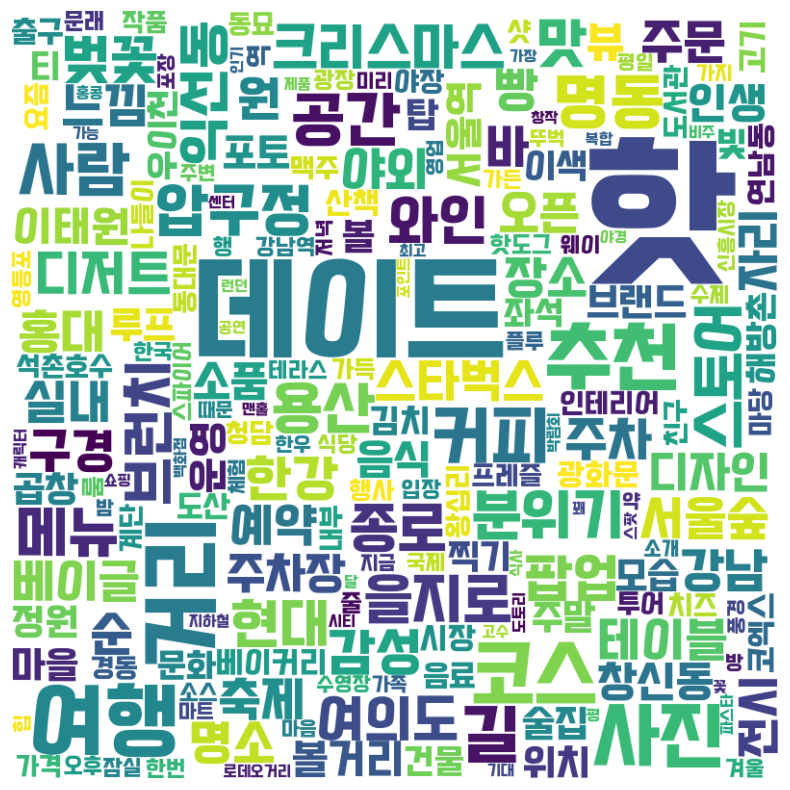

In [3]:
# 최초크롤링 데이터

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Okt
import re

okt = Okt()

# 크롤링한 데이터를 불러옵니다 (최초크롤링 파일을 사용).
# df = pd.read_excel("../data/최초크롤링_24-08-27.xlsx")
df = pd.read_excel("../data/최초크롤링_24-09-04.xlsx")

# 본문 내용과 태그 칼럼을 가져와서 텍스트를 하나로 결합합니다.
text_data = " ".join(df['내용'].dropna()) + " " + " ".join(df['태그'].dropna())

# 텍스트 전처리 (불필요한 특수문자 제거)
text_data = re.sub(r'[^\w\s]', '', text_data)  # 특수문자 제거
text_data = re.sub(r'\d+', '', text_data)  # 숫자 제거

# 불용어 목록 로드
stopwords_file_path = '../data/stopwords-ko.txt'
stopwords_set = load_stopwords(stopwords_file_path)

# 명사 추출
nouns = [word for word, pos in okt.pos(text_data) if pos in ['Noun']]
nouns = get_nouns_from_texts(nouns, stopwords_set)

# 단어 빈도 계산
word_counts = Counter(nouns)

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='../font/Cafe24Ohsquare-v2.0.ttf',  # 한글 폰트 경로 설정
    width=800, 
    height=800,
    background_color='white'
).generate_from_frequencies(word_counts)

# 워드클라우드 시각화
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

mask 변환 방식1


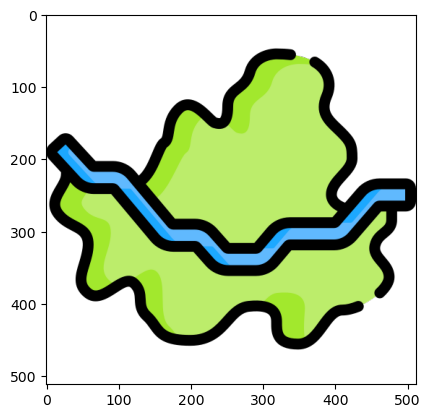

In [4]:
from PIL import Image
import numpy as np
from wordcloud import ImageColorGenerator

image_name = '../img/seoul.PNG'

target_image = Image.open(image_name) 

try:
    mask = Image.new("RGB", target_image.size, (255,255,255))
    mask.paste(target_image,target_image)
    mask = np.array(mask)
    print("mask 변환 방식1")
except:
    print(image_name)
    mask=np.array(Image.open(image_name))
    print("mask 변환 방식2")
finally:
    plt.imshow(target_image)

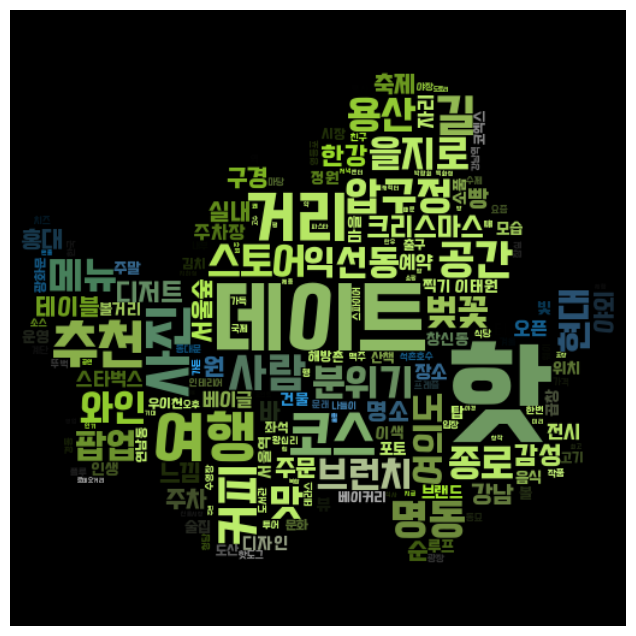

In [5]:
count = Counter(nouns)

wc_seoul = WordCloud(
    font_path='../font/Cafe24Ohsquare-v2.0.ttf',
    mask=mask,
    background_color="black"
)

wc_seoul = wc_seoul.generate_from_frequencies(count)
image_colors=ImageColorGenerator(mask)

plt.figure(figsize=(8,8))
plt.imshow(wc_seoul.recolor(color_func=image_colors),interpolation="bilinear")
plt.axis("off")
plt.show()

output_path = '../img/wordcloud_seoul.png'
wc_seoul.to_file(output_path)

In [16]:
# 추가 크롤링

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
from datetime import datetime
from tqdm import tqdm

def setup_driver():
    """Chrome 드라이버를 설정하고 반환합니다."""
    chrome_driver_path = 'C:\\chromedriver-win64\\chromedriver.exe'
    service = Service(chrome_driver_path)

    options = Options()
    options.add_argument("--disable-notifications")
    options.add_argument("--start-maximized")

    driver = webdriver.Chrome(service=service, options=options)
    return driver

def crawl_blog_posts(search_queries, max_posts_per_query=300, max_pages=10):
    current_time = datetime.now().strftime('%y-%m-%d')
    
    driver = setup_driver()

    all_data = []

    for search_query in search_queries:
        search_query_encoded = search_query.replace(' ', '+')  # 검색어를 URL 인코딩
        url_template = f'https://section.blog.naver.com/Search/Post.naver?pageNo={{}}&rangeType=ALL&orderBy=sim&keyword={search_query_encoded}'
        
        url_list = []
        title_list = []
        seen_urls = set()  # 중복 확인을 위한 집합(Set)

        for page in range(1, max_pages + 1):
            search_url = url_template.format(page)
            driver.get(search_url)
            time.sleep(3)
            
            try:
                # 블로그 글 제목과 URL 수집
                article_raw = driver.find_elements(By.CSS_SELECTOR, '.info_post .desc a')
                
                if not article_raw:
                    print(f"페이지 {page}에서 블로그 포스트를 찾을 수 없습니다.")
                    break
                
                for article in article_raw:
                    url = article.get_attribute('href')
                    
                    # 이미 수집된 URL인지 확인 (중복 제거)
                    if url in seen_urls:
                        continue  # 중복된 URL은 무시
                    
                    seen_urls.add(url)  # 새로운 URL은 집합에 추가
                    
                    title_element = article.find_element(By.XPATH, './strong')
                    title = title_element.text
                    url_list.append(url)
                    title_list.append(title)

                    if len(url_list) >= max_posts_per_query:
                        break
                
                if len(url_list) >= max_posts_per_query:
                    break
            except Exception as e:
                print(f"페이지 {page}에서 오류 발생: {e}")
                continue
        
        # 수집한 URL과 제목을 DataFrame에 저장
        df = pd.DataFrame({'주소': url_list, '제목': title_list})
        
        # 크롤링한 내용을 포함한 DataFrame을 Excel 파일로 저장
        df['검색어'] = search_query
        df['작성일자'] = None
        df['태그'] = None
        df['내용'] = None

        number = len(df)

        for i in tqdm(range(number), desc=f"Crawling: {search_query}"):
            url = df['주소'][i]
            driver.get(url)    
            time.sleep(3)

            try:
                # 블로그 본문 iframe으로 전환
                WebDriverWait(driver, 10).until(
                    EC.frame_to_be_available_and_switch_to_it((By.ID, 'mainFrame'))
                )

                # 제목 추출
                tit = driver.find_element(By.CSS_SELECTOR, '.se-module.se-module-text.se-title-text')
                title = tit.text

                # 날짜 및 시간 추출
                date = driver.find_element(By.CSS_SELECTOR, '.se_publishDate.pcol2')
                datetime_text = date.text

                df.at[i, '작성일자'] = datetime_text

                # 태그 추출
                tags = driver.find_elements(By.CSS_SELECTOR, '.wrap_tag .ell')
                tag_list = [tag.text for tag in tags]
                tag_str = ' '.join(tag_list)
                df.at[i, '태그'] = tag_str

                # 내용 추출
                contents = driver.find_elements(By.CSS_SELECTOR, '.se-module.se-module-text')
                content_list = [content.text for content in contents]
                content_str = ' '.join(content_list)
                df.at[i, '내용'] = content_str

                print(f"{i}번째 글 크롤링 완료: {title}")

            except Exception as e:
                print(f"{i}번째 글에서 오류 발생: {e}")
                continue

        all_data.append(df)

    all_df = pd.concat(all_data, ignore_index=True)
    all_df.to_excel(f"../data/추가크롤링_{current_time}.xlsx", index=False)

    print("수집한 글 갯수:", len(all_df.dropna(subset=['내용'])))

    driver.quit()

# 함수 호출 예제
search_queries = [
    '서울맛집', '서울데이트', '서울여행', '서울추천', '서울사진', '서울거리', '서울커피', '서울코스', '서울공원', '서울명소' 
]
crawl_blog_posts(search_queries, max_posts_per_query=100, max_pages=15)

Crawling: 서울맛집:   1%|▌                                                             | 1/100 [00:05<08:27,  5.12s/it]

0번째 글 크롤링 완료: 여의도 더현대서울 맛집 강호연파 지하1층 샤브집 추천!


Crawling: 서울맛집:   2%|█▏                                                            | 2/100 [00:09<07:50,  4.80s/it]

1번째 글 크롤링 완료: 여의도 더현대 서울 맛집 데이트 IFC몰 근처 고우가 추천


Crawling: 서울맛집:   3%|█▊                                                            | 3/100 [00:13<07:04,  4.38s/it]

2번째 글 크롤링 완료: 여의도 더현대서울 맛집 유방녕 중식당


Crawling: 서울맛집:   4%|██▍                                                           | 4/100 [00:17<06:51,  4.29s/it]

3번째 글 크롤링 완료: 개인적으로 고기가 맛있는 서울 맛집 5개


Crawling: 서울맛집:   5%|███                                                           | 5/100 [00:22<06:48,  4.30s/it]

4번째 글 크롤링 완료: 서울 맛집 부모님 식사 고민말고 설가온


Crawling: 서울맛집:   6%|███▋                                                          | 6/100 [00:25<06:24,  4.09s/it]

5번째 글 크롤링 완료: 더현대서울 맛집 파이브가이즈 햄버거와 양 많은 감자튀김


Crawling: 서울맛집:   7%|████▎                                                         | 7/100 [00:30<06:32,  4.22s/it]

6번째 글 크롤링 완료: 여의도 더현대서울 맛집 식당가 곱창전골 나의가야


Crawling: 서울맛집:   8%|████▉                                                         | 8/100 [00:34<06:32,  4.26s/it]

7번째 글 크롤링 완료: 여의도 더현대서울 맛집 정돈프리미엄 히레카츠 카타로스카츠


Crawling: 서울맛집:   9%|█████▌                                                        | 9/100 [00:38<06:23,  4.22s/it]

8번째 글 크롤링 완료: [더현대서울 맛집 고디바 베이커리] 초콜렉사 화이트말차&우유 가득한 화이트 초콜릿 소라빵 후기


Crawling: 서울맛집:  10%|██████                                                       | 10/100 [00:42<06:14,  4.16s/it]

9번째 글 크롤링 완료: 여의도 더현대서울 맛집 <호우섬 더현대서울점> 솔직후기


Crawling: 서울맛집:  11%|██████▋                                                      | 11/100 [00:47<06:20,  4.27s/it]

10번째 글 크롤링 완료: 서울맛집 한남동 오마카세@ 란포


Crawling: 서울맛집:  12%|███████▎                                                     | 12/100 [00:50<05:59,  4.08s/it]

11번째 글 크롤링 완료: 더현대서울맛집 홍콩음식점 호우섬 메뉴


Crawling: 서울맛집:  13%|███████▉                                                     | 13/100 [00:54<05:43,  3.95s/it]

12번째 글 크롤링 완료: [여의도/더현대서울 맛집] 쫀닥쫀닥 나폴리식 트러플 피자 맛집, ‘이탈리’ + 카페 ‘블루보틀’ (내돈내산)


Crawling: 서울맛집:  14%|████████▌                                                    | 14/100 [00:58<05:33,  3.87s/it]

13번째 글 크롤링 완료: 더현대 서울 맛집 죠죠 오코노미야끼


Crawling: 서울맛집:  15%|█████████▏                                                   | 15/100 [01:01<05:19,  3.76s/it]

14번째 글 크롤링 완료: 여의도 더현대서울 맛집 데이트 IFC몰 근처 고우가 여의도점 주차 팁


Crawling: 서울맛집:  16%|█████████▊                                                   | 16/100 [01:05<05:14,  3.74s/it]

15번째 글 크롤링 완료: 더현대서울 맛집 정돈프리미엄 백화점 갔다가 6층 식당가 방문기


Crawling: 서울맛집:  17%|██████████▎                                                  | 17/100 [01:09<05:07,  3.71s/it]

16번째 글 크롤링 완료: [여의도] 능동미나리 - 서울 맛집 트렌드지수 3위! 능동미나리의 세 번째 점포


Crawling: 서울맛집:  18%|██████████▉                                                  | 18/100 [01:12<04:59,  3.65s/it]

17번째 글 크롤링 완료: 여의도 더현대서울 맛집 정돈 추천 후기


Crawling: 서울맛집:  19%|███████████▌                                                 | 19/100 [01:15<04:49,  3.57s/it]

18번째 글 크롤링 완료: [더현대서울맛집]더현대서울돈까스 여의도맛집 정돈프리미엄


Crawling: 서울맛집:  20%|████████████▏                                                | 20/100 [01:19<04:54,  3.68s/it]

19번째 글 크롤링 완료: 분위기 좋은 더현대서울맛집 이탈리안 레스토랑 본보야지 추천 !


Crawling: 서울맛집:  21%|████████████▊                                                | 21/100 [01:23<04:54,  3.73s/it]

20번째 글 크롤링 완료: 고디바 베이커리 평일 웨이팅 후기 더현대서울 맛집 고디빵


Crawling: 서울맛집:  22%|█████████████▍                                               | 22/100 [01:27<04:51,  3.73s/it]

21번째 글 크롤링 완료: 서울 맛집 스키야키가 예술인 옥소반 마곡본점


Crawling: 서울맛집:  23%|██████████████                                               | 23/100 [01:31<04:55,  3.84s/it]

22번째 글 크롤링 완료: 더현대서울 맛집 피크닉 세트 포장 ' 수티 Sooty '


Crawling: 서울맛집:  24%|██████████████▋                                              | 24/100 [01:35<04:48,  3.80s/it]

23번째 글 크롤링 완료: 더현대서울 맛집 순옥이네 올만에 또간집


Crawling: 서울맛집:  25%|███████████████▎                                             | 25/100 [01:39<04:43,  3.78s/it]

24번째 글 크롤링 완료: 여의도 더현대서울 맛집 브라이튼 스퀘어 1층 뽁 분식 & 생맥주 데이트 추천


Crawling: 서울맛집:  26%|███████████████▊                                             | 26/100 [01:42<04:38,  3.77s/it]

25번째 글 크롤링 완료: [서울맛집] 버터핑거팬케이크 청담점


Crawling: 서울맛집:  27%|████████████████▍                                            | 27/100 [01:46<04:30,  3.70s/it]

26번째 글 크롤링 완료: 더현대서울 맛집_여의도 점심 맛집 수티 로스트치킨


Crawling: 서울맛집:  28%|█████████████████                                            | 28/100 [01:50<04:34,  3.81s/it]

27번째 글 크롤링 완료: 더현대서울맛집 오시 익스프레스


Crawling: 서울맛집:  29%|█████████████████▋                                           | 29/100 [01:54<04:27,  3.77s/it]

28번째 글 크롤링 완료: 더현대서울 맛집 포장 가능한 수티 더현대서울점 피크닉세트


Crawling: 서울맛집:  30%|██████████████████▎                                          | 30/100 [01:57<04:23,  3.76s/it]

29번째 글 크롤링 완료: 더현대서울 맛집 요이벤스프카레 : 다양한 토핑의 스프카레


Crawling: 서울맛집:  31%|██████████████████▉                                          | 31/100 [02:01<04:17,  3.74s/it]

30번째 글 크롤링 완료: 7월 다섯째 주 포토덤프 : 서울 맛집 탐방하기 (충정로 맛집 두툼 & 종로3가 종로진낙지)


Crawling: 서울맛집:  32%|███████████████████▌                                         | 32/100 [02:05<04:14,  3.74s/it]

31번째 글 크롤링 완료: 여의도 더현대 서울 맛집 정육면체 체인점 내고싶은 맛


Crawling: 서울맛집:  33%|████████████████████▏                                        | 33/100 [02:09<04:12,  3.77s/it]

32번째 글 크롤링 완료: 더현대서울맛집 매력적이고 깊은 맛 요이벤스프카레


Crawling: 서울맛집:  34%|████████████████████▋                                        | 34/100 [02:12<04:04,  3.70s/it]

33번째 글 크롤링 완료: 더현대 서울 맛집 야끼소바 전문점 오코노미야끼 맛집 죠죠 추천


Crawling: 서울맛집:  35%|█████████████████████▎                                       | 35/100 [02:17<04:21,  4.02s/it]

34번째 글 크롤링 완료: 여의도 더현대 서울맛집 유방녕 중식 시그너처 B 세트 여의도 데이트 찍먹 추천


Crawling: 서울맛집:  36%|█████████████████████▉                                       | 36/100 [02:20<04:08,  3.88s/it]

35번째 글 크롤링 완료: 여의도 더현대서울 맛집 번패티번 메뉴 인생 수제버거


Crawling: 서울맛집:  37%|██████████████████████▌                                      | 37/100 [02:24<04:04,  3.88s/it]

36번째 글 크롤링 완료: [맛집] 내돈내산 서울맛집 리스트 - 특별한 날 먹기 좋은 1인 5만원 이상 맛집 (2023.ver)


Crawling: 서울맛집:  38%|███████████████████████▏                                     | 38/100 [02:28<03:54,  3.78s/it]

37번째 글 크롤링 완료: 일본 삿포로가 그리워지는 더현대서울 맛집 요이벤스프카레


Crawling: 서울맛집:  39%|███████████████████████▊                                     | 39/100 [02:32<03:54,  3.84s/it]

38번째 글 크롤링 완료: 더현대서울맛집 6F 고급 중식당 ‘도원스타일(桃園)’


Crawling: 서울맛집:  40%|████████████████████████▍                                    | 40/100 [02:35<03:45,  3.77s/it]

39번째 글 크롤링 완료: 더현대서울맛집 여의도맛집추천 오시익스프레스


Crawling: 서울맛집:  41%|█████████████████████████                                    | 41/100 [02:39<03:39,  3.71s/it]

40번째 글 크롤링 완료: [서울 가볼만한 곳/서울여행/서울맛집] 광화문 일민미술관 함박스테이크 맛집 카페이마


Crawling: 서울맛집:  42%|█████████████████████████▌                                   | 42/100 [02:43<03:33,  3.69s/it]

41번째 글 크롤링 완료: 더현대서울 맛집 불향 볶음면 퍼부어 더현대서울점


Crawling: 서울맛집:  43%|██████████████████████████▏                                  | 43/100 [02:47<03:34,  3.76s/it]

42번째 글 크롤링 완료: 서울 맛집 추천 오시오포차 샤로수길술집


Crawling: 서울맛집:  44%|██████████████████████████▊                                  | 44/100 [02:51<03:42,  3.97s/it]

43번째 글 크롤링 완료: 더현대서울 맛집 호우섬: 아이랑 웨이팅 없이 홍콩음식 즐기기


Crawling: 서울맛집:  45%|███████████████████████████▍                                 | 45/100 [02:55<03:33,  3.89s/it]

44번째 글 크롤링 완료: 여의도 삼겹살맛집 고깃집, 더현대서울 맛집 여의화로


Crawling: 서울맛집:  46%|████████████████████████████                                 | 46/100 [02:58<03:26,  3.83s/it]

45번째 글 크롤링 완료: [서울맛집/홍대] 즉떡엔 버갈 _ 또보겠지떡볶이


Crawling: 서울맛집:  47%|████████████████████████████▋                                | 47/100 [03:03<03:29,  3.96s/it]

46번째 글 크롤링 완료: 더현대서울 맛집 요이벤스프카레 더현대서울


Crawling: 서울맛집:  48%|█████████████████████████████▎                               | 48/100 [03:19<06:46,  7.81s/it]

47번째 글 크롤링 완료: 더현대서울 맛집 요이벤스프카레 더현대서울


Crawling: 서울맛집:  49%|█████████████████████████████▉                               | 49/100 [03:23<05:37,  6.61s/it]

48번째 글 크롤링 완료: 훗카이도풍커리 더현대서울 맛집 요이벤스프카레


Crawling: 서울맛집:  50%|██████████████████████████████▌                              | 50/100 [03:27<04:51,  5.82s/it]

49번째 글 크롤링 완료: [맛집] 내돈내산 서울 맛집 리스트 - 캐주얼하게 먹기 좋은 1인 3만원 이하 맛집 (2023.ver)


Crawling: 서울맛집:  51%|███████████████████████████████                              | 51/100 [03:31<04:15,  5.22s/it]

50번째 글 크롤링 완료: 뚝섬역 가성비 맛집 레트로 서울맛집


Crawling: 서울맛집:  52%|███████████████████████████████▋                             | 52/100 [03:35<03:55,  4.91s/it]

51번째 글 크롤링 완료: 여의화로ㅣ여의도삼겹살맛집고기집 더현대서울맛집 찾는다면 여기로 고고


Crawling: 서울맛집:  53%|████████████████████████████████▎                            | 53/100 [03:39<03:35,  4.59s/it]

52번째 글 크롤링 완료: 더현대서울 맛집 요이벤스프카레 더현대서울


Crawling: 서울맛집:  54%|████████████████████████████████▉                            | 54/100 [03:43<03:21,  4.39s/it]

53번째 글 크롤링 완료: [서울 가볼만한 곳/서울여행/서울맛집] 합정 붓카케 우동 소바 맛집 교다이야 웨이팅 메뉴 추천


Crawling: 서울맛집:  55%|█████████████████████████████████▌                           | 55/100 [03:47<03:11,  4.25s/it]

54번째 글 크롤링 완료: 더현대서울맛집 요이벤 스프카레


Crawling: 서울맛집:  56%|██████████████████████████████████▏                          | 56/100 [03:51<03:10,  4.34s/it]

55번째 글 크롤링 완료: 여의도데이트 쌉 더현대서울맛집 SSAP


Crawling: 서울맛집:  57%|██████████████████████████████████▊                          | 57/100 [03:55<02:59,  4.17s/it]

56번째 글 크롤링 완료: 더현대서울 맛집 - 수티


Crawling: 서울맛집:  58%|███████████████████████████████████▍                         | 58/100 [03:59<02:49,  4.04s/it]

57번째 글 크롤링 완료: 더현대서울맛집 쌉 타이 현지맛 그대로 치킨팟타이 추천


Crawling: 서울맛집:  59%|███████████████████████████████████▉                         | 59/100 [04:03<02:48,  4.10s/it]

58번째 글 크롤링 완료: 여의도 더현대 서울 맛집 데이트 IFC몰 근처 룸식당 추천 고우가


Crawling: 서울맛집:  60%|████████████████████████████████████▌                        | 60/100 [04:07<02:36,  3.92s/it]

59번째 글 크롤링 완료: [서울맛집/을지로] 홍스 황금족발


Crawling: 서울맛집:  61%|█████████████████████████████████████▏                       | 61/100 [04:11<02:32,  3.90s/it]

60번째 글 크롤링 완료: [서울 가볼만한 곳/서울여행/서울맛집] 혜화 대학로 베트남 음식점 뎁짜이 대학로점


Crawling: 서울맛집:  62%|█████████████████████████████████████▊                       | 62/100 [04:14<02:27,  3.88s/it]

61번째 글 크롤링 완료: 더현대서울 맛집 [라그릴리아 여의도 파크원점] 파스타 스테이크Set


Crawling: 서울맛집:  63%|██████████████████████████████████████▍                      | 63/100 [04:19<02:29,  4.05s/it]

62번째 글 크롤링 완료: 더현대서울맛집, 요이벤스프카레


Crawling: 서울맛집:  64%|███████████████████████████████████████                      | 64/100 [04:44<06:10, 10.30s/it]

63번째 글 크롤링 완료: 서울가산맛집 보보면 라멘맛집 금천구맛집 서울맛집


Crawling: 서울맛집:  65%|███████████████████████████████████████▋                     | 65/100 [04:48<04:52,  8.36s/it]

64번째 글 크롤링 완료: 여의도 더현대서울맛집 쌉 SSAP 현지느낌 태국음식


Crawling: 서울맛집:  66%|████████████████████████████████████████▎                    | 66/100 [04:52<04:03,  7.15s/it]

65번째 글 크롤링 완료: 서울맛집 :: 신도림 한돈굴보쌈 - 굴보쌈


Crawling: 서울맛집:  67%|████████████████████████████████████████▊                    | 67/100 [04:56<03:23,  6.17s/it]

66번째 글 크롤링 완료: 더현대서울 맛집 요이벤스프카레 삿포로 스프카레


Crawling: 서울맛집:  68%|█████████████████████████████████████████▍                   | 68/100 [04:59<02:52,  5.39s/it]

67번째 글 크롤링 완료: [더현대서울맛집]여의도맛집, 줄서는 식당 맛집 테디뵈르하우스 더현대서울


Crawling: 서울맛집:  69%|██████████████████████████████████████████                   | 69/100 [05:04<02:35,  5.02s/it]

68번째 글 크롤링 완료: 서울맛집. 몽탄 짚불구이


Crawling: 서울맛집:  70%|██████████████████████████████████████████▋                  | 70/100 [05:08<02:21,  4.72s/it]

69번째 글 크롤링 완료: [서울 맛집] 벽제봉피양 신세계 백화점 본점


Crawling: 서울맛집:  71%|███████████████████████████████████████████▎                 | 71/100 [05:11<02:08,  4.43s/it]

70번째 글 크롤링 완료: 더현대 서울 맛집, 죠죠 더현대서울점 지하 1층


Crawling: 서울맛집:  72%|███████████████████████████████████████████▉                 | 72/100 [05:15<02:00,  4.30s/it]

71번째 글 크롤링 완료: 여의도 더현대서울 맛집 마유유 마라탕 마라샹궈 후기


Crawling: 서울맛집:  73%|████████████████████████████████████████████▌                | 73/100 [05:54<06:32, 14.54s/it]

72번째 글 크롤링 완료: 여의도 더현대서울 맛집 데이트 IFC몰 근처 고우가에서 제대로된 오마카세 즐기기


Crawling: 서울맛집:  74%|█████████████████████████████████████████████▏               | 74/100 [05:58<04:56, 11.42s/it]

73번째 글 크롤링 완료: [더현대서울맛집]재료 식감이 살아있는 곳 '요이벤스프커리'


Crawling: 서울맛집:  75%|█████████████████████████████████████████████▊               | 75/100 [06:02<03:50,  9.22s/it]

74번째 글 크롤링 완료: [서울 가볼만한 곳/서울여행/서울맛집] 혜화 대학로 동경식 마제소바 맛집 칸다소바


Crawling: 서울맛집:  76%|██████████████████████████████████████████████▎              | 76/100 [06:06<03:01,  7.58s/it]

75번째 글 크롤링 완료: [서울 맛집] 평양냉면 맛집 “평양면옥 의평옥”


Crawling: 서울맛집:  77%|██████████████████████████████████████████████▉              | 77/100 [06:31<04:57, 12.92s/it]

76번째 글 크롤링 완료: 당근 스토리 이벤트, 서울맛집 공유하면 최대 2만 원! (당근 첫 거래 후기, 당근페이 수수료)


Crawling: 서울맛집:  78%|███████████████████████████████████████████████▌             | 78/100 [06:35<03:44, 10.21s/it]

77번째 글 크롤링 완료: 더현대서울맛집 수티, 로스트치킨과 쉬림프 잠발라야


Crawling: 서울맛집:  79%|████████████████████████████████████████████████▏            | 79/100 [06:39<02:54,  8.32s/it]

78번째 글 크롤링 완료: 더현대맛집 수티 피크닉 세트 후기, 더현대서울 맛집 추천!


Crawling: 서울맛집:  80%|████████████████████████████████████████████████▊            | 80/100 [06:43<02:21,  7.07s/it]

79번째 글 크롤링 완료: 더현대서울 맛집 크로와상 서울빵지순례 테디뵈르하우스


Crawling: 서울맛집:  81%|█████████████████████████████████████████████████▍           | 81/100 [06:47<01:57,  6.19s/it]

80번째 글 크롤링 완료: 더현대서울맛집 테디뵈르하우스 빵 폭식한 후기


Crawling: 서울맛집:  82%|██████████████████████████████████████████████████           | 82/100 [06:51<01:39,  5.52s/it]

81번째 글 크롤링 완료: [서울맛집] 망리단길 발리인망원 다녀온 후기


Crawling: 서울맛집:  83%|██████████████████████████████████████████████████▋          | 83/100 [06:55<01:25,  5.00s/it]

82번째 글 크롤링 완료: 더현대서울맛집 요이벤스프카레 더현대서울점 삿포로풍 카레맛집 후기


Crawling: 서울맛집:  84%|███████████████████████████████████████████████████▏         | 84/100 [06:59<01:14,  4.69s/it]

83번째 글 크롤링 완료: 간편하게 즐기는 더현대서울맛집 요이벤 스프카레


Crawling: 서울맛집:  85%|███████████████████████████████████████████████████▊         | 85/100 [07:03<01:06,  4.41s/it]

84번째 글 크롤링 완료: [서울 가볼만한 곳/서울여행/서울맛집] 광화문 삼계탕집 맛집 장수한방삼계탕


Crawling: 서울맛집:  86%|████████████████████████████████████████████████████▍        | 86/100 [07:06<00:58,  4.20s/it]

85번째 글 크롤링 완료: [서울 맛집] 오구반점


Crawling: 서울맛집:  87%|█████████████████████████████████████████████████████        | 87/100 [07:29<02:06,  9.72s/it]

86번째 글 크롤링 완료: 더현대서울 맛집 퍼부어 리얼 베트남 쌀국수 데이트


Crawling: 서울맛집:  88%|█████████████████████████████████████████████████████▋       | 88/100 [07:33<01:35,  7.94s/it]

87번째 글 크롤링 완료: 서울맛집 이도곰탕


Crawling: 서울맛집:  89%|██████████████████████████████████████████████████████▎      | 89/100 [07:37<01:13,  6.72s/it]

88번째 글 크롤링 완료: 오시익스프레스 더현대서울점 feat. 더현대서울맛집, 여의도맛집추천


Crawling: 서울맛집:  90%|██████████████████████████████████████████████████████▉      | 90/100 [07:59<01:54, 11.50s/it]

89번째 글 크롤링 완료: 서울 서울역 2층에 있는 흔하면서도 흔하지 않은 맛집 밀본 서울맛집 서울역맛집 미슐랭가이드 한국맛집


Crawling: 서울맛집:  91%|███████████████████████████████████████████████████████▌     | 91/100 [08:03<01:23,  9.24s/it]

90번째 글 크롤링 완료: 여의도 더현대서울맛집 칠암만장서울역안카페 무안


Crawling: 서울맛집:  92%|████████████████████████████████████████████████████████     | 92/100 [08:08<01:03,  7.93s/it]

91번째 글 크롤링 완료: [서울/신촌] 서울맛집 뽁식당 신촌점 신촌맛집


Crawling: 서울맛집:  93%|████████████████████████████████████████████████████████▋    | 93/100 [08:12<00:46,  6.65s/it]

92번째 글 크롤링 완료: [서울맛집] 깔끔한 한식 한상을 먹을 수 있는 "온미관 안국"


Crawling: 서울맛집:  94%|█████████████████████████████████████████████████████████▎   | 94/100 [08:15<00:34,  5.73s/it]

93번째 글 크롤링 완료: 서울 맛집 지도 일러스트 (ft. 송송책방)


Crawling: 서울맛집:  95%|█████████████████████████████████████████████████████████▉   | 95/100 [08:19<00:25,  5.17s/it]

94번째 글 크롤링 완료: 더현대서울 맛집, 북해도 스프카레 전문점 요이벤 스프카레


Crawling: 서울맛집:  96%|██████████████████████████████████████████████████████████▌  | 96/100 [08:23<00:19,  4.83s/it]

95번째 글 크롤링 완료: 서울맛집. 삼원가든


Crawling: 서울맛집:  97%|███████████████████████████████████████████████████████████▏ | 97/100 [08:27<00:13,  4.61s/it]

96번째 글 크롤링 완료: 서울맛집 브루클린더버거조인트


Crawling: 서울맛집:  98%|███████████████████████████████████████████████████████████▊ | 98/100 [08:31<00:08,  4.34s/it]

97번째 글 크롤링 완료: [서울맛집/신길동맛집]신길동별난아찌짬뽕_매운짬뽕, 짜장면, 김밥


Crawling: 서울맛집:  99%|████████████████████████████████████████████████████████████▍| 99/100 [08:35<00:04,  4.28s/it]

98번째 글 크롤링 완료: 서울맛집 멜팅샵치즈룸


Crawling: 서울맛집: 100%|████████████████████████████████████████████████████████████| 100/100 [08:58<00:00,  5.39s/it]

99번째 글 크롤링 완료: [여의도 최고의 분위기와 구워주는 삼겹살 고기집] 여의도회식장소더현대 서울맛집 여의도삼겹살 여의도 맛집 여의화로 직영점



Crawling: 서울데이트:   1%|▌                                                           | 1/100 [00:04<07:37,  4.62s/it]

0번째 글 크롤링 완료: 서울 데이트 한강 텐트 뚝섬 한강공원 텐트존 대여


Crawling: 서울데이트:   2%|█▏                                                          | 2/100 [00:08<07:10,  4.39s/it]

1번째 글 크롤링 완료: 강남 오마카세 맛집 서울 데이트 장소 스시센몬 디너


Crawling: 서울데이트:   3%|█▊                                                          | 3/100 [00:13<07:00,  4.34s/it]

2번째 글 크롤링 완료: 서울 노들섬 피크닉 대여 "노들노들 피크닉" 배달 음식 위치, 한강 데이트


Crawling: 서울데이트:   4%|██▍                                                         | 4/100 [00:17<06:41,  4.19s/it]

3번째 글 크롤링 완료: 성수파스타맛집 서울 브런치 데이트 성수다락


Crawling: 서울데이트:   5%|███                                                         | 5/100 [00:21<06:28,  4.09s/it]

4번째 글 크롤링 완료: 잠실맛집 서울데이트 '쌤쌤쌤 롯데월드몰점'


Crawling: 서울데이트:   6%|███▌                                                        | 6/100 [00:25<06:47,  4.33s/it]

5번째 글 크롤링 완료: 서울 데이트코스 노보텔 앰배서더 서울 강남 호텔빙수추천 애플망고빙수 맛집


Crawling: 서울데이트:   7%|████▏                                                       | 7/100 [00:29<06:26,  4.16s/it]

6번째 글 크롤링 완료: 용산맛집 이국적인 느낌의 쌤쌤쌤 서울데이트맛집


Crawling: 서울데이트:   8%|████▊                                                       | 8/100 [00:34<06:32,  4.26s/it]

7번째 글 크롤링 완료: 잠실맛집 쌤쌤쌤 롯데월드몰점 서울데이트 하기좋은 파스타맛집


Crawling: 서울데이트:   9%|█████▍                                                      | 9/100 [00:38<06:38,  4.38s/it]

8번째 글 크롤링 완료: 서울데이트코스 추천 도심 속 자연 평창동 더피아노 카페


Crawling: 서울데이트:  10%|█████▉                                                     | 10/100 [00:42<06:22,  4.25s/it]

9번째 글 크롤링 완료: 서울 여행 노을 명소 노들섬 한강공원 일몰 피크닉 데이트 추천


Crawling: 서울데이트:  11%|██████▍                                                    | 11/100 [00:49<07:19,  4.94s/it]

10번째 글 크롤링 완료: 딸과 함께♡ 더현대서울 데이트


Crawling: 서울데이트:  12%|███████                                                    | 12/100 [00:53<06:53,  4.69s/it]

11번째 글 크롤링 완료: 밤낚시 영화 특별 전시! 현대 모터스튜디오 서울 강남 놀거리 이색 데이트


Crawling: 서울데이트:  13%|███████▋                                                   | 13/100 [00:57<06:42,  4.63s/it]

12번째 글 크롤링 완료: 서울향수공방, 잠실놀거리, 잠실실내데이트 - 라오크


Crawling: 서울데이트:  14%|████████▎                                                  | 14/100 [01:01<06:23,  4.46s/it]

13번째 글 크롤링 완료: 서울 데이트 장소 추천 뉴뉴 명동 소품샵 투어 핫플


Crawling: 서울데이트:  15%|████████▊                                                  | 15/100 [01:06<06:13,  4.39s/it]

14번째 글 크롤링 완료: 서울전시회 가볼만한곳 압구정로데오 K현대미술관 "파리의 휴일" 실내데이트 후기


Crawling: 서울데이트:  16%|█████████▍                                                 | 16/100 [01:10<06:05,  4.36s/it]

15번째 글 크롤링 완료: 서울역 데이트 실내 놀거리 문화역서울284 무료 전시 예약


Crawling: 서울데이트:  17%|██████████                                                 | 17/100 [01:14<05:56,  4.29s/it]

16번째 글 크롤링 완료: 서초 교대역맛집 미테이블 서울데이트코스 추천


Crawling: 서울데이트:  18%|██████████▌                                                | 18/100 [01:19<05:59,  4.38s/it]

17번째 글 크롤링 완료: 서울 실내 데이트 가볼만한곳 청와대 사랑채 연화 특별전


Crawling: 서울데이트:  19%|███████████▏                                               | 19/100 [01:22<05:41,  4.22s/it]

18번째 글 크롤링 완료: [감정선프로젝트 익선동점] 모루인형만들러 갔다. 내돈내산 서울 이색데이트


Crawling: 서울데이트:  20%|███████████▊                                               | 20/100 [01:27<05:43,  4.30s/it]

19번째 글 크롤링 완료: 서울근교 나들이 여름 야외 데이트 체험형 동물원 데이트 갈만한곳


Crawling: 서울데이트:  21%|████████████▍                                              | 21/100 [01:31<05:45,  4.38s/it]

20번째 글 크롤링 완료: 을지로 놀거리 을지로3가 소품샵 가볼만한곳 서울 데이트 코스


Crawling: 서울데이트:  22%|████████████▉                                              | 22/100 [01:36<05:52,  4.52s/it]

21번째 글 크롤링 완료: 서울 강동구 맛집 쿠우쿠우 골드 강동점 데이트부터 모임까지 퀄리티, 가성비 다 잡은 천호동 뷔페 맛집


Crawling: 서울데이트:  23%|█████████████▌                                             | 23/100 [01:40<05:31,  4.31s/it]

22번째 글 크롤링 완료: 서울 실내데이트 추천 대학로 연극 늘근도둑 이야기 내돈내산 후기 혜화역 근처


Crawling: 서울데이트:  24%|██████████████▏                                            | 24/100 [01:44<05:19,  4.21s/it]

23번째 글 크롤링 완료: 서울 핫플 이태원 해방촌 신흥시장 데이트 가볼만한곳 미슐랭 맛집과 카페 코스


Crawling: 서울데이트:  25%|██████████████▊                                            | 25/100 [01:48<05:12,  4.17s/it]

24번째 글 크롤링 완료: 상수역 맛집 서울데이트 코스로 좋은 멕시카고 타코23


Crawling: 서울데이트:  26%|███████████████▎                                           | 26/100 [01:52<05:10,  4.19s/it]

25번째 글 크롤링 완료: 서울 한우 오마카세 데이트 여의도 한식 맛집 저녁 룸식당 회식


Crawling: 서울데이트:  27%|███████████████▉                                           | 27/100 [01:56<05:00,  4.12s/it]

26번째 글 크롤링 완료: 서울 실내 가볼만한곳 데이트 추천 서울 볼거리 뮤지컬 아이스쇼 지쇼 더루나


Crawling: 서울데이트:  28%|████████████████▌                                          | 28/100 [02:01<05:01,  4.18s/it]

27번째 글 크롤링 완료: 서울 카페 신당동 핫플 데이트 코스 "메일룸 신당" 찐 솔직후기


Crawling: 서울데이트:  29%|█████████████████                                          | 29/100 [02:05<04:52,  4.11s/it]

28번째 글 크롤링 완료: 신도림와인바 샤퀴테리 서울 언니랑 단둘이 데이트!


Crawling: 서울데이트:  30%|█████████████████▋                                         | 30/100 [02:09<04:47,  4.10s/it]

29번째 글 크롤링 완료: 서울 실내 데이트 LG유플러스 일상의틈 노원 K-POP 뉴진스 BTS 팝업스토어


Crawling: 서울데이트:  31%|██████████████████▎                                        | 31/100 [02:13<04:42,  4.10s/it]

30번째 글 크롤링 완료: 서울 데이트 가볼만한 곳 신흥시장 해방촌 맛집 콕콕


Crawling: 서울데이트:  32%|██████████████████▉                                        | 32/100 [02:17<04:48,  4.25s/it]

31번째 글 크롤링 완료: 서울 홍대 놀거리 best3 실내 데이트 가볼만한곳


Crawling: 서울데이트:  33%|███████████████████▍                                       | 33/100 [02:21<04:35,  4.11s/it]

32번째 글 크롤링 완료: 더현대 서울 데이트, 테쿠루 타코야끼와 하이틴컨셉 인생네컷 포토그램 사진관 후기


Crawling: 서울데이트:  34%|████████████████████                                       | 34/100 [02:25<04:33,  4.14s/it]

33번째 글 크롤링 완료: 서울 여행일정 밤 놀거리 청계천 청계광장 서울데이트


Crawling: 서울데이트:  35%|████████████████████▋                                      | 35/100 [02:30<04:33,  4.21s/it]

34번째 글 크롤링 완료: 광화문책마당 달빛낭만극장 영화 서울 데이트 가볼만한곳 추천 후기!


Crawling: 서울데이트:  36%|█████████████████████▏                                     | 36/100 [02:34<04:29,  4.21s/it]

35번째 글 크롤링 완료: 서울 주말 데이트 종로 독립문역 행사 가볼만한곳 신묘한저잣거리


Crawling: 서울데이트:  37%|█████████████████████▊                                     | 37/100 [02:39<04:31,  4.31s/it]

36번째 글 크롤링 완료: 서울핫플 데이트하기 좋은 광화문책마당 달빛낭만극장


Crawling: 서울데이트:  38%|██████████████████████▍                                    | 38/100 [02:43<04:29,  4.34s/it]

37번째 글 크롤링 완료: 6월 서울 가볼만한곳 영등포 공원 문래창작촌 데이트 코스


Crawling: 서울데이트:  39%|███████████████████████                                    | 39/100 [02:47<04:21,  4.28s/it]

38번째 글 크롤링 완료: 건대 실내 데이트코스 서울 건대입구 커먼그라운드 주차


Crawling: 서울데이트:  40%|███████████████████████▌                                   | 40/100 [02:51<04:11,  4.19s/it]

39번째 글 크롤링 완료: 서울 시립 남서울 미술관 사당놀거리 데이트


Crawling: 서울데이트:  41%|████████████████████████▏                                  | 41/100 [02:55<04:01,  4.10s/it]

40번째 글 크롤링 완료: 서울 데이트 식당 맛있게 점심 먹기 좋은 핫플 맛집!


Crawling: 서울데이트:  42%|████████████████████████▊                                  | 42/100 [02:59<03:58,  4.10s/it]

41번째 글 크롤링 완료: 서울 데이트 연희동 브런치 맛집그로어스


Crawling: 서울데이트:  43%|█████████████████████████▎                                 | 43/100 [03:03<03:54,  4.11s/it]

42번째 글 크롤링 완료: 서울 이색 실내 데이트코스 추천, 커플 마사지 로맨틱하게 피로 풀기! 힐링포미아로마


Crawling: 서울데이트:  44%|█████████████████████████▉                                 | 44/100 [03:07<03:50,  4.12s/it]

43번째 글 크롤링 완료: 서순라길 위치 가는법 전현무 타코 서울 데이트 가볼만한곳


Crawling: 서울데이트:  45%|██████████████████████████▌                                | 45/100 [03:11<03:41,  4.02s/it]

44번째 글 크롤링 완료: 잠실 석촌호수 서울 여름 가볼만한곳 데이트 코스


Crawling: 서울데이트:  46%|███████████████████████████▏                               | 46/100 [03:15<03:39,  4.06s/it]

45번째 글 크롤링 완료: 9월 서울 데이트 코스 추천 노들섬 한강공원 주차 인생사진 담기


Crawling: 서울데이트:  47%|███████████████████████████▋                               | 47/100 [03:20<03:49,  4.33s/it]

46번째 글 크롤링 완료: 서울시내 가볼만한곳 실내 데이트 여행코스 BEST5


Crawling: 서울데이트:  48%|████████████████████████████▎                              | 48/100 [03:24<03:38,  4.20s/it]

47번째 글 크롤링 완료: 서울역 데이트 놀거리 용산구 핫플 후암동 맛집 가마솥족발순대국


Crawling: 서울데이트:  49%|████████████████████████████▉                              | 49/100 [03:28<03:33,  4.18s/it]

48번째 글 크롤링 완료: 서울 데이트 장소 남산 서울타워 여행정보 총정리, 케이블카 야경구경 봉수대까지


Crawling: 서울데이트:  50%|█████████████████████████████▌                             | 50/100 [03:33<03:31,  4.23s/it]

49번째 글 크롤링 완료: 서울데이트 K현대미술관 파리의 휴일 전시 후기 🤍


Crawling: 서울데이트:  51%|██████████████████████████████                             | 51/100 [03:37<03:27,  4.24s/it]

50번째 글 크롤링 완료: 서울 실내 데이트 놀거리 이태원 파티룸 서울 프라이빗 영화관


Crawling: 서울데이트:  52%|██████████████████████████████▋                            | 52/100 [03:41<03:18,  4.14s/it]

51번째 글 크롤링 완료: 서울 데이트 가볼만한곳 영등포 베르데 문래 브런치 카페


Crawling: 서울데이트:  53%|███████████████████████████████▎                           | 53/100 [03:47<03:38,  4.65s/it]

52번째 글 크롤링 완료: 어느날 서울 데이트 / 소피텔 / 화덕 고깃간 / 카토 / 쉑쉑버거


Crawling: 서울데이트:  54%|███████████████████████████████▊                           | 54/100 [03:51<03:28,  4.53s/it]

53번째 글 크롤링 완료: 스타벅스 더북한산점 서울 데이트 장소 추천


Crawling: 서울데이트:  55%|████████████████████████████████▍                          | 55/100 [03:55<03:17,  4.40s/it]

54번째 글 크롤링 완료: 강남역 파인다이닝 레스토랑 녘 서울 데이트코스


Crawling: 서울데이트:  56%|█████████████████████████████████                          | 56/100 [03:59<03:12,  4.39s/it]

55번째 글 크롤링 완료: 서울 데이트 맛집 리스트 추천 모음


Crawling: 서울데이트:  57%|█████████████████████████████████▋                         | 57/100 [04:06<03:41,  5.14s/it]

56번째 글 크롤링 완료: 잠실 놀거리 2024 파리올림픽 굿즈 만나는 롯데백화점 팝업 서울 실내 데이트 추천


Crawling: 서울데이트:  58%|██████████████████████████████████▏                        | 58/100 [04:10<03:23,  4.84s/it]

57번째 글 크롤링 완료: 광화문 디타워 맛집 광화문석갈비 신메뉴 캘리포니아 호두 서울 데이트 룸식당


Crawling: 서울데이트:  59%|██████████████████████████████████▊                        | 59/100 [04:15<03:10,  4.65s/it]

58번째 글 크롤링 완료: 서울 데이트 주말 나들이 코엑스 놀거리 코엑스 아쿠아리움


Crawling: 서울데이트:  60%|███████████████████████████████████▍                       | 60/100 [04:19<02:58,  4.46s/it]

59번째 글 크롤링 완료: 서울 낮술 성수동 맛집 핫플 데이트코스 추천 놀거리 가볼만한곳 아오미


Crawling: 서울데이트:  61%|███████████████████████████████████▉                       | 61/100 [04:23<02:54,  4.46s/it]

60번째 글 크롤링 완료: 서울 강남역 신분당선 핫플 맛집 데이트 놀거리 가볼만한곳 청간막국수


Crawling: 서울데이트:  62%|████████████████████████████████████▌                      | 62/100 [04:29<03:02,  4.80s/it]

61번째 글 크롤링 완료: 서울 강남 핫플 데이트 가볼만한곳 선릉역 양고기수육 맛집 미쓰양꼬치


Crawling: 서울데이트:  63%|█████████████████████████████████████▏                     | 63/100 [04:33<02:52,  4.66s/it]

62번째 글 크롤링 완료: N서울타워 남산타워 서울 데이트코스 추천


Crawling: 서울데이트:  64%|█████████████████████████████████████▊                     | 64/100 [04:37<02:39,  4.44s/it]

63번째 글 크롤링 완료: 서울 데이트 경동시장 금성전파사 새로고침센터 방탈출 예약방법까지


Crawling: 서울데이트:  65%|██████████████████████████████████████▎                    | 65/100 [04:41<02:28,  4.23s/it]

64번째 글 크롤링 완료: 서울 건대커먼그라운드 놀거리 데이트코스 였던 수제탭맥주 폐업


Crawling: 서울데이트:  66%|██████████████████████████████████████▉                    | 66/100 [04:45<02:20,  4.13s/it]

65번째 글 크롤링 완료: 레이나그라피 서울 데이트스냅 촬영후기


Crawling: 서울데이트:  67%|███████████████████████████████████████▌                   | 67/100 [04:50<02:26,  4.45s/it]

66번째 글 크롤링 완료: 8월 서울 가볼만한곳 서울야외도서관 여름밤 공연 데이트


Crawling: 서울데이트:  68%|████████████████████████████████████████                   | 68/100 [04:54<02:16,  4.28s/it]

67번째 글 크롤링 완료: 서울 잠실 데이트 가볼만한곳 롯데월드몰 브런치 카페 어바웃프로젝트라운지


Crawling: 서울데이트:  69%|████████████████████████████████████████▋                  | 69/100 [04:58<02:13,  4.31s/it]

68번째 글 크롤링 완료: [파주] 서울근교 실내데이트추천 미메시스 아트뮤지엄/도슨트 프로그램


Crawling: 서울데이트:  70%|█████████████████████████████████████████▎                 | 70/100 [05:03<02:12,  4.42s/it]

69번째 글 크롤링 완료: 서울 홍대 연남동 핫플 맛집 데이트코스 놀거리 가볼만한곳 이자카야 준무


Crawling: 서울데이트:  71%|█████████████████████████████████████████▉                 | 71/100 [05:07<02:09,  4.48s/it]

70번째 글 크롤링 완료: 서울 성수동 핫플 맛집 데이트코스 놀거리 가볼만한곳 추천 남짐릇


Crawling: 서울데이트:  72%|██████████████████████████████████████████▍                | 72/100 [05:12<02:03,  4.40s/it]

71번째 글 크롤링 완료: 종로 서순라길 위치 피맥 전현무 가맥집 서울 데이트코스


Crawling: 서울데이트:  73%|███████████████████████████████████████████                | 73/100 [05:15<01:52,  4.16s/it]

72번째 글 크롤링 완료: 서울 남산공원 타워 야경 둘레길 산책로 러닝 자물쇠 데이트코스


Crawling: 서울데이트:  74%|███████████████████████████████████████████▋               | 74/100 [05:19<01:45,  4.06s/it]

73번째 글 크롤링 완료: 국내맛집여행 서울카페 왕십리데이트 가볼만한곳 브라운팟 베이커리


Crawling: 서울데이트:  75%|████████████████████████████████████████████▎              | 75/100 [05:23<01:41,  4.06s/it]

74번째 글 크롤링 완료: 홍대 재즈바 뉴올재즈라운지 서울 데이트코스


Crawling: 서울데이트:  76%|████████████████████████████████████████████▊              | 76/100 [05:27<01:37,  4.05s/it]

75번째 글 크롤링 완료: 서울데이트 강남원데이클래스 가족팔찌만들기 프랑꼬아트랩


Crawling: 서울데이트:  77%|█████████████████████████████████████████████▍             | 77/100 [05:32<01:36,  4.18s/it]

76번째 글 크롤링 완료: 서울 시내 가볼만한곳 데이트 서울 역사박물관 전시 예약


Crawling: 서울데이트:  78%|██████████████████████████████████████████████             | 78/100 [05:36<01:33,  4.24s/it]

77번째 글 크롤링 완료: 서울 강남 핫플 맛집 데이트 가볼만한곳 놀거리 선릉역 맛집 오징어풍경


Crawling: 서울데이트:  79%|██████████████████████████████████████████████▌            | 79/100 [05:41<01:36,  4.61s/it]

78번째 글 크롤링 완료: 서울 데이트 전시회 아메리칸 팝아트 거장전 인사동 놀거리


Crawling: 서울데이트:  80%|███████████████████████████████████████████████▏           | 80/100 [05:46<01:29,  4.46s/it]

79번째 글 크롤링 완료: [서울 여행/맛집] 용산 데이트 코스 난포한남 및 DAY ROW 카페 추천 / 내돈내산


Crawling: 서울데이트:  81%|███████████████████████████████████████████████▊           | 81/100 [05:50<01:22,  4.34s/it]

80번째 글 크롤링 완료: 더현대서울 맛집 퍼부어 리얼 베트남 쌀국수 데이트


Crawling: 서울데이트:  82%|████████████████████████████████████████████████▍          | 82/100 [05:54<01:19,  4.41s/it]

81번째 글 크롤링 완료: 서울 전시회 8월 추천 ㅣ 더위 피해 즐기는 시원한 실내 데이트


Crawling: 서울데이트:  83%|████████████████████████████████████████████████▉          | 83/100 [05:58<01:13,  4.35s/it]

82번째 글 크롤링 완료: 서울라이트 ddp 2024 야간 데이트 서울 야경 볼거리


Crawling: 서울데이트:  84%|█████████████████████████████████████████████████▌         | 84/100 [06:03<01:11,  4.48s/it]

83번째 글 크롤링 완료: 뚠뚠여지도 193번째 여정 강남 데이트 장소 추천 디저트 오마카세 맛집 문화시민 서울 방문 후기


Crawling: 서울데이트:  85%|██████████████████████████████████████████████████▏        | 85/100 [06:07<01:04,  4.31s/it]

84번째 글 크롤링 완료: 서울 사찰 유명한 절 강남 코엑스 주변 놀거리 데이트 가볼만한곳 봉은사


Crawling: 서울데이트:  86%|██████████████████████████████████████████████████▋        | 86/100 [06:11<00:59,  4.26s/it]

85번째 글 크롤링 완료: 서울 여행, 한강 데이트로 가볼 만한 놀거리 :: 난지 물놀이장, 반포 튜브스터, 뚝섬 선셋 카약, 한강 해치카


Crawling: 서울데이트:  87%|███████████████████████████████████████████████████▎       | 87/100 [06:15<00:53,  4.15s/it]

86번째 글 크롤링 완료: 서울 동대문성곽공원 놀거리 데이트 가볼만한곳 디자인플라자 DDP


Crawling: 서울데이트:  88%|███████████████████████████████████████████████████▉       | 88/100 [06:19<00:47,  3.98s/it]

87번째 글 크롤링 완료: 서울 이태원 놀거리 올리에띠 가죽공방 원데이클래스 실내데이트코스추천


Crawling: 서울데이트:  89%|████████████████████████████████████████████████████▌      | 89/100 [06:23<00:45,  4.12s/it]

88번째 글 크롤링 완료: 서울 강남 신논현역 핫플 맛집 가볼만한곳 데이트 놀거리 뜨돈돈까스


Crawling: 서울데이트:  90%|█████████████████████████████████████████████████████      | 90/100 [06:27<00:40,  4.04s/it]

89번째 글 크롤링 완료: 서울 성수역 놀거리 성수동 핫플 소품샵 데이트코스 가볼만한곳 팝업스토어


Crawling: 서울데이트:  91%|█████████████████████████████████████████████████████▋     | 91/100 [06:32<00:38,  4.27s/it]

90번째 글 크롤링 완료: 서울 전시회 프랑스 현대 사진전 광화문 데이트 코스


Crawling: 서울데이트:  92%|██████████████████████████████████████████████████████▎    | 92/100 [06:36<00:34,  4.25s/it]

91번째 글 크롤링 완료: 8월 서울 가볼만한곳 더현대서울 시원한 실내 서울 데이트 추천


Crawling: 서울데이트:  93%|██████████████████████████████████████████████████████▊    | 93/100 [06:40<00:29,  4.17s/it]

92번째 글 크롤링 완료: 서울 여름 실내 데이트 장소 잠실 롯데월드몰 랑데자뷰 카페


Crawling: 서울데이트:  94%|███████████████████████████████████████████████████████▍   | 94/100 [06:44<00:24,  4.06s/it]

93번째 글 크롤링 완료: 서울데이트코스 서순라길 맛집


Crawling: 서울데이트:  95%|████████████████████████████████████████████████████████   | 95/100 [06:48<00:20,  4.06s/it]

94번째 글 크롤링 완료: 서울여행지추천 성수 팝업스토어 핫플 데이트코스 놀거리 가볼만한곳


Crawling: 서울데이트:  96%|████████████████████████████████████████████████████████▋  | 96/100 [06:51<00:15,  3.93s/it]

95번째 글 크롤링 완료: 서울 데이트코스 추천 이태원 올리에띠 가죽공방 원데이클래스


Crawling: 서울데이트:  97%|█████████████████████████████████████████████████████████▏ | 97/100 [06:56<00:11,  3.97s/it]

96번째 글 크롤링 완료: 팀홀튼 선릉역점 강남 조용한 카페 서울 주말 데이트 (인기음료)


Crawling: 서울데이트:  98%|█████████████████████████████████████████████████████████▊ | 98/100 [06:59<00:07,  3.95s/it]

97번째 글 크롤링 완료: 8월 서울 가볼만한곳 여름 데이트 놀거리 볼거리 BEST3


Crawling: 서울데이트:  99%|██████████████████████████████████████████████████████████▍| 99/100 [07:03<00:03,  3.95s/it]

98번째 글 크롤링 완료: 서울 북촌 한옥마을 데이트 가볼만한곳 산책 (안국 사월의물고기 웨이팅)


Crawling: 서울데이트: 100%|██████████████████████████████████████████████████████████| 100/100 [07:07<00:00,  4.28s/it]

99번째 글 크롤링 완료: 잠실 롯데월드몰 보노보노 팝업스토어 서울 실내데이트 가볼만한곳



Crawling: 서울여행:   1%|▌                                                             | 1/100 [00:03<06:23,  3.88s/it]

0번째 글 크롤링 완료: [서울여행 숙소 후기] 토요코인 영등포지점 외


Crawling: 서울여행:   2%|█▏                                                            | 2/100 [00:08<06:51,  4.20s/it]

1번째 글 크롤링 완료: [서울 호캉스 호텔 신라스테이 광화문] 서울여행 할 때 제격인 위치


Crawling: 서울여행:   3%|█▊                                                            | 3/100 [00:13<07:12,  4.46s/it]

2번째 글 크롤링 완료: 초등 아이와 서울여행 잠실 롯데월드몰 실내 데이트 코스 추천


Crawling: 서울여행:   4%|██▍                                                           | 4/100 [00:30<15:06,  9.44s/it]

3번째 글 크롤링 완료: 서울 여행 뚝섬 한강공원 국제 정원박람회 서울 나들이


Crawling: 서울여행:   5%|███                                                           | 5/100 [00:33<11:41,  7.39s/it]

4번째 글 크롤링 완료: 영유아 무료 서울여행 다누림 투어 밴 예약 방법 조건


Crawling: 서울여행:   6%|███▋                                                          | 6/100 [00:37<09:42,  6.20s/it]

5번째 글 크롤링 완료: 서울 여행 국립중앙박물관 아이들은 도슨트 어른들은 관람


Crawling: 서울여행:   7%|████▎                                                         | 7/100 [00:41<08:19,  5.37s/it]

6번째 글 크롤링 완료: 1박2일 서울 여행


Crawling: 서울여행:   8%|████▉                                                         | 8/100 [00:45<07:23,  4.82s/it]

7번째 글 크롤링 완료: 3일간의 서울여행 3, 선릉역 클럽케이 찜질방 숙박기


Crawling: 서울여행:   9%|█████▌                                                        | 9/100 [00:48<06:52,  4.53s/it]

8번째 글 크롤링 완료: 서울 여행 노을 명소 노들섬 한강공원 일몰 피크닉 데이트 추천


Crawling: 서울여행:  10%|██████                                                       | 10/100 [00:53<06:43,  4.49s/it]

9번째 글 크롤링 완료: 서울여행 아이랑 함께 보기 좋은 가족뮤지컬 페인터즈 서대문 전용관


Crawling: 서울여행:  11%|██████▋                                                      | 11/100 [00:57<06:36,  4.46s/it]

10번째 글 크롤링 완료: 07/31 아이랑 2박 3일 서울 여행


Crawling: 서울여행:  12%|███████▎                                                     | 12/100 [01:02<06:34,  4.48s/it]

11번째 글 크롤링 완료: 서울 렌트카 추천 쏘카 타고 1박2일 서울 여행 코스


Crawling: 서울여행:  13%|███████▉                                                     | 13/100 [01:06<06:14,  4.30s/it]

12번째 글 크롤링 완료: 서울 여행, 서울시티투어 타이거 버스로 여행한 후기


Crawling: 서울여행:  14%|████████▌                                                    | 14/100 [01:10<06:02,  4.21s/it]

13번째 글 크롤링 완료: 서울여행숙소 '신라스테이 마포' 스탠다드 할리우드 더블 내돈내산 숙박리뷰


Crawling: 서울여행:  15%|█████████▏                                                   | 15/100 [01:14<05:48,  4.11s/it]

14번째 글 크롤링 완료: 서울 여행 코스 창덕궁 후원 비원 창경궁 주말 나들이


Crawling: 서울여행:  16%|█████████▊                                                   | 16/100 [01:18<05:43,  4.09s/it]

15번째 글 크롤링 완료: 서울 올림픽파크텔 아이와 서울여행 롯데월드 근처 숙소 가성비 호텔 추천 조식맛집


Crawling: 서울여행:  17%|██████████▎                                                  | 17/100 [01:22<05:40,  4.11s/it]

16번째 글 크롤링 완료: 서울여행 가성비 호캉스 호텔 추천 신라스테이 구로 스탠다드트윈 후기


Crawling: 서울여행:  18%|██████████▉                                                  | 18/100 [01:26<05:33,  4.07s/it]

17번째 글 크롤링 완료: 서울여행 광화문 광장 이순신 세종대왕 동상 둘러보기


Crawling: 서울여행:  19%|███████████▌                                                 | 19/100 [01:30<05:26,  4.03s/it]

18번째 글 크롤링 완료: 서울 여행 광장시장 놀거리 놀러갈곳 오리온 알맹이 팝업스토어


Crawling: 서울여행:  20%|████████████▏                                                | 20/100 [01:35<05:47,  4.34s/it]

19번째 글 크롤링 완료: 서울여행 서울가볼만한곳 어린이대공원 식물원 동물원 카페메종


Crawling: 서울여행:  21%|████████████▊                                                | 21/100 [02:00<13:56, 10.59s/it]

20번째 글 크롤링 완료: 서울여행 강남 학동역 직화 닭갈비 맛집에서 한끼식사


Crawling: 서울여행:  22%|█████████████▍                                               | 22/100 [02:04<11:11,  8.60s/it]

21번째 글 크롤링 완료: 내가 좋아하는 서울 여행 (도산공원, 국립중앙박물관, 국립한글박물관)


Crawling: 서울여행:  23%|██████████████                                               | 23/100 [02:08<09:21,  7.29s/it]

22번째 글 크롤링 완료: 서울 여행 5대궁궐 경희궁 주차장, 입장료


Crawling: 서울여행:  24%|██████████████▋                                              | 24/100 [02:14<08:32,  6.75s/it]

23번째 글 크롤링 완료: 짧은 여름휴가는 서울여행으로~!! (24.08.09~24.08.11)


Crawling: 서울여행:  25%|███████████████▎                                             | 25/100 [02:18<07:23,  5.91s/it]

24번째 글 크롤링 완료: 서울여행 롯데월드타워 전망대 서울스카이 가격 할인


Crawling: 서울여행:  26%|███████████████▊                                             | 26/100 [02:22<06:40,  5.42s/it]

25번째 글 크롤링 완료: 서울 렌트카 타고 서울 여행 드라이브 코스 쏘카 추천


Crawling: 서울여행:  27%|████████████████▍                                            | 27/100 [02:26<06:03,  4.98s/it]

26번째 글 크롤링 완료: <서울여행> 서울실내여행 국립민속박물관


Crawling: 서울여행:  28%|█████████████████                                            | 28/100 [02:30<05:45,  4.80s/it]

27번째 글 크롤링 완료: 서울 여행 더현대 맛집 22 푸드트럭 피아자 실내데이트


Crawling: 서울여행:  29%|█████████████████▋                                           | 29/100 [02:34<05:28,  4.62s/it]

28번째 글 크롤링 완료: 8월 일기 일상 포토덤프(1) / 아기 교구장 만들기, 자유부인의 서울여행, 육아맘의 갓생살기


Crawling: 서울여행:  30%|██████████████████▎                                          | 30/100 [02:39<05:14,  4.49s/it]

29번째 글 크롤링 완료: 07/30 아이랑 2박 3일 서울 여행


Crawling: 서울여행:  31%|██████████████████▉                                          | 31/100 [02:43<05:05,  4.43s/it]

30번째 글 크롤링 완료: 도심속 숲속 정글 부럽지 않은 영등포구청 앞 당산공원 이끼정원 서울여행


Crawling: 서울여행:  32%|███████████████████▌                                         | 32/100 [02:47<04:48,  4.24s/it]

31번째 글 크롤링 완료: 서울여행 :: 서울 중구 서령 평양냉면


Crawling: 서울여행:  33%|████████████████████▏                                        | 33/100 [02:50<04:33,  4.08s/it]

32번째 글 크롤링 완료: 아크앤북 잠실 아이와 서울여행 롯데월드몰 서점 가보기


Crawling: 서울여행:  34%|████████████████████▋                                        | 34/100 [02:54<04:23,  4.00s/it]

33번째 글 크롤링 완료: 남들과 다른, 아이와의 첫 서울여행을 다녀와서


Crawling: 서울여행:  35%|█████████████████████▎                                       | 35/100 [02:58<04:23,  4.05s/it]

34번째 글 크롤링 완료: 9월 10월 서울 데이트 가볼만한곳 서울 여행지 북촌한옥마을 놀거리


Crawling: 서울여행:  36%|█████████████████████▉                                       | 36/100 [03:02<04:19,  4.05s/it]

35번째 글 크롤링 완료: 서울여행 서울 가볼만한 곳 동대문ddp 전기차충전


Crawling: 서울여행:  37%|██████████████████████▌                                      | 37/100 [03:06<04:15,  4.06s/it]

36번째 글 크롤링 완료: 서울여행 용산 역사박물관 무료관람 신용산역 서울 가볼만한곳


Crawling: 서울여행:  38%|███████████████████████▏                                     | 38/100 [03:10<04:08,  4.01s/it]

37번째 글 크롤링 완료: 노보텔 엠배서더 서울 용산 위치 드래곤시티 호텔 추천 혼자서울여행


Crawling: 서울여행:  39%|███████████████████████▊                                     | 39/100 [03:14<04:00,  3.95s/it]

38번째 글 크롤링 완료: 아이와 떠나는 서울여행 ; 서울책보고는 보물창고입니다.


Crawling: 서울여행:  40%|████████████████████████▍                                    | 40/100 [03:37<09:42,  9.70s/it]

39번째 글 크롤링 완료: 서울 여행 코스 덕수궁을 한눈에 정동전망대 정동 돌담길 카페 다락


Crawling: 서울여행:  41%|█████████████████████████                                    | 41/100 [03:41<07:47,  7.92s/it]

40번째 글 크롤링 완료: 아이와 서울여행ㅣ광화문광장, 경복궁, 교보문고


Crawling: 서울여행:  42%|█████████████████████████▌                                   | 42/100 [03:45<06:38,  6.87s/it]

41번째 글 크롤링 완료: 서울여행3 (아라비카커피 / %ARABICA / 챔피언더블랙벨트 / 김포공항키즈룸 )


Crawling: 서울여행:  43%|██████████████████████████▏                                  | 43/100 [03:50<05:46,  6.08s/it]

42번째 글 크롤링 완료: 서울 여행일정 밤 놀거리 청계천 청계광장 서울데이트


Crawling: 서울여행:  44%|██████████████████████████▊                                  | 44/100 [03:54<05:13,  5.59s/it]

43번째 글 크롤링 완료: 영등포구 여의도 자매공원 물길 정원 서울여행 가볼만한곳


Crawling: 서울여행:  45%|███████████████████████████▍                                 | 45/100 [03:59<04:59,  5.44s/it]

44번째 글 크롤링 완료: 서울여행, 성수동맛집, 이오로비스트로와 카페 웨스턴챕터


Crawling: 서울여행:  46%|████████████████████████████                                 | 46/100 [04:03<04:24,  4.90s/it]

45번째 글 크롤링 완료: 고궁부터 현대적인 거리까지 다양한 매력 탐방 서울 여행


Crawling: 서울여행:  47%|████████████████████████████▋                                | 47/100 [04:07<04:12,  4.77s/it]

46번째 글 크롤링 완료: [서울여행] 친구집에서 즐긴 위스키와 맛있는 음식


Crawling: 서울여행:  48%|█████████████████████████████▎                               | 48/100 [04:11<03:57,  4.58s/it]

47번째 글 크롤링 완료: 서울 소품샵 북촌한옥마을 같이서울 서울여행 굿즈 추천


Crawling: 서울여행:  49%|█████████████████████████████▉                               | 49/100 [04:16<03:51,  4.53s/it]

48번째 글 크롤링 완료: 서울 여행 덕수궁 돈덕전 아이와가볼만한곳 광화문 명소 돌담길 서울산책하기좋은 곳


Crawling: 서울여행:  50%|██████████████████████████████▌                              | 50/100 [04:23<04:23,  5.27s/it]

49번째 글 크롤링 완료: 서울여행, 갤러리현대 명동카페코인 아티스트베이커리


Crawling: 서울여행:  51%|███████████████████████████████                              | 51/100 [04:32<05:09,  6.32s/it]

50번째 글 크롤링 완료: [여행일기]서울여행 1일차


Crawling: 서울여행:  52%|███████████████████████████████▋                             | 52/100 [04:36<04:31,  5.65s/it]

51번째 글 크롤링 완료: 서울여행 북촌 한옥마을 안국역 놀거리 맛집 카페


Crawling: 서울여행:  53%|████████████████████████████████▎                            | 53/100 [04:40<04:00,  5.11s/it]

52번째 글 크롤링 완료: 서울 여행, 솔솥 종로타워점에서 점심을..


Crawling: 서울여행:  54%|████████████████████████████████▉                            | 54/100 [04:44<03:43,  4.85s/it]

53번째 글 크롤링 완료: 덕수궁 초등학생 궁궐 관람 서울 여행지


Crawling: 서울여행:  55%|█████████████████████████████████▌                           | 55/100 [04:49<03:44,  5.00s/it]

54번째 글 크롤링 완료: 여름휴가 서울여행 :) 서대문형무소 역사관 & 국립대한민국임시정부기념관


Crawling: 서울여행:  56%|██████████████████████████████████▏                          | 56/100 [04:53<03:24,  4.64s/it]

55번째 글 크롤링 완료: 서울여행 동묘시장 탐방기


Crawling: 서울여행:  57%|██████████████████████████████████▊                          | 57/100 [04:57<03:15,  4.55s/it]

56번째 글 크롤링 완료: 반짝반짝 아름다운 5월의 한국, 서울 여행 - 2


Crawling: 서울여행:  58%|███████████████████████████████████▍                         | 58/100 [05:01<03:01,  4.31s/it]

57번째 글 크롤링 완료: [서평단 모집(~7일)] 에이든 우리나라 서울 여행지도 2025-2026 (10명)


Crawling: 서울여행:  59%|███████████████████████████████████▉                         | 59/100 [05:05<02:48,  4.11s/it]

58번째 글 크롤링 완료: 고궁에서 현대 거리까지의 매력적인 여정 서울여행


Crawling: 서울여행:  60%|████████████████████████████████████▌                        | 60/100 [05:09<02:44,  4.12s/it]

59번째 글 크롤링 완료: 서울 아이와 가볼만한곳 실내 갈만한곳 서울여행 코스


Crawling: 서울여행:  61%|█████████████████████████████████████▏                       | 61/100 [05:13<02:39,  4.10s/it]

60번째 글 크롤링 완료: 서울여행 성수 가볼만한곳 놀거리 맛집 (바오서울, LCDC서울)


Crawling: 서울여행:  62%|█████████████████████████████████████▊                       | 62/100 [05:17<02:32,  4.01s/it]

61번째 글 크롤링 완료: [서울 가볼만한 곳/서울여행/서울맛집] 광화문 일민미술관 함박스테이크 맛집 카페이마


Crawling: 서울여행:  63%|██████████████████████████████████████▍                      | 63/100 [05:21<02:30,  4.08s/it]

62번째 글 크롤링 완료: 서울여행 초등아이랑 둘이서 1박2일(캐릭터라이선싱페어 롯데월드타워 아쿠아리움)


Crawling: 서울여행:  64%|███████████████████████████████████████                      | 64/100 [05:25<02:27,  4.11s/it]

63번째 글 크롤링 완료: 5월중순 당일치기 서울여행 / 콘서트 라프라스 우불식당


Crawling: 서울여행:  65%|███████████████████████████████████████▋                     | 65/100 [05:29<02:21,  4.04s/it]

64번째 글 크롤링 완료: <서울여행> 아이와갈만한곳 동대문DDP 미니언즈팝업스토어


Crawling: 서울여행:  66%|████████████████████████████████████████▎                    | 66/100 [05:33<02:16,  4.01s/it]

65번째 글 크롤링 완료: 서울 여행 경복궁 집옥재 작은 도서관 서울 가볼만한곳


Crawling: 서울여행:  67%|████████████████████████████████████████▊                    | 67/100 [05:37<02:13,  4.05s/it]

66번째 글 크롤링 완료: 서울여행 선물! 명동 딸기모찌 맛집 - 홍만당 명동본점


Crawling: 서울여행:  68%|█████████████████████████████████████████▍                   | 68/100 [05:41<02:09,  4.05s/it]

67번째 글 크롤링 완료: 모바일티머니 기후동행카드 단기권 반값으로 서울여행코스 관광지 다녀오기


Crawling: 서울여행:  69%|██████████████████████████████████████████                   | 69/100 [05:46<02:08,  4.14s/it]

68번째 글 크롤링 완료: 서울 실내 아이랑 가볼만한곳 아이랑 서울여행 국립중앙박물관 어린이박물관


Crawling: 서울여행:  70%|██████████████████████████████████████████▋                  | 70/100 [05:50<02:03,  4.13s/it]

69번째 글 크롤링 완료: 아이와 서울여행 4/ 영남순대국, 어글리베이커스베이글, 루(roux)베이크


Crawling: 서울여행:  71%|███████████████████████████████████████████▎                 | 71/100 [05:54<02:03,  4.24s/it]

70번째 글 크롤링 완료: [서울여행] 명동에서 놀기


Crawling: 서울여행:  72%|███████████████████████████████████████████▉                 | 72/100 [05:58<01:56,  4.17s/it]

71번째 글 크롤링 완료: [서울여행-녹사평역] 녹사평역에서 놀기


Crawling: 서울여행:  73%|████████████████████████████████████████████▌                | 73/100 [06:02<01:50,  4.10s/it]

72번째 글 크롤링 완료: 추석연휴 가볼만한곳 서울 여행지 사진찍기좋은곳 재래시장 투어 인헌시장


Crawling: 서울여행:  74%|█████████████████████████████████████████████▏               | 74/100 [06:06<01:46,  4.08s/it]

73번째 글 크롤링 완료: [서울 여행] 아이와 함께 대학로/종로 나들이 코스 추천


Crawling: 서울여행:  75%|█████████████████████████████████████████████▊               | 75/100 [06:11<01:49,  4.36s/it]

74번째 글 크롤링 완료: 서울여행 한강 라면먹기 여의도한강공원 위치, 가격 공유


Crawling: 서울여행:  76%|██████████████████████████████████████████████▎              | 76/100 [06:15<01:39,  4.16s/it]

75번째 글 크롤링 완료: <서울여행> 동대문 악세사리 쇼핑몰 미미라인


Crawling: 서울여행:  77%|██████████████████████████████████████████████▉              | 77/100 [06:19<01:33,  4.08s/it]

76번째 글 크롤링 완료: 서울 여행 해피 데이지만 우당탕탕.. 일상


Crawling: 서울여행:  78%|███████████████████████████████████████████████▌             | 78/100 [06:22<01:27,  3.99s/it]

77번째 글 크롤링 완료: 서울 여행 가서 먹은 거!


Crawling: 서울여행:  79%|████████████████████████████████████████████████▏            | 79/100 [06:26<01:22,  3.92s/it]

78번째 글 크롤링 완료: [서울 여행] 이시카와 현의 오랜 인연, 철도 명물 스타 가이드 ‘야마자키’ 상과의 재회


Crawling: 서울여행:  80%|████████████████████████████████████████████████▊            | 80/100 [06:31<01:21,  4.06s/it]

79번째 글 크롤링 완료: [당일치기 서울여행] 북촌한옥마을 <북촌3경> & 식당 <애호락>


Crawling: 서울여행:  81%|█████████████████████████████████████████████████▍           | 81/100 [06:34<01:15,  4.00s/it]

80번째 글 크롤링 완료: 서울여행 1 (판교현대백화점 / 현대어린이책미술관 / 롯데월드 )


Crawling: 서울여행:  82%|██████████████████████████████████████████████████           | 82/100 [06:38<01:11,  3.97s/it]

81번째 글 크롤링 완료: [서울 가볼만한 곳/서울여행/서울맛집] 혜화 대학로 동경식 마제소바 맛집 칸다소바


Crawling: 서울여행:  83%|██████████████████████████████████████████████████▋          | 83/100 [06:43<01:10,  4.17s/it]

82번째 글 크롤링 완료: 2024 여름휴가 4박5일 서울여행기록


Crawling: 서울여행:  84%|███████████████████████████████████████████████████▏         | 84/100 [06:47<01:03,  3.99s/it]

83번째 글 크롤링 완료: 24.8월 : 서울여행, 남대문시장 야채호떡, 남시약국


Crawling: 서울여행:  85%|███████████████████████████████████████████████████▊         | 85/100 [06:52<01:06,  4.46s/it]

84번째 글 크롤링 완료: 동생이랑 1박 2일 서울여행 [1]


Crawling: 서울여행:  86%|████████████████████████████████████████████████████▍        | 86/100 [06:56<01:00,  4.33s/it]

85번째 글 크롤링 완료: 서울여행 :: 서울 망원동 티노마드, 예약제 찻집


Crawling: 서울여행:  87%|█████████████████████████████████████████████████████        | 87/100 [07:01<00:56,  4.35s/it]

86번째 글 크롤링 완료: 서울여행 :: 서울 익선동 동백양과점 수플레 팬케이크


Crawling: 서울여행:  88%|█████████████████████████████████████████████████████▋       | 88/100 [07:04<00:50,  4.20s/it]

87번째 글 크롤링 완료: 동생이랑 1박 2일 서울여행 [2]


Crawling: 서울여행:  89%|██████████████████████████████████████████████████████▎      | 89/100 [07:08<00:44,  4.08s/it]

88번째 글 크롤링 완료: [서울여행-청계천] 청계천 및 광화문에서 놀기


Crawling: 서울여행:  90%|██████████████████████████████████████████████████████▉      | 90/100 [07:12<00:40,  4.02s/it]

89번째 글 크롤링 완료: 서울 여행 팝업스토어 성수 핫플 데이트코스 놀거리 가볼만한곳


Crawling: 서울여행:  91%|███████████████████████████████████████████████████████▌     | 91/100 [07:16<00:35,  3.95s/it]

90번째 글 크롤링 완료: 08/01 아이랑 2박 3일 서울 여행


Crawling: 서울여행:  92%|████████████████████████████████████████████████████████     | 92/100 [07:20<00:31,  3.94s/it]

91번째 글 크롤링 완료: 서울 여행 강서구 가볼만한곳 혼자 드라이브 양천구 카페 커피그레이드


Crawling: 서울여행:  93%|████████████████████████████████████████████████████████▋    | 93/100 [07:27<00:35,  5.04s/it]

92번째 글 크롤링 완료: 서울 여행 | Beautiful MInt Life & seoul 💙


Crawling: 서울여행:  94%|█████████████████████████████████████████████████████████▎   | 94/100 [07:31<00:27,  4.66s/it]

93번째 글 크롤링 완료: 서울 여행지 팝업스토어 성수 핫플레이스 데이트코스 놀거리 가볼만한곳


Crawling: 서울여행:  95%|█████████████████████████████████████████████████████████▉   | 95/100 [07:35<00:21,  4.37s/it]

94번째 글 크롤링 완료: 꿀꿀할땐 명동을 가보세요 ~ #서울 #여행


Crawling: 서울여행:  96%|██████████████████████████████████████████████████████████▌  | 96/100 [07:38<00:16,  4.12s/it]

95번째 글 크롤링 완료: 연휴 서울 여행 계획 메모 / 초2 서울 여행 / 아이랑 서울 여행, 아이랑 춘천 여행


Crawling: 서울여행:  97%|███████████████████████████████████████████████████████████▏ | 97/100 [07:43<00:13,  4.37s/it]

96번째 글 크롤링 완료: 8월 넷째 주 일상 : 서울여행 중독


Crawling: 서울여행:  98%|███████████████████████████████████████████████████████████▊ | 98/100 [07:47<00:08,  4.30s/it]

97번째 글 크롤링 완료: 서울여행지추천 성수 팝업스토어 핫플 데이트코스 놀거리 가볼만한곳


Crawling: 서울여행:  99%|████████████████████████████████████████████████████████████▍| 99/100 [07:52<00:04,  4.23s/it]

98번째 글 크롤링 완료: 명동 서울여행 소품샵 데이트 가볼만한곳 라인프렌즈 스퀘어


Crawling: 서울여행: 100%|████████████████████████████████████████████████████████████| 100/100 [07:56<00:00,  4.76s/it]

99번째 글 크롤링 완료: 스타벅스 시티텀블러 - 안녕시리즈 - 안녕 서울 텀블러 후기 ( 서울 여행 기념품 )



Crawling: 서울추천:   1%|▌                                                             | 1/100 [00:03<06:34,  3.98s/it]

0번째 글 크롤링 완료: 서울이혼변호사 추천 법적 증언을


Crawling: 서울추천:   2%|█▏                                                            | 2/100 [00:08<06:46,  4.15s/it]

1번째 글 크롤링 완료: 서울변호사추천 법적 조항은


Crawling: 서울추천:   3%|█▊                                                            | 3/100 [00:12<06:28,  4.00s/it]

2번째 글 크롤링 완료: 서울 강서구 치과 추천 및 정보사항


Crawling: 서울추천:   4%|██▍                                                           | 4/100 [00:17<07:16,  4.55s/it]

3번째 글 크롤링 완료: 서울변호사추천 핵심 조력을


Crawling: 서울추천:   5%|███                                                           | 5/100 [00:22<07:30,  4.74s/it]

4번째 글 크롤링 완료: 서울음주운전변호사 추천 사안은


Crawling: 서울추천:   6%|███▋                                                          | 6/100 [00:26<06:45,  4.31s/it]

5번째 글 크롤링 완료: 서울 원룸이사 비용 견적 비교 및 이사업체 추천


Crawling: 서울추천:   7%|████▎                                                         | 7/100 [00:29<06:16,  4.05s/it]

6번째 글 크롤링 완료: 서울변호사추천 변론 효력은


Crawling: 서울추천:   8%|████▉                                                         | 8/100 [00:34<06:53,  4.49s/it]

7번째 글 크롤링 완료: 서울치과추천 신중한 선택을 바탕으로


Crawling: 서울추천:   9%|█████▌                                                        | 9/100 [00:39<06:46,  4.47s/it]

8번째 글 크롤링 완료: 서울 호캉스 추천 그랜드 하얏트 서울 호텔 수영장 스위트룸 라운지 조식 후기


Crawling: 서울추천:  10%|██████                                                       | 10/100 [00:46<08:03,  5.38s/it]

9번째 글 크롤링 완료: 서울변호사추천 혐의 조언을


Crawling: 서울추천:  11%|██████▋                                                      | 11/100 [00:51<07:30,  5.06s/it]

10번째 글 크롤링 완료: 서울변호사추천 법적 변론을


Crawling: 서울추천:  12%|███████▎                                                     | 12/100 [00:55<07:06,  4.84s/it]

11번째 글 크롤링 완료: 서울 가성비 호텔 뷔페 맛집 추천 생맥주 무제한 BBQ 디너 솔직후기 (+) 주차팁


Crawling: 서울추천:  13%|███████▉                                                     | 13/100 [00:59<06:41,  4.62s/it]

12번째 글 크롤링 완료: 서울 뷔페 추천 가성비 쿠우쿠우 구로 고척동 회식 장소 단체 식당


Crawling: 서울추천:  14%|████████▌                                                    | 14/100 [01:03<06:25,  4.48s/it]

13번째 글 크롤링 완료: 서울 공원 추천 올림픽공원 평화의문 나홀로나무 자전거 피크닉


Crawling: 서울추천:  15%|█████████▏                                                   | 15/100 [01:07<06:09,  4.34s/it]

14번째 글 크롤링 완료: 서울 호텔 추천 더 플라자 호텔 라운지 조식과 해피아워 후기


Crawling: 서울추천:  16%|█████████▊                                                   | 16/100 [01:11<05:46,  4.12s/it]

15번째 글 크롤링 완료: 간병인업체 고민중이라면 서울 간병인업체 추천드려요


Crawling: 서울추천:  17%|██████████▎                                                  | 17/100 [01:16<06:06,  4.41s/it]

16번째 글 크롤링 완료: 서울 강서구 치과 추천 내용 및 변화 체크


Crawling: 서울추천:  18%|██████████▉                                                  | 18/100 [01:24<07:31,  5.50s/it]

17번째 글 크롤링 완료: 서울5성급호텔 노보텔 앰배서더 강남 연말 호캉스 추천


Crawling: 서울추천:  19%|███████████▌                                                 | 19/100 [01:28<07:00,  5.19s/it]

18번째 글 크롤링 완료: 서울대공원 플레이월드 | 아이와 가볼 만한 곳, 경기도 과천 대형 키즈카페 추천


Crawling: 서울추천:  20%|████████████▏                                                | 20/100 [01:33<06:32,  4.90s/it]

19번째 글 크롤링 완료: [성수] 바오서울 : 부드러운 고기가 가득했던 서울대만음식 성수핫플 추천


Crawling: 서울추천:  21%|████████████▊                                                | 21/100 [01:37<06:16,  4.77s/it]

20번째 글 크롤링 완료: 서울 아티스트베이커리 안국 소금빵 맛집 포장 웨이팅 안국역 예쁜 카페 추천


Crawling: 서울추천:  22%|█████████████▍                                               | 22/100 [01:41<05:50,  4.50s/it]

21번째 글 크롤링 완료: 서울안과추천 스마일라식 장단점을 따져보고


Crawling: 서울추천:  23%|██████████████                                               | 23/100 [01:46<05:48,  4.53s/it]

22번째 글 크롤링 완료: 서울변호사추천 법적 대안은


Crawling: 서울추천:  24%|██████████████▋                                              | 24/100 [01:50<05:30,  4.35s/it]

23번째 글 크롤링 완료: 상수 한강뷰 카페 [빈브라더스 커피하우스 서울] 추천! +주차


Crawling: 서울추천:  25%|███████████████▎                                             | 25/100 [01:54<05:23,  4.32s/it]

24번째 글 크롤링 완료: 성수 분위기 찐맛집 지금이밤 예약 주차 서울 이자카야 추천


Crawling: 서울추천:  26%|███████████████▊                                             | 26/100 [01:59<05:32,  4.50s/it]

25번째 글 크롤링 완료: 제주 감성카페 서귀포 중문 디저트 카페 추천 서울앵무새 제주


Crawling: 서울추천:  27%|████████████████▍                                            | 27/100 [02:03<05:21,  4.41s/it]

26번째 글 크롤링 완료: 부산 여름휴가 추천 서울역KTX 출발 부산 여행 코스 추천


Crawling: 서울추천:  28%|█████████████████                                            | 28/100 [02:07<05:16,  4.39s/it]

27번째 글 크롤링 완료: 서울숙소 위치 좋은 익선동 호텔 다다 서울가족여행 숙소 추천


Crawling: 서울추천:  29%|█████████████████▋                                           | 29/100 [02:11<05:05,  4.31s/it]

28번째 글 크롤링 완료: 서울 호캉스 추천 노보텔 앰배서더 강남 수영장 호텔


Crawling: 서울추천:  30%|██████████████████▎                                          | 30/100 [02:17<05:37,  4.81s/it]

29번째 글 크롤링 완료: 서울 강서구 치과 추천 진행방법 공유


Crawling: 서울추천:  31%|██████████████████▉                                          | 31/100 [02:21<05:16,  4.59s/it]

30번째 글 크롤링 완료: 서울찜질방 숲속한방랜드, 이색데이트 코스 추천


Crawling: 서울추천:  32%|███████████████████▌                                         | 32/100 [02:26<05:09,  4.55s/it]

31번째 글 크롤링 완료: 서울전시추천 | 도파민 파티 K현대미술관 파리의 휴일 미디어아트 전시 후기


Crawling: 서울추천:  33%|████████████████████▏                                        | 33/100 [02:30<04:50,  4.34s/it]

32번째 글 크롤링 완료: 경기도 계곡 추천 서울 인근 양주계곡


Crawling: 서울추천:  34%|████████████████████▋                                        | 34/100 [02:34<04:37,  4.21s/it]

33번째 글 크롤링 완료: 서울 렌트카 추천 서울근교 당일치기 여행 투루카 카셰어링 쿠폰


Crawling: 서울추천:  35%|█████████████████████▎                                       | 35/100 [02:38<04:29,  4.15s/it]

34번째 글 크롤링 완료: 익선동 한옥 카페 3곳 추천 l 자연도 소금빵, 낙원역, 몽블랑솜 l 서울 한옥마을 가볼만한곳


Crawling: 서울추천:  36%|█████████████████████▉                                       | 36/100 [02:42<04:26,  4.16s/it]

35번째 글 크롤링 완료: 서울산부인과추천? 3가지는 꼭 확인하고 가세요


Crawling: 서울추천:  37%|██████████████████████▌                                      | 37/100 [02:46<04:22,  4.17s/it]

36번째 글 크롤링 완료: 샤로수길맛집 킷사서울 깔끔정갈한 일본가정식 샤로수길데이트코스 추천


Crawling: 서울추천:  38%|███████████████████████▏                                     | 38/100 [02:50<04:16,  4.14s/it]

37번째 글 크롤링 완료: 가평 워크샵 서울 근교 단체 행사 모임 장소 CV리조트 추천


Crawling: 서울추천:  39%|███████████████████████▊                                     | 39/100 [02:55<04:20,  4.27s/it]

38번째 글 크롤링 완료: 서울 아이와함께 가볼만한곳 한성백제박물관 추천


Crawling: 서울추천:  40%|████████████████████████▍                                    | 40/100 [02:59<04:17,  4.29s/it]

39번째 글 크롤링 완료: 가족여행지로 좋은 서울 추천여행지 서울어린이대공원


Crawling: 서울추천:  41%|█████████████████████████                                    | 41/100 [03:03<04:10,  4.25s/it]

40번째 글 크롤링 완료: 110년전통 서울호텔추천 웨스틴 조선 서울 (The Westin Josun Seoul)


Crawling: 서울추천:  42%|█████████████████████████▌                                   | 42/100 [03:08<04:19,  4.48s/it]

41번째 글 크롤링 완료: 샤로수길 카페 추천 | 트램 서울 | 피스타치오 디저트


Crawling: 서울추천:  43%|██████████████████████████▏                                  | 43/100 [03:13<04:27,  4.69s/it]

42번째 글 크롤링 완료: 서울 강서구 치과 추천 이상적인 상황


Crawling: 서울추천:  44%|██████████████████████████▊                                  | 44/100 [03:18<04:21,  4.67s/it]

43번째 글 크롤링 완료: 서울 근교에서 여름 호캉스 AI 추천 호텔 베스트10


Crawling: 서울추천:  45%|███████████████████████████▍                                 | 45/100 [03:22<04:13,  4.61s/it]

44번째 글 크롤링 완료: 등촌역 근처맛집 월정떼루아 메뉴 주차 서울 추천 소고기


Crawling: 서울추천:  46%|████████████████████████████                                 | 46/100 [03:26<03:59,  4.43s/it]

45번째 글 크롤링 완료: 서울 팝업스토어 추천 9월 압구정로데오 실내 놀거리, 헤어 에센스 체험 후기 톤28


Crawling: 서울추천:  47%|████████████████████████████▋                                | 47/100 [03:30<03:41,  4.18s/it]

46번째 글 크롤링 완료: 서울눈썹문신추천 내돈내산 후기가 많은 이유는?


Crawling: 서울추천:  48%|█████████████████████████████▎                               | 48/100 [03:35<03:41,  4.25s/it]

47번째 글 크롤링 완료: 공덕와인바 장효서울 느낌있는 일본풍 TAPAS 와인바 추천


Crawling: 서울추천:  49%|█████████████████████████████▉                               | 49/100 [03:39<03:39,  4.30s/it]

48번째 글 크롤링 완료: 태종대 등 부산 여름 휴가 서울역 KTX 타고 부산 여행 코스 추천


Crawling: 서울추천:  50%|██████████████████████████████▌                              | 50/100 [03:43<03:30,  4.21s/it]

49번째 글 크롤링 완료: 여의도 더현대서울 6층 맛집 도원스타일 메뉴 추천 돈마호크 탕수육 내돈내산


Crawling: 서울추천:  51%|███████████████████████████████                              | 51/100 [03:47<03:20,  4.10s/it]

50번째 글 크롤링 완료: 서울 공연 추천 여성들을 위한 핫한 쇼뮤지컬 와일드와일드 애프터파티 후기


Crawling: 서울추천:  52%|███████████████████████████████▋                             | 52/100 [03:51<03:21,  4.20s/it]

51번째 글 크롤링 완료: 서울 스케이트보드 타기 좋은 곳 추천 오버헤드 하남


Crawling: 서울추천:  53%|████████████████████████████████▎                            | 53/100 [03:56<03:21,  4.29s/it]

52번째 글 크롤링 완료: 국내 서울 5성급 호텔 추천 롯데호텔 서울 호캉스 후기 with 코웨이 비렉스 안마의자 페블체어


Crawling: 서울추천:  54%|████████████████████████████████▉                            | 54/100 [04:00<03:12,  4.19s/it]

53번째 글 크롤링 완료: [맛집] 압구정로데오맛집 샤브인서울 - 프리미엄 샤브샤브 다이닝 (가족모임 & 소개팅 & 청첩장모임 추천)


Crawling: 서울추천:  55%|█████████████████████████████████▌                           | 55/100 [04:06<03:31,  4.69s/it]

54번째 글 크롤링 완료: 서울 강서구 치과 추천 유형 차이 비교


Crawling: 서울추천:  56%|██████████████████████████████████▏                          | 56/100 [04:10<03:18,  4.51s/it]

55번째 글 크롤링 완료: [서울 근교]호캉스 추천 파라스파라 파크하우스(음식 배달)


Crawling: 서울추천:  57%|██████████████████████████████████▊                          | 57/100 [04:14<03:10,  4.43s/it]

56번째 글 크롤링 완료: 강남역 카페 갤러리 분위기에 사진찍기 좋은 라브리크 서울 추천


Crawling: 서울추천:  58%|███████████████████████████████████▍                         | 58/100 [04:18<03:00,  4.30s/it]

57번째 글 크롤링 완료: 서울 공원 추천 성수 서울숲 아이랑 놀거리


Crawling: 서울추천:  59%|███████████████████████████████████▉                         | 59/100 [04:22<02:57,  4.33s/it]

58번째 글 크롤링 완료: 서울 맛집 추천 오시오포차 샤로수길술집


Crawling: 서울추천:  60%|████████████████████████████████████▌                        | 60/100 [04:28<03:09,  4.73s/it]

59번째 글 크롤링 완료: 성수 양식 맛집 바찌서울 카르파치오와 푸딩 추천


Crawling: 서울추천:  61%|█████████████████████████████████████▏                       | 61/100 [04:34<03:21,  5.17s/it]

60번째 글 크롤링 완료: 서울 강서구 치과 추천 비교 사례 분석


Crawling: 서울추천:  62%|█████████████████████████████████████▊                       | 62/100 [04:41<03:38,  5.75s/it]

61번째 글 크롤링 완료: 서울 강서구 치과 추천 알아보기 전 주의사항


Crawling: 서울추천:  63%|██████████████████████████████████████▍                      | 63/100 [04:47<03:37,  5.87s/it]

62번째 글 크롤링 완료: 서울 강서구 치과 추천 상황에 따른 차이점 정리


Crawling: 서울추천:  64%|███████████████████████████████████████                      | 64/100 [04:51<03:10,  5.28s/it]

63번째 글 크롤링 완료: 북한산 카페 추천, 서울 뷰 좋은 카페 스타벅스 더북한산점


Crawling: 서울추천:  65%|███████████████████████████████████████▋                     | 65/100 [04:56<02:57,  5.07s/it]

64번째 글 크롤링 완료: [서울/삼성] 세띠엠므 젤라또 맛집 메뉴 추천, 현대백화점 무역센터점


Crawling: 서울추천:  66%|████████████████████████████████████████▎                    | 66/100 [05:00<02:45,  4.88s/it]

65번째 글 크롤링 완료: 서울 호텔 디너 뷔페 추천순위 프레이저 플레이스 센트럴 서울


Crawling: 서울추천:  67%|████████████████████████████████████████▊                    | 67/100 [05:04<02:31,  4.58s/it]

66번째 글 크롤링 완료: 서울 추천 전시회) 장줄리앙의 종이세상 티켓 할인 예매 @퍼블릭가산


Crawling: 서울추천:  68%|█████████████████████████████████████████▍                   | 68/100 [05:08<02:24,  4.51s/it]

67번째 글 크롤링 완료: 더현대 서울 ALT.1 [서양미술 800년사] 서울전시 추천


Crawling: 서울추천:  69%|██████████████████████████████████████████                   | 69/100 [05:14<02:29,  4.82s/it]

68번째 글 크롤링 완료: 서울 강서구 치과 추천 진행 과정 및 주의사항


Crawling: 서울추천:  70%|██████████████████████████████████████████▋                  | 70/100 [05:19<02:21,  4.72s/it]

69번째 글 크롤링 완료: 서울 핫플레이스 랜드마크 🌕 서울달 (여의도 데이트코스 추천 💛)


Crawling: 서울추천:  71%|███████████████████████████████████████████▎                 | 71/100 [05:23<02:10,  4.51s/it]

70번째 글 크롤링 완료: 서울 낮술 성수동 맛집 핫플 데이트코스 추천 놀거리 가볼만한곳 아오미


Crawling: 서울추천:  72%|███████████████████████████████████████████▉                 | 72/100 [05:27<02:05,  4.46s/it]

71번째 글 크롤링 완료: 서울 전시회 추천 숲 : 홀로 서는 사람들 강원문화자원 활용 작품 개발 지원 전시


Crawling: 서울추천:  73%|████████████████████████████████████████████▌                | 73/100 [05:31<01:56,  4.32s/it]

72번째 글 크롤링 완료: 서울 추천 전시회) 다니엘 아샴: 서울 3024 오디오가이드/ 도슨트 / 롯데뮤지엄 주차


Crawling: 서울추천:  74%|█████████████████████████████████████████████▏               | 74/100 [05:35<01:52,  4.32s/it]

73번째 글 크롤링 완료: 서울 팝업스토어 영등포 롯데백화점 슬로우스테디클럽 네이더스 색다른 데이트 코스 추천


Crawling: 서울추천:  75%|█████████████████████████████████████████████▊               | 75/100 [05:39<01:45,  4.24s/it]

74번째 글 크롤링 완료: 갤러리현대 전시회) JOHN PAI 존 배 : SHARED DESTINIES 후기, 서울 전시 추천


Crawling: 서울추천:  76%|██████████████████████████████████████████████▎              | 76/100 [05:43<01:38,  4.10s/it]

75번째 글 크롤링 완료: 서울 산책로 추천 풍납토성 송파 가볼만한곳 맨발걷기 황토길


Crawling: 서울추천:  77%|██████████████████████████████████████████████▉              | 77/100 [05:47<01:35,  4.15s/it]

76번째 글 크롤링 완료: 서울 데이트 맛집 리스트 추천 모음


Crawling: 서울추천:  78%|███████████████████████████████████████████████▌             | 78/100 [05:52<01:31,  4.17s/it]

77번째 글 크롤링 완료: 서울로인 서울점, 서울역불고기 맛집 서울스퀘어점심 추천


Crawling: 서울추천:  79%|████████████████████████████████████████████████▏            | 79/100 [05:56<01:28,  4.20s/it]

78번째 글 크롤링 완료: 서울 전시회 추천) 더 문워커스 : 톰 행크스와 함께하는 여정 라이트룸서울 전시 후기


Crawling: 서울추천:  80%|████████████████████████████████████████████████▊            | 80/100 [06:00<01:25,  4.29s/it]

79번째 글 크롤링 완료: 성수 서울 전시회 추천 ‘하울림:아림의시간’


Crawling: 서울추천:  81%|█████████████████████████████████████████████████▍           | 81/100 [06:04<01:19,  4.19s/it]

80번째 글 크롤링 완료: 서울웨딩홀추천 서울 웨딩 페어 참가만 해도 엄청난 혜택들이 가득!


Crawling: 서울추천:  82%|██████████████████████████████████████████████████           | 82/100 [06:08<01:11,  3.99s/it]

81번째 글 크롤링 완료: 서울역 김치찌개 맛집 백두산 점심 장소 추천


Crawling: 서울추천:  83%|██████████████████████████████████████████████████▋          | 83/100 [06:11<01:06,  3.91s/it]

82번째 글 크롤링 완료: 서울 강남본식스냅 추천 로라데이즈와 함께 특별한 날을 담기


Crawling: 서울추천:  84%|███████████████████████████████████████████████████▏         | 84/100 [06:15<01:02,  3.88s/it]

83번째 글 크롤링 완료: [공지] 9월 전시회 추천! 서울, 인천, 대전, 제주까지 노루페인트 아트맵으로 추천 전시를 한 눈에


Crawling: 서울추천:  85%|███████████████████████████████████████████████████▊         | 85/100 [06:19<00:56,  3.76s/it]

84번째 글 크롤링 완료: 서울퀵,서울퀵서비스 추천:서울에서 가장 믿을 수 있는 퀵서비스 업체


Crawling: 서울추천:  86%|████████████████████████████████████████████████████▍        | 86/100 [06:23<00:53,  3.79s/it]

85번째 글 크롤링 완료: 서울우유 무지방우유 신제품 우유추천 칼로리걱정 빠이!


Crawling: 서울추천:  87%|█████████████████████████████████████████████████████        | 87/100 [06:27<00:50,  3.88s/it]

86번째 글 크롤링 완료: 주말 데이트 코스 추천 국립현대미술관 서울+맛집+카페


Crawling: 서울추천:  88%|█████████████████████████████████████████████████████▋       | 88/100 [06:31<00:46,  3.89s/it]

87번째 글 크롤링 완료: 서울 전시 추천 예술의 전당 나무의 시간[예술의 전당, 한가람미술관]


Crawling: 서울추천:  89%|██████████████████████████████████████████████████████▎      | 89/100 [06:34<00:41,  3.79s/it]

88번째 글 크롤링 완료: 서울 계곡 추천 맛집


Crawling: 서울추천:  90%|██████████████████████████████████████████████████████▉      | 90/100 [06:38<00:38,  3.80s/it]

89번째 글 크롤링 완료: 서울 동대문구 호텔 웨딩홀 추천, 신상 베뉴 L65호텔웨딩컨벤션


Crawling: 서울추천:  91%|███████████████████████████████████████████████████████▌     | 91/100 [06:42<00:34,  3.85s/it]

90번째 글 크롤링 완료: 가을 추석 어울리는 아담한 오렌지 호접란 선물 추천 서울 배송


Crawling: 서울추천:  92%|████████████████████████████████████████████████████████     | 92/100 [06:46<00:31,  3.90s/it]

91번째 글 크롤링 완료: [서울 여행/맛집] 용산 데이트 코스 난포한남 및 DAY ROW 카페 추천 / 내돈내산


Crawling: 서울추천:  93%|████████████████████████████████████████████████████████▋    | 93/100 [06:50<00:27,  3.86s/it]

92번째 글 크롤링 완료: 서울우유 무지방우유 칼로리 낮은 신제품 우유 추천


Crawling: 서울추천:  94%|█████████████████████████████████████████████████████████▎   | 94/100 [06:54<00:22,  3.83s/it]

93번째 글 크롤링 완료: 서울 야경 명소 추천 낙산공원 성곽길 이화마을 산책 코스 야경 시간


Crawling: 서울추천:  95%|█████████████████████████████████████████████████████████▉   | 95/100 [06:57<00:18,  3.74s/it]

94번째 글 크롤링 완료: 서울 이태원 놀거리 올리에띠 가죽공방 원데이클래스 실내데이트코스추천


Crawling: 서울추천:  96%|██████████████████████████████████████████████████████████▌  | 96/100 [07:01<00:15,  3.78s/it]

95번째 글 크롤링 완료: 서울 개업 개원 오픈 축하 센스있는 메세지 문구 추천


Crawling: 서울추천:  97%|███████████████████████████████████████████████████████████▏ | 97/100 [07:05<00:11,  3.76s/it]

96번째 글 크롤링 완료: 2024년 9월 미술 전시 추천 / 서울 전시회 / 미술 전시 정보 / 전시 추천 / 전시회


Crawling: 서울추천:  98%|███████████████████████████████████████████████████████████▊ | 98/100 [07:09<00:07,  3.91s/it]

97번째 글 크롤링 완료: 8월 서울 가볼만한곳 더현대서울 시원한 실내 서울 데이트 추천


Crawling: 서울추천:  99%|████████████████████████████████████████████████████████████▍| 99/100 [07:13<00:03,  3.83s/it]

98번째 글 크롤링 완료: 서울 데이트코스 추천 이태원 올리에띠 가죽공방 원데이클래스


Crawling: 서울추천: 100%|████████████████████████████████████████████████████████████| 100/100 [07:17<00:00,  4.37s/it]

99번째 글 크롤링 완료: 창경궁 야간개장 기본정보 역사가 흐르는 서울 투어 추천



Crawling: 서울사진:   1%|▌                                                             | 1/100 [00:03<06:29,  3.94s/it]

0번째 글 크롤링 완료: 서울 사진 찍기 좋은곳 용산공원 미군기지 부분 개방 부지 sns 포토존


Crawling: 서울사진:   2%|█▏                                                            | 2/100 [00:08<07:02,  4.31s/it]

1번째 글 크롤링 완료: 서울 놀거리 용산 노들섬 노을 사진 명소 한강 데이트 + 주차


Crawling: 서울사진:   3%|█▊                                                            | 3/100 [00:13<07:16,  4.50s/it]

2번째 글 크롤링 완료: 올림픽공원 나홀로나무 위치 서울 나들이 사진찍기좋은곳


Crawling: 서울사진:   4%|██▍                                                           | 4/100 [00:17<06:55,  4.32s/it]

3번째 글 크롤링 완료: 서울 가족사진 가격까지 착한 스튜디오 추천


Crawling: 서울사진:   5%|███                                                           | 5/100 [00:20<06:24,  4.05s/it]

4번째 글 크롤링 완료: 추억의 사진 / 서울여행 / 경복궁 / 근정전 / 강녕전 / 교태전 / 경회루 / 자경전 / 청와대 / 향원정


Crawling: 서울사진:   6%|███▋                                                          | 6/100 [00:24<06:14,  3.99s/it]

5번째 글 크롤링 완료: 서울 사진 찍기 좋은곳 성북동 길상사 공양 서울 사찰 가는길


Crawling: 서울사진:   7%|████▎                                                         | 7/100 [00:28<06:14,  4.02s/it]

6번째 글 크롤링 완료: 마포 문화비축기지 서울 사진 찍기 좋은 가볼만한 곳, 포토존 주차 꿀팁 🌿


Crawling: 서울사진:   8%|████▉                                                         | 8/100 [00:34<06:51,  4.47s/it]

7번째 글 크롤링 완료: [전시후기] <헬가 스텐첼 사진전> 서울 사진 전시회: 추천하는 이유 3가지 @건대 CXC 아트뮤지엄


Crawling: 서울사진:   9%|█████▌                                                        | 9/100 [00:38<06:34,  4.33s/it]

8번째 글 크롤링 완료: 셀프웨딩 촬영 팁 서울 노을공원 스냅 사진찍기 좋은곳


Crawling: 서울사진:  10%|██████                                                       | 10/100 [00:42<06:23,  4.26s/it]

9번째 글 크롤링 완료: 서울 상도동 카페 이쁜 사진 얻고 싶다면 올시즌스 커피


Crawling: 서울사진:  11%|██████▋                                                      | 11/100 [00:46<06:28,  4.36s/it]

10번째 글 크롤링 완료: 서울 사진 명소 용산공원 부분개방부지


Crawling: 서울사진:  12%|███████▎                                                     | 12/100 [00:52<06:56,  4.73s/it]

11번째 글 크롤링 완료: 12월 서울 사진 전시회 추천<프랑코 폰타나 사진전 전시>


Crawling: 서울사진:  13%|███████▉                                                     | 13/100 [00:57<07:08,  4.92s/it]

12번째 글 크롤링 완료: 더현대서울 사진찍기 좋은 카페, 테디뵈르하우스, 잔망루피


Crawling: 서울사진:  14%|████████▌                                                    | 14/100 [01:03<07:24,  5.17s/it]

13번째 글 크롤링 완료: 서울 사진찍기 좋은곳 서서울호수공원, 철쭉꽃이 만개해서 분위기가 너무 좋네요!


Crawling: 서울사진:  15%|█████████▏                                                   | 15/100 [01:08<06:59,  4.93s/it]

14번째 글 크롤링 완료: 홍제폭포 서울 도심 속 사진명소 힐링여행지


Crawling: 서울사진:  16%|█████████▊                                                   | 16/100 [01:12<06:44,  4.81s/it]

15번째 글 크롤링 완료: [용산] 소회모먼트 - 서울 프로필 사진 추천 / 서울 프로필사진 잘 찍는 곳 / 서울 컬러증명사진 추천 / 용산사진관


Crawling: 서울사진:  17%|██████████▎                                                  | 17/100 [01:16<06:25,  4.64s/it]

16번째 글 크롤링 완료: 서울 가볼만한 곳, 서울 알려지지 않은 이색장소, 서울 사진찍기 좋은 장소 '문화비축기지'


Crawling: 서울사진:  18%|██████████▉                                                  | 18/100 [01:20<06:02,  4.42s/it]

17번째 글 크롤링 완료: 아파트 인테리어 사진 - 서울 갤러리아포레 준공 촬영 후기


Crawling: 서울사진:  19%|███████████▌                                                 | 19/100 [01:26<06:23,  4.74s/it]

18번째 글 크롤링 완료: 중랑 서울 장미축제 중랑천 장미공원 사진찍기 좋은곳


Crawling: 서울사진:  20%|████████████▏                                                | 20/100 [01:29<05:49,  4.37s/it]

19번째 글 크롤링 완료: 엘리자베스서울 | 내돈내산 취업사진 후기


Crawling: 서울사진:  21%|████████████▊                                                | 21/100 [01:33<05:36,  4.26s/it]

20번째 글 크롤링 완료: 서울 사진찍기좋은곳 왕십리 포토존 횡단보도 위치 꿀팁 왕십리데이트


Crawling: 서울사진:  22%|█████████████▍                                               | 22/100 [01:37<05:32,  4.26s/it]

21번째 글 크롤링 완료: 서울 야경명소 창신동 산마루 놀이터 채석장 전망대 사진찍기 좋은곳


Crawling: 서울사진:  23%|██████████████                                               | 23/100 [01:41<05:19,  4.15s/it]

22번째 글 크롤링 완료: ⭐️변우석 배우 눈부신 사진 & 서울 팬미팅+ 위버스 소식 💕


Crawling: 서울사진:  24%|██████████████▋                                              | 24/100 [01:46<05:19,  4.20s/it]

23번째 글 크롤링 완료: 서울 차 사진 명소 찾아 가 보기~!! (이촌한강공원, 피치스주유소)


Crawling: 서울사진:  25%|███████████████▎                                             | 25/100 [01:50<05:10,  4.15s/it]

24번째 글 크롤링 완료: 서울 사진전시회 jjc 아트센터 프란스 란팅:디어포나 사진전


Crawling: 서울사진:  26%|███████████████▊                                             | 26/100 [01:53<04:56,  4.00s/it]

25번째 글 크롤링 완료: 변우석 서울 팬미팅 사진 대방출 시크 귀여운 매력 발산 허광한과 친분 공개 댓글반응


Crawling: 서울사진:  27%|████████████████▍                                            | 27/100 [01:57<04:44,  3.90s/it]

26번째 글 크롤링 완료: 추억의 사진 / 서울여행 / 서울어린이대공원 / 서울대학교 정문


Crawling: 서울사진:  28%|█████████████████                                            | 28/100 [02:01<04:47,  3.99s/it]

27번째 글 크롤링 완료: 서울 사진찍기 좋은곳 서울 푸른수목원 덥지만 주말 산책하기 좋은곳!


Crawling: 서울사진:  29%|█████████████████▋                                           | 29/100 [02:05<04:39,  3.94s/it]

28번째 글 크롤링 완료: 서울 당일치기 종로 가볼만한곳 삼청동 7080추억의거리 사진찍기좋은곳


Crawling: 서울사진:  30%|██████████████████▎                                          | 30/100 [02:10<05:03,  4.33s/it]

29번째 글 크롤링 완료: 서울지하철여행 자양역 카누 팝업스토어 서울 사진찍기 좋은곳


Crawling: 서울사진:  31%|██████████████████▉                                          | 31/100 [02:14<04:51,  4.22s/it]

30번째 글 크롤링 완료: 서울 강서구 사진관 발산역 증명사진 온글로우 후기


Crawling: 서울사진:  32%|███████████████████▌                                         | 32/100 [02:18<04:41,  4.14s/it]

31번째 글 크롤링 완료: 옛 서울사진 - 미국의회도서관 소장(18)!


Crawling: 서울사진:  33%|████████████████████▏                                        | 33/100 [02:22<04:30,  4.04s/it]

32번째 글 크롤링 완료: 책장을 넘기며, 과거로 시간여행을! 163점 사진에 담긴 서울의 역사


Crawling: 서울사진:  34%|████████████████████▋                                        | 34/100 [02:26<04:31,  4.12s/it]

33번째 글 크롤링 완료: 서울 은평한옥마을 데이트 1인1잔카페 진관사 걷기 좋은 사진 맛집


Crawling: 서울사진:  35%|█████████████████████▎                                       | 35/100 [02:36<06:11,  5.72s/it]

34번째 글 크롤링 완료: 서울 할만한것 자전거 따릉이 타고 한강 드라이브 코스 사진 포인트


Crawling: 서울사진:  36%|█████████████████████▉                                       | 36/100 [02:40<05:33,  5.20s/it]

35번째 글 크롤링 완료: 은평한옥마을 서울 산책 데이트 코스 사진 찍기 좋은 곳


Crawling: 서울사진:  37%|██████████████████████▌                                      | 37/100 [02:45<05:19,  5.07s/it]

36번째 글 크롤링 완료: 서울 사진찍기 좋은 곳 용산 공원 부분개방 부지 용산 미군기지 장교숙소 예약 없이 방문 가능


Crawling: 서울사진:  38%|███████████████████████▏                                     | 38/100 [02:49<05:05,  4.93s/it]

37번째 글 크롤링 완료: 압구정로데오 놀거리 K현대미술관 피터팬전 서울사진찍기좋은곳


Crawling: 서울사진:  39%|███████████████████████▊                                     | 39/100 [02:53<04:49,  4.74s/it]

38번째 글 크롤링 완료: 올림픽공원 나홀로나무 서울 여행지 사진찍기좋은곳 가볼만한곳


Crawling: 서울사진:  40%|████████████████████████▍                                    | 40/100 [02:57<04:23,  4.39s/it]

39번째 글 크롤링 완료: 추억의 사진 / 서울여행 / 국립중양박물관 / 63빌딩 / 파라오와의 여행 / 이집트문명전


Crawling: 서울사진:  41%|█████████████████████████                                    | 41/100 [03:01<04:09,  4.23s/it]

40번째 글 크롤링 완료: [전시후기] 7월 서울 무료 전시회: 국제갤러리 칸디다회퍼 사진전 솔직 리뷰 (서울 사진 전시회 추천)


Crawling: 서울사진:  42%|█████████████████████████▌                                   | 42/100 [03:06<04:18,  4.46s/it]

41번째 글 크롤링 완료: 구로 항동철길 서울 데이트 코스 사진 찍기 좋은 곳


Crawling: 서울사진:  43%|██████████████████████████▏                                  | 43/100 [03:10<04:07,  4.33s/it]

42번째 글 크롤링 완료: 서울 사진찍기좋은곳 인사동 놀거리 컬러풀뮤지엄 아이랑 가볼만한곳


Crawling: 서울사진:  44%|██████████████████████████▊                                  | 44/100 [03:14<03:59,  4.28s/it]

43번째 글 크롤링 완료: 백일한복사진 서울 백일상스튜디오 계속 올수 있어서 좋아요


Crawling: 서울사진:  45%|███████████████████████████▍                                 | 45/100 [03:18<03:44,  4.07s/it]

44번째 글 크롤링 완료: #서울시립사진미술관 #사진의자리


Crawling: 서울사진:  46%|████████████████████████████                                 | 46/100 [03:22<03:41,  4.10s/it]

45번째 글 크롤링 완료: 서울시립미술관 - 구본창의 항해, 서울사진전시


Crawling: 서울사진:  47%|████████████████████████████▋                                | 47/100 [03:26<03:39,  4.14s/it]

46번째 글 크롤링 완료: 이경준 사진전: 원 스텝 어웨이 후기(in 서울역 그라운드시소 센트럴), 5월 서울 사진 전시회 추천


Crawling: 서울사진:  48%|█████████████████████████████▎                               | 48/100 [03:31<03:43,  4.29s/it]

47번째 글 크롤링 완료: 서울 가볼만한곳 상암 하늘공원 맹꽁이전기차 사진찍기 좋은곳 소니 a7c2 SEL2860 번들렌즈 결과물


Crawling: 서울사진:  49%|█████████████████████████████▉                               | 49/100 [03:37<04:14,  4.99s/it]

48번째 글 크롤링 완료: 서울 사진 전시회 세제 브랜드 프로쉬의 22세기 유물전


Crawling: 서울사진:  50%|██████████████████████████████▌                              | 50/100 [03:42<03:58,  4.77s/it]

49번째 글 크롤링 완료: 서울컨셉사진 스튜디오 교복 여름방학 컨셉 청림관


Crawling: 서울사진:  51%|███████████████████████████████                              | 51/100 [03:46<03:54,  4.78s/it]

50번째 글 크롤링 완료: 서울 사진 찍기 좋은곳 문래 창작촌 나들이(주차장)


Crawling: 서울사진:  52%|███████████████████████████████▋                             | 52/100 [03:50<03:38,  4.54s/it]

51번째 글 크롤링 완료: 추석연휴 가볼만한곳 서울 여행지 사진찍기좋은곳 재래시장 투어 인헌시장


Crawling: 서울사진:  53%|████████████████████████████████▎                            | 53/100 [03:54<03:26,  4.39s/it]

52번째 글 크롤링 완료: 서울시립 사진미술관 국제세미나 〈사진의 자리〉


Crawling: 서울사진:  54%|████████████████████████████████▉                            | 54/100 [03:58<03:14,  4.24s/it]

53번째 글 크롤링 완료: 10월 서울 가볼만한곳 서울 데이트 가볼만한곳 사진찍기좋은곳 여행


Crawling: 서울사진:  55%|█████████████████████████████████▌                           | 55/100 [04:04<03:32,  4.71s/it]

54번째 글 크롤링 완료: 북촌데이트, 북촌한옥마을 사진, 서울교육박물관, 그레인스쿠키


Crawling: 서울사진:  56%|██████████████████████████████████▏                          | 56/100 [04:09<03:30,  4.79s/it]

55번째 글 크롤링 완료: [서울 도봉구사진관] 리마인드 웨딩 사진 촬영 전문 '마벨스튜디오'


Crawling: 서울사진:  57%|██████████████████████████████████▊                          | 57/100 [04:13<03:16,  4.57s/it]

56번째 글 크롤링 완료: [촬영 후기] 숙대사진관, 페퍼포토(전 페퍼스튜디오) 서울 증명사진 보정 맛집


Crawling: 서울사진:  58%|███████████████████████████████████▍                         | 58/100 [04:17<03:02,  4.34s/it]

57번째 글 크롤링 완료: 5월 전시 이경준 사진전 원스텝어웨이 전시 연장 소식 : 그라운드시소 센트럴 서울역 서울 사진 전시회 추천 휴관일 정보 할인 티켓


Crawling: 서울사진:  59%|███████████████████████████████████▉                         | 59/100 [04:22<03:07,  4.56s/it]

58번째 글 크롤링 완료: 서울 사진 전시회 토마스 루프 d.o.pe. 미술전시 w PKM 갤러리


Crawling: 서울사진:  60%|████████████████████████████████████▌                        | 60/100 [04:26<02:57,  4.44s/it]

59번째 글 크롤링 완료: 서울컨셉사진 : 일본감성 컨셉사진관 청림관 💙


Crawling: 서울사진:  61%|█████████████████████████████████████▏                       | 61/100 [04:32<03:11,  4.90s/it]

60번째 글 크롤링 완료: 서울 가볼만한곳 7월 사진찍기좋은곳 하늘공원 메타세콰이어길 여름 산책 당일치기여행


Crawling: 서울사진:  62%|█████████████████████████████████████▊                       | 62/100 [04:36<02:55,  4.62s/it]

61번째 글 크롤링 완료: 라이카 카메라 LEICA M9p 야간 서울스냅 사진


Crawling: 서울사진:  63%|██████████████████████████████████████▍                      | 63/100 [04:40<02:40,  4.34s/it]

62번째 글 크롤링 완료: 서울 사진 복원 화질 개선으로 영정사진 전문 업체


Crawling: 서울사진:  64%|███████████████████████████████████████                      | 64/100 [04:46<02:55,  4.87s/it]

63번째 글 크롤링 완료: 서울숲 주말 가을산책, 서울 사진찍기좋은곳 나들이 가볼만한곳


Crawling: 서울사진:  65%|███████████████████████████████████████▋                     | 65/100 [04:51<02:49,  4.83s/it]

64번째 글 크롤링 완료: 서울 사진찍기 좋은곳 가볼만한곳 야경 스냅 촬영 신사동 가로수길


Crawling: 서울사진:  66%|████████████████████████████████████████▎                    | 66/100 [04:55<02:37,  4.64s/it]

65번째 글 크롤링 완료: 서울 사진 출사 명소, 지금가세요! 반포한강공원 무지개 분수 : 분수시간, 황금시간, 방문팁


Crawling: 서울사진:  67%|████████████████████████████████████████▊                    | 67/100 [05:00<02:36,  4.75s/it]

66번째 글 크롤링 완료: 전시_서울시립미술아카이브(강홍구 사진)/리안갤러리(돌프강틸만스 외)


Crawling: 서울사진:  68%|█████████████████████████████████████████▍                   | 68/100 [05:04<02:23,  4.49s/it]

67번째 글 크롤링 완료: 서울 사진 전시회 강남 사진전 후기 아줄레주 갤러리 전시 추천 무료입장미술관


Crawling: 서울사진:  69%|██████████████████████████████████████████                   | 69/100 [05:08<02:15,  4.36s/it]

68번째 글 크롤링 완료: 서울 사진찍기 좋은곳 : 서울 주말나들이 ,서울 공원추천 올림픽공원, 세빛섬,덕수궁돌담길


Crawling: 서울사진:  70%|██████████████████████████████████████████▋                  | 70/100 [05:13<02:18,  4.62s/it]

69번째 글 크롤링 완료: 서울 사진전 추천 서울역 무료 사진 전시회 2023 대한민국관광공모전


Crawling: 서울사진:  71%|███████████████████████████████████████████▎                 | 71/100 [05:17<02:05,  4.34s/it]

70번째 글 크롤링 완료: 일상 포토덤프 챌린지 서울 겨울 국내 여행지 동네 나들이 놀거리 스냅사진


Crawling: 서울사진:  72%|███████████████████████████████████████████▉                 | 72/100 [05:21<02:02,  4.37s/it]

71번째 글 크롤링 완료: 올림픽공원 나홀로나무 들꽃마루 서울 사진 찍기 좋은 곳


Crawling: 서울사진:  73%|████████████████████████████████████████████▌                | 73/100 [05:25<01:55,  4.29s/it]

72번째 글 크롤링 완료: 천안 프로필사진, 증명, 여권사진...서울 안가도 인생사진 건지는 방법~


Crawling: 서울사진:  74%|█████████████████████████████████████████████▏               | 74/100 [05:29<01:46,  4.11s/it]

73번째 글 크롤링 완료: 서울경찰청 31개 경찰서 홍보담당자와 함께한 홍보사진 잘 찍는 법


Crawling: 서울사진:  75%|█████████████████████████████████████████████▊               | 75/100 [05:33<01:39,  3.98s/it]

74번째 글 크롤링 완료: 서울의 랜드마크 사진스팟, 해방촌과 남산타워


Crawling: 서울사진:  76%|██████████████████████████████████████████████▎              | 76/100 [05:37<01:36,  4.02s/it]

75번째 글 크롤링 완료: 서울 상암동 배롱나무꽃(월드컵경기장역) 사진찍기좋은곳


Crawling: 서울사진:  77%|██████████████████████████████████████████████▉              | 77/100 [05:40<01:29,  3.90s/it]

76번째 글 크롤링 완료: 아역모델프로필 키즈프로필 컨셉한복촬영으로 서울프로필사진 남기기


Crawling: 서울사진:  78%|███████████████████████████████████████████████▌             | 78/100 [05:44<01:26,  3.94s/it]

77번째 글 크롤링 완료: 강다니엘, 240705 워터밤서울 사진 모음


Crawling: 서울사진:  79%|████████████████████████████████████████████████▏            | 79/100 [05:50<01:34,  4.51s/it]

78번째 글 크롤링 완료: 서울 사진찍기 좋은 곳 1


Crawling: 서울사진:  80%|████████████████████████████████████████████████▊            | 80/100 [05:54<01:26,  4.31s/it]

79번째 글 크롤링 완료: 북촌한옥마을 8경 서울 사진찍기 좋은 곳 추천


Crawling: 서울사진:  81%|█████████████████████████████████████████████████▍           | 81/100 [05:58<01:19,  4.19s/it]

80번째 글 크롤링 완료: 행사사진촬영 서울달 개장식 최고의 사회자와 함께


Crawling: 서울사진:  82%|██████████████████████████████████████████████████           | 82/100 [06:02<01:14,  4.16s/it]

81번째 글 크롤링 완료: 서울 사진찍기 좋은곳 동대문 놀거리 디자인플라자DDP 패션위크


Crawling: 서울사진:  83%|██████████████████████████████████████████████████▋          | 83/100 [06:08<01:18,  4.64s/it]

82번째 글 크롤링 완료: 서울 제품사진촬영 잘하는 스튜디오 숙취해소제 누끼 이미지 세트컷


Crawling: 서울사진:  84%|███████████████████████████████████████████████████▏         | 84/100 [06:12<01:12,  4.53s/it]

83번째 글 크롤링 완료: 서울 벚꽃 명소 잠실 석촌호수 벚꽃 실시간 개화 사진 찍기 좋은 곳


Crawling: 서울사진:  85%|███████████████████████████████████████████████████▊         | 85/100 [06:16<01:04,  4.28s/it]

84번째 글 크롤링 완료: 제주에서 서울까지 사진 포토덤프


Crawling: 서울사진:  86%|████████████████████████████████████████████████████▍        | 86/100 [06:21<01:02,  4.49s/it]

85번째 글 크롤링 완료: 사진전 추천 서울 역사박물관 동심 사진전시회


Crawling: 서울사진:  87%|█████████████████████████████████████████████████████        | 87/100 [06:25<00:56,  4.37s/it]

86번째 글 크롤링 완료: [공지] 다른 오늘 박노해 사진전 추천 / 오늘의 좋은글 좋은시 가을시 추천 & 가볼만한 9월 서울 무료 사진 전시회 추천


Crawling: 서울사진:  88%|█████████████████████████████████████████████████████▋       | 88/100 [06:29<00:49,  4.16s/it]

87번째 글 크롤링 완료: 서울 박노해 사진전 추천 서촌전시회 갤러리카페 사진 전시회 종로 전시


Crawling: 서울사진:  89%|██████████████████████████████████████████████████████▎      | 89/100 [06:32<00:44,  4.08s/it]

88번째 글 크롤링 완료: 서울 강남 사진찍기 좋은곳 신사동 가로수길 놀거리 가볼만한곳


Crawling: 서울사진:  90%|██████████████████████████████████████████████████████▉      | 90/100 [06:36<00:39,  3.95s/it]

89번째 글 크롤링 완료: 하이퍼리얼리즘 사진전 서울 사진 전시회 학고재갤러리 이색전시회


Crawling: 서울사진:  91%|███████████████████████████████████████████████████████▌     | 91/100 [06:40<00:36,  4.09s/it]

90번째 글 크롤링 완료: 장마철 비오는 날 서울 사진, 우면산에서


Crawling: 서울사진:  92%|████████████████████████████████████████████████████████     | 92/100 [06:44<00:32,  4.03s/it]

91번째 글 크롤링 완료: 서울사진전시회 강남전시회 스페이스22 유별남 사진전 <고즈넉한 소란>


Crawling: 서울사진:  93%|████████████████████████████████████████████████████████▋    | 93/100 [06:48<00:27,  3.95s/it]

92번째 글 크롤링 완료: 7월 서울 사진 전시회 추천 하시시박 사진전 Casual Pieces 7 : Enchanted


Crawling: 서울사진:  94%|█████████████████████████████████████████████████████████▎   | 94/100 [06:53<00:25,  4.17s/it]

93번째 글 크롤링 완료: LEICA 라이카 M11 혼자 서울 사진찍기 좋은곳 동묘 구제시장


Crawling: 서울사진:  95%|█████████████████████████████████████████████████████████▉   | 95/100 [06:56<00:20,  4.01s/it]

94번째 글 크롤링 완료: EVENT 도전 명탐정! 사진 속 서울대공원 장소를 맞춰봐


Crawling: 서울사진:  96%|██████████████████████████████████████████████████████████▌  | 96/100 [07:00<00:15,  3.88s/it]

95번째 글 크롤링 완료: 서울 용산 놀거리 한강 노들섬 피크닉 백빈건널목 사진찍기 좋은곳


Crawling: 서울사진:  97%|███████████████████████████████████████████████████████████▏ | 97/100 [07:04<00:11,  3.92s/it]

96번째 글 크롤링 완료: 2022 서울시 사진동호회 서울 사진전시회 충무아트센터


Crawling: 서울사진:  98%|███████████████████████████████████████████████████████████▊ | 98/100 [07:10<00:09,  4.56s/it]

97번째 글 크롤링 완료: 서울 경기도 그리고 전국 음식 푸드사진 출장촬영 가능한 스튜디오


Crawling: 서울사진:  99%|████████████████████████████████████████████████████████████▍| 99/100 [07:16<00:04,  4.87s/it]

98번째 글 크롤링 완료: 서울 제품사진촬영 잘하는 스튜디오 BTS 굿즈상품 책자 누끼컷


Crawling: 서울사진: 100%|████████████████████████████████████████████████████████████| 100/100 [07:20<00:00,  4.40s/it]

99번째 글 크롤링 완료: 서울 사진찍기 좋은곳 가볼만한 여행지 폐놀이공원 용마랜드



Crawling: 서울거리:   1%|▌                                                             | 1/100 [00:05<08:56,  5.42s/it]

0번째 글 크롤링 완료: 서울 거리 예술 축제 SSAF 2023 소개 공연 후기


Crawling: 서울거리:   2%|█▏                                                            | 2/100 [00:09<07:26,  4.56s/it]

1번째 글 크롤링 완료: 수리산>>서울거리예술축제


Crawling: 서울거리:   3%|█▊                                                            | 3/100 [00:13<07:14,  4.48s/it]

2번째 글 크롤링 완료: 추석연휴 서울 놀거리 모음 돈의문 박물관마을 서울거리예술축제 청와대 외 4곳


Crawling: 서울거리:   4%|██▍                                                           | 4/100 [00:18<07:17,  4.56s/it]

3번째 글 크롤링 완료: 231001, 행사 <서울거리예술축제>, 시청광장 일대


Crawling: 서울거리:   5%|███                                                           | 5/100 [00:22<06:58,  4.40s/it]

4번째 글 크롤링 완료: 축제여행_2023 서울거리예술축제(23.09.30)


Crawling: 서울거리:   6%|███▋                                                          | 6/100 [00:27<07:15,  4.63s/it]

5번째 글 크롤링 완료: 서울거리예술축제를 만들어가는 사람들


Crawling: 서울거리:   7%|████▎                                                         | 7/100 [00:31<06:49,  4.40s/it]

6번째 글 크롤링 완료: 9월 서울광장 일대에서 2024 서울거리예술축제가 진행됩니다


Crawling: 서울거리:   8%|████▉                                                         | 8/100 [00:35<06:37,  4.32s/it]

7번째 글 크롤링 완료: [자원봉사] 2024 서울거리예술축제 자원활동가 선정 후기(면접 팁, 아카이빙)


Crawling: 서울거리:   9%|█████▌                                                        | 9/100 [00:40<06:37,  4.37s/it]

8번째 글 크롤링 완료: 서울거리예술축제 2022 그룹 푸하 <카오스모스> 10월 1일 오후 8시 공연 *공중퍼포먼스의 진수


Crawling: 서울거리:  10%|██████                                                       | 10/100 [00:45<06:53,  4.60s/it]

9번째 글 크롤링 완료: [정보] 2024 서울거리공연 구석구석 라이브-음악 공연부터 마술까지 길거리에서 즐길 수 있다고?!


Crawling: 서울거리:  11%|██████▋                                                      | 11/100 [00:49<06:32,  4.41s/it]

10번째 글 크롤링 완료: 1. 서울거리공연 구석구석 라이브 스태프를 시작하며 (2024년 4월)


Crawling: 서울거리:  12%|███████▎                                                     | 12/100 [00:53<06:23,  4.36s/it]

11번째 글 크롤링 완료: 서울거리예술축제 기본 정보 서울놀거리 9월 서울 축제 공연 및 전


Crawling: 서울거리:  13%|███████▉                                                     | 13/100 [00:59<06:55,  4.77s/it]

12번째 글 크롤링 완료: 동대문 놀거리 찾는다면 여기 어때요? (서울거리공연까지)


Crawling: 서울거리:  14%|████████▌                                                    | 14/100 [01:03<06:26,  4.50s/it]

13번째 글 크롤링 완료: 서울 문화예술축제 2024 서울거리공연 구석구석 라이브 (04.01~11.30)


Crawling: 서울거리:  15%|█████████▏                                                   | 15/100 [01:08<06:37,  4.68s/it]

14번째 글 크롤링 완료: 서울 거리축제 개막식 날 서울광장과 청계천 (2023. 9.29)


Crawling: 서울거리:  16%|█████████▊                                                   | 16/100 [01:12<06:30,  4.65s/it]

15번째 글 크롤링 완료: 마스크 벗고 즐겨요! 서울거리예술축제 2022 개막


Crawling: 서울거리:  17%|██████████▎                                                  | 17/100 [01:16<06:12,  4.49s/it]

16번째 글 크롤링 완료: 어머 이건 꼭 봐야 해!서울 거리공연 '구석구석라이브'


Crawling: 서울거리:  18%|██████████▉                                                  | 18/100 [01:20<05:51,  4.29s/it]

17번째 글 크롤링 완료: [서포터즈 대외활동] 서울거리예술축제 2024 자원활동가 모집


Crawling: 서울거리:  19%|███████████▌                                                 | 19/100 [01:28<07:20,  5.44s/it]

18번째 글 크롤링 완료: 수고를 끝낸 뒤 찾아온 선물 : 서울광장을 환히 밝힌 『2023 서울거리예술축제』


Crawling: 서울거리:  20%|████████████▏                                                | 20/100 [01:32<06:41,  5.01s/it]

19번째 글 크롤링 완료: 구석구석 라이브, 2024 서울거리공연 in 창포원(5/4, 최기타, 아코디언아트)


Crawling: 서울거리:  21%|████████████▊                                                | 21/100 [01:36<06:09,  4.68s/it]

20번째 글 크롤링 완료: [자원봉사] 2024 서울거리예술축제 자원활동가 발대식 후기


Crawling: 서울거리:  22%|█████████████▍                                               | 22/100 [01:42<06:40,  5.14s/it]

21번째 글 크롤링 완료: 서울거리예술축제 2022 정보(feat. 저는 컴퍼니 매니저로 참여해요!)


Crawling: 서울거리:  23%|██████████████                                               | 23/100 [01:46<06:07,  4.77s/it]

22번째 글 크롤링 완료: 믿어보길 참 잘했어요 ~~ 서울거리공원 이승윤 2019


Crawling: 서울거리:  24%|██████████████▋                                              | 24/100 [01:50<05:34,  4.40s/it]

23번째 글 크롤링 완료: 서울거리공연 구석구석 라이브 후기


Crawling: 서울거리:  25%|███████████████▎                                             | 25/100 [01:54<05:19,  4.26s/it]

24번째 글 크롤링 완료: 2024서울거리예술축제 기본정보 일정 장소 행사 프로그램


Crawling: 서울거리:  26%|███████████████▊                                             | 26/100 [01:57<05:00,  4.06s/it]

25번째 글 크롤링 완료: 2022 서울거리예술축제 기본정보, 라인업, 일정


Crawling: 서울거리:  27%|████████████████▍                                            | 27/100 [02:02<05:16,  4.34s/it]

26번째 글 크롤링 완료: 서울시 지역공연 - 2024 서울거리공연 구석구석 라이브


Crawling: 서울거리:  28%|█████████████████                                            | 28/100 [02:06<04:57,  4.14s/it]

27번째 글 크롤링 완료: 예술감성이 팡팡! 3년 만에 ‘서울거리예술축제’를 즐기다


Crawling: 서울거리:  29%|█████████████████▋                                           | 29/100 [02:10<04:42,  3.98s/it]

28번째 글 크롤링 완료: 일년 내내 발길 닿는 어디든 서울 구석구석에서 만나는 서울거리예술공연 [구석구석 라이브]


Crawling: 서울거리:  30%|██████████████████▎                                          | 30/100 [02:14<04:40,  4.01s/it]

29번째 글 크롤링 완료: 2022 서울 거리 축제


Crawling: 서울거리:  31%|██████████████████▉                                          | 31/100 [02:18<04:36,  4.00s/it]

30번째 글 크롤링 완료: 서울거리예술축제를 위해 모인 사람들 : 2023 서울거리예술축제 자원활동가 파트별 교육 현장 스케치


Crawling: 서울거리:  32%|███████████████████▌                                         | 32/100 [02:22<04:31,  4.00s/it]

31번째 글 크롤링 완료: 서울거리공연: 구석구석 라이브


Crawling: 서울거리:  33%|████████████████████▏                                        | 33/100 [02:26<04:25,  3.97s/it]

32번째 글 크롤링 완료: [자원봉사] 2024 서울거리예술축제 자원활동가 파트별교육 후기(홍보아카이빙팀)


Crawling: 서울거리:  34%|████████████████████▋                                        | 34/100 [02:30<04:25,  4.02s/it]

33번째 글 크롤링 완료: 서울 거리 볼거리 전차 381호


Crawling: 서울거리:  35%|█████████████████████▎                                       | 35/100 [02:34<04:21,  4.02s/it]

34번째 글 크롤링 완료: [서울거리예술창작센터]거리예술 전문가 양성과정 초대로 다녀온 후기(지난 10년을 돌아본 시간)


Crawling: 서울거리:  36%|█████████████████████▉                                       | 36/100 [02:38<04:17,  4.02s/it]

35번째 글 크롤링 완료: 노들섬 축제 버스커페스티벌 일정 및 공연시간 서울거리공연 구석구석라이브 (노들섬 주차정보)


Crawling: 서울거리:  37%|██████████████████████▌                                      | 37/100 [02:44<04:44,  4.52s/it]

36번째 글 크롤링 완료: 2023서울거리예술축제 개막공연 풀문 추석연휴 시청광장 가족나들이


Crawling: 서울거리:  38%|███████████████████████▏                                     | 38/100 [02:47<04:26,  4.29s/it]

37번째 글 크롤링 완료: 서울 대표 '서울거리예술축제 2024' 함께 만들어요!


Crawling: 서울거리:  39%|███████████████████████▊                                     | 39/100 [02:51<04:14,  4.17s/it]

38번째 글 크롤링 완료: 2023서울거리예술축제/서울시청광장청계천일대/추석연휴가볼만한축제전시


Crawling: 서울거리:  40%|████████████████████████▍                                    | 40/100 [02:57<04:33,  4.56s/it]

39번째 글 크롤링 완료: 서울시 지역축제 - 서울거리예술축제(SSAF)


Crawling: 서울거리:  41%|█████████████████████████                                    | 41/100 [03:01<04:26,  4.52s/it]

40번째 글 크롤링 완료: 2024 서울거리예술축제 가을 서울광장 행사 소개


Crawling: 서울거리:  42%|█████████████████████████▌                                   | 42/100 [03:06<04:23,  4.54s/it]

41번째 글 크롤링 완료: 2023 추석 행사, 추석명절연휴 서울 가볼만한곳 총정리, 서울거리예술축제 SSAF, 한강 공원 드론 라이트쇼


Crawling: 서울거리:  43%|██████████████████████████▏                                  | 43/100 [03:10<04:12,  4.42s/it]

42번째 글 크롤링 완료: 2024 서울거리공연 구석구석 라이브 길거리 공연 축제. 무료 문화생활


Crawling: 서울거리:  44%|██████████████████████████▊                                  | 44/100 [03:14<03:59,  4.27s/it]

43번째 글 크롤링 완료: 예술로 밝힌 거리로 나서다 : 서울거리예술축제 2023


Crawling: 서울거리:  45%|███████████████████████████▍                                 | 45/100 [03:18<03:47,  4.14s/it]

44번째 글 크롤링 완료: 국내여행 추석 연휴 주말 서울 가볼만한곳 드론라이트쇼 서울거리예술축제 한강 K-콘텐츠 페스티벌


Crawling: 서울거리:  46%|████████████████████████████                                 | 46/100 [03:22<03:46,  4.19s/it]

45번째 글 크롤링 완료: 서울 구석구석 라이브 2024서울거리공연 노들섬 서울 버스커 페스티벌


Crawling: 서울거리:  47%|████████████████████████████▋                                | 47/100 [03:26<03:37,  4.10s/it]

46번째 글 크롤링 완료: 2023서울거리축제_천하제일탈공작소의 니나노탈춤


Crawling: 서울거리:  48%|█████████████████████████████▎                               | 48/100 [03:30<03:33,  4.10s/it]

47번째 글 크롤링 완료: 가을밤 서울 사대문 걷기 좋은 길 : 서울역옥상정원 - 서울로7017 - 숭례문 - 시청 - 서울거리예술축제 - 덕수궁


Crawling: 서울거리:  49%|█████████████████████████████▉                               | 49/100 [03:34<03:25,  4.03s/it]

48번째 글 크롤링 완료: 2024 서울거리예술축제 언리쉬댄스컴퍼니 《두 점 사이》


Crawling: 서울거리:  50%|██████████████████████████████▌                              | 50/100 [03:38<03:23,  4.06s/it]

49번째 글 크롤링 완료: 2024 서울거리공연 구석구석 라이브 [서울 버스커 페스티벌]


Crawling: 서울거리:  51%|███████████████████████████████                              | 51/100 [03:42<03:13,  3.95s/it]

50번째 글 크롤링 완료: [문화행사] 2024 서울거리공연 구석구석 라이브 in 한성백제박물관


Crawling: 서울거리:  52%|███████████████████████████████▋                             | 52/100 [03:46<03:11,  3.98s/it]

51번째 글 크롤링 완료: 서울거리공연: 구석구석 라이브


Crawling: 서울거리:  53%|████████████████████████████████▎                            | 53/100 [03:50<03:12,  4.09s/it]

52번째 글 크롤링 완료: "서울광장에서 펼쳐지는 세계의 예술, 2024 서울거리예술축제 미리보기"


Crawling: 서울거리:  54%|████████████████████████████████▉                            | 54/100 [03:54<03:08,  4.10s/it]

53번째 글 크롤링 완료: 서울 대표‘서울거리예술축제 2024’함께 만들어요!(서울거리예술축제/자원활동가/모집/지원/참가신청/방법)


Crawling: 서울거리:  55%|█████████████████████████████████▌                           | 55/100 [03:58<03:03,  4.08s/it]

54번째 글 크롤링 완료: 서울 거리 예술 축제 2022 후기/ 주말에 가볼 만한 곳, 10월 축제 추천 나들이


Crawling: 서울거리:  56%|██████████████████████████████████▏                          | 56/100 [04:02<02:56,  4.01s/it]

55번째 글 크롤링 완료: 2023 추석 당일 나들이🌝🌠 서울거리예술축제, 연휴에 가볼 만한 곳


Crawling: 서울거리:  57%|██████████████████████████████████▊                          | 57/100 [04:14<04:35,  6.40s/it]

56번째 글 크롤링 완료: 서울거리예술축제 2022 프로그램 축제시간표


Crawling: 서울거리:  58%|███████████████████████████████████▍                         | 58/100 [04:18<04:01,  5.76s/it]

57번째 글 크롤링 완료: 24년 8월 축제 페스티벌 갈만한곳 서울거리공연


Crawling: 서울거리:  59%|███████████████████████████████████▉                         | 59/100 [04:24<03:57,  5.78s/it]

58번째 글 크롤링 완료: 2024 서울 거리공연 구석구석 라이브 〈서울 버스커 페스티벌〉 공연 안내


Crawling: 서울거리:  60%|████████████████████████████████████▌                        | 60/100 [04:29<03:42,  5.57s/it]

59번째 글 크롤링 완료: 압구정 로데오거리, 서울 거리 탐방으로~ 연말연시 살짝 붐비는 거리 풍경으로 담아드립니다.


Crawling: 서울거리:  61%|█████████████████████████████████████▏                       | 61/100 [04:33<03:19,  5.13s/it]

60번째 글 크롤링 완료: 2024 서울거리예술축제 세부 공연일정표


Crawling: 서울거리:  62%|█████████████████████████████████████▊                       | 62/100 [04:37<02:58,  4.70s/it]

61번째 글 크롤링 완료: [노들섬] 서울 거리공연 구석구석라이브! 버스커 페스티벌 일정 및 출연자 정보


Crawling: 서울거리:  63%|██████████████████████████████████████▍                      | 63/100 [04:40<02:41,  4.36s/it]

62번째 글 크롤링 완료: 서울거리예술축제 2024


Crawling: 서울거리:  64%|███████████████████████████████████████                      | 64/100 [04:48<03:06,  5.18s/it]

63번째 글 크롤링 완료: 서울가볼만한곳, 서울구도심 서울거리의 자존심, 명동거리


Crawling: 서울거리:  65%|███████████████████████████████████████▋                     | 65/100 [04:52<02:51,  4.91s/it]

64번째 글 크롤링 완료: 추석 휴무 서울 나들이 : 서울거리예술축제


Crawling: 서울거리:  66%|████████████████████████████████████████▎                    | 66/100 [04:57<02:48,  4.96s/it]

65번째 글 크롤링 완료: 서울거리예술축제2023 개최 안내


Crawling: 서울거리:  67%|████████████████████████████████████████▊                    | 67/100 [05:03<02:51,  5.20s/it]

66번째 글 크롤링 완료: [10월 축제] 예술로 물드는 거리 '서울거리예술축제 2019'


Crawling: 서울거리:  68%|█████████████████████████████████████████▍                   | 68/100 [05:11<03:17,  6.17s/it]

67번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  69%|██████████████████████████████████████████                   | 69/100 [05:15<02:51,  5.53s/it]

68번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  70%|██████████████████████████████████████████▋                  | 70/100 [05:23<03:05,  6.17s/it]

69번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  71%|███████████████████████████████████████████▎                 | 71/100 [05:26<02:36,  5.40s/it]

70번째 글 크롤링 완료: 축제 : 서울에서 만나는 거리 예술의 모든 것 <서울거리예술축제 2019>


Crawling: 서울거리:  72%|███████████████████████████████████████████▉                 | 72/100 [05:32<02:32,  5.46s/it]

71번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  73%|████████████████████████████████████████████▌                | 73/100 [05:37<02:26,  5.44s/it]

72번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  74%|█████████████████████████████████████████████▏               | 74/100 [05:43<02:24,  5.54s/it]

73번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  75%|█████████████████████████████████████████████▊               | 75/100 [05:50<02:26,  5.87s/it]

74번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  76%|██████████████████████████████████████████████▎              | 76/100 [06:07<03:41,  9.24s/it]

75번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  77%|██████████████████████████████████████████████▉              | 77/100 [06:11<02:56,  7.70s/it]

76번째 글 크롤링 완료: 코로나 서울 거리두기 셧다운 / 9시 이후 불꺼진다?? (~12/18)


Crawling: 서울거리:  78%|███████████████████████████████████████████████▌             | 78/100 [06:16<02:31,  6.88s/it]

77번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  79%|████████████████████████████████████████████████▏            | 79/100 [06:20<02:09,  6.16s/it]

78번째 글 크롤링 완료: 서울거리 꽃구경 봄구경하며 전원 상가 주택 매매/명동부동산


Crawling: 서울거리:  80%|████████████████████████████████████████████████▊            | 80/100 [06:24<01:48,  5.41s/it]

79번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  81%|█████████████████████████████████████████████████▍           | 81/100 [06:29<01:36,  5.10s/it]

80번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  82%|██████████████████████████████████████████████████           | 82/100 [06:33<01:25,  4.77s/it]

81번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  83%|██████████████████████████████████████████████████▋          | 83/100 [06:37<01:17,  4.55s/it]

82번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  84%|███████████████████████████████████████████████████▏         | 84/100 [06:45<01:32,  5.76s/it]

83번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  85%|███████████████████████████████████████████████████▊         | 85/100 [06:49<01:19,  5.30s/it]

84번째 글 크롤링 완료: 걷다가 쉬다가 즐겨요! 서울거리공연 '구석구석 라이브'


Crawling: 서울거리:  86%|████████████████████████████████████████████████████▍        | 86/100 [06:56<01:18,  5.60s/it]

85번째 글 크롤링 완료: 2021 서울거리예술축제


Crawling: 서울거리:  87%|█████████████████████████████████████████████████████        | 87/100 [07:03<01:19,  6.11s/it]

86번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  88%|█████████████████████████████████████████████████████▋       | 88/100 [07:08<01:08,  5.69s/it]

87번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  89%|██████████████████████████████████████████████████████▎      | 89/100 [07:11<00:56,  5.12s/it]

88번째 글 크롤링 완료: 이번주말 거리공연 보러오세요! 2019 서울거리공연단 공개 오디션 개최


Crawling: 서울거리:  90%|██████████████████████████████████████████████████████▉      | 90/100 [07:16<00:49,  4.95s/it]

89번째 글 크롤링 완료: 서울시청광장 : 서울거리예술축제


Crawling: 서울거리:  91%|███████████████████████████████████████████████████████▌     | 91/100 [07:20<00:42,  4.69s/it]

90번째 글 크롤링 완료: 서울 거리두기 2단계 카페 테이크아웃 배달만 가능


Crawling: 서울거리:  92%|████████████████████████████████████████████████████████     | 92/100 [07:24<00:35,  4.41s/it]

91번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  93%|████████████████████████████████████████████████████████▋    | 93/100 [07:28<00:30,  4.36s/it]

92번째 글 크롤링 완료: 서울거리예술축제 첫째날


Crawling: 서울거리:  94%|█████████████████████████████████████████████████████████▎   | 94/100 [07:32<00:25,  4.22s/it]

93번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  95%|█████████████████████████████████████████████████████████▉   | 95/100 [07:37<00:22,  4.42s/it]

94번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  96%|██████████████████████████████████████████████████████████▌  | 96/100 [07:41<00:17,  4.40s/it]

95번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  97%|███████████████████████████████████████████████████████████▏ | 97/100 [07:48<00:15,  5.05s/it]

96번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  98%|███████████████████████████████████████████████████████████▊ | 98/100 [07:53<00:10,  5.03s/it]

97번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리:  99%|████████████████████████████████████████████████████████████▍| 99/100 [08:01<00:06,  6.09s/it]

98번째 글에서 오류 발생: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF7867A3804]
	(No symbo

Crawling: 서울거리: 100%|████████████████████████████████████████████████████████████| 100/100 [08:05<00:00,  4.85s/it]

99번째 글 크롤링 완료: 서울거리예술축제2021, 제너럴쿤스트[창의력학습]



Crawling: 서울커피:   1%|▌                                                             | 1/100 [00:04<07:47,  4.73s/it]

0번째 글 크롤링 완료: 서울마포상수 핸드드립 커피맛집_도덕과규범


Crawling: 서울커피:   2%|█▏                                                            | 2/100 [00:09<07:24,  4.54s/it]

1번째 글 크롤링 완료: [서울/배송]로스터리잔상 커피원두


Crawling: 서울커피:   3%|█▊                                                            | 3/100 [00:13<07:19,  4.53s/it]

2번째 글 크롤링 완료: 서울 상수동 카페 '빈브라더스 커피하우스 서울' 한강뷰 핫플레이스로 추천


Crawling: 서울커피:   4%|██▍                                                           | 4/100 [00:17<06:49,  4.27s/it]

3번째 글 크롤링 완료: 서울커피 종로3가역카페 : 멋진 한옥에서 먹는 빙수와 커피


Crawling: 서울커피:   5%|███                                                           | 5/100 [00:21<06:30,  4.11s/it]

4번째 글 크롤링 완료: <쪼양이의 카페투어>#189 서울 '커피인쇄소'


Crawling: 서울커피:   6%|███▋                                                          | 6/100 [00:25<06:37,  4.23s/it]

5번째 글 크롤링 완료: 빈브라더스 커피하우스 서울 한강뷰 커마카세


Crawling: 서울커피:   7%|████▎                                                         | 7/100 [00:29<06:24,  4.14s/it]

6번째 글 크롤링 완료: [서울역/후암동 카페] 후암동 블루리본카페 엘카페 커피로스터스


Crawling: 서울커피:   8%|████▉                                                         | 8/100 [00:34<06:45,  4.40s/it]

7번째 글 크롤링 완료: 정오 正午 || 서울 용산 청파동 남영역 커피맛 좋은 숙대 카페


Crawling: 서울커피:   9%|█████▌                                                        | 9/100 [00:38<06:33,  4.32s/it]

8번째 글 크롤링 완료: 서울 신당동 커피 맛집 상왕십리역 카페그린 CAFE GREEN


Crawling: 서울커피:  10%|██████                                                       | 10/100 [00:43<06:23,  4.27s/it]

9번째 글 크롤링 완료: 서울 실내 놀거리 더현대 서울 펠른 커피 팝업스토어


Crawling: 서울커피:  11%|██████▋                                                      | 11/100 [00:46<06:07,  4.12s/it]

10번째 글 크롤링 완료: 가산 카페 잉크커피 서울 핫플 인정 (feat. 최우식 유퀴즈 촬영지)


Crawling: 서울커피:  12%|███████▎                                                     | 12/100 [00:50<05:57,  4.07s/it]

11번째 글 크롤링 완료: 종로3가역 카페 서울커피 익선점에서 맛본 시그니처 메뉴


Crawling: 서울커피:  13%|███████▉                                                     | 13/100 [00:55<06:02,  4.16s/it]

12번째 글 크롤링 완료: 한옥에서 먹는 익선동커피 맛집 서울커피 익선점


Crawling: 서울커피:  14%|████████▌                                                    | 14/100 [00:59<06:07,  4.28s/it]

13번째 글 크롤링 완료: 서울 교대역 카페 추천, 수제 디저트 커피 맛집 미니말레


Crawling: 서울커피:  15%|█████████▏                                                   | 15/100 [01:04<06:09,  4.35s/it]

14번째 글 크롤링 완료: [서울/배송]피그커피 수제캔커피


Crawling: 서울커피:  16%|█████████▊                                                   | 16/100 [01:08<06:00,  4.29s/it]

15번째 글 크롤링 완료: 서울커피상회


Crawling: 서울커피:  17%|██████████▎                                                  | 17/100 [01:12<06:03,  4.38s/it]

16번째 글 크롤링 완료: 비엔나커피가 찐맛있는 동네 로컬 카페 여의도 서울커피


Crawling: 서울커피:  18%|██████████▉                                                  | 18/100 [01:17<05:59,  4.38s/it]

17번째 글 크롤링 완료: 상수동카페 빈브라더스 커피하우스 서울 한강뷰 커피 맛집


Crawling: 서울커피:  19%|███████████▌                                                 | 19/100 [01:21<05:49,  4.32s/it]

18번째 글 크롤링 완료: 서울 교대 카페 미니말레 커피 맛집


Crawling: 서울커피:  20%|████████████▏                                                | 20/100 [01:25<05:48,  4.35s/it]

19번째 글 크롤링 완료: 서울 라떼아트 수업 :) 라떼아트 배우고싶다면 '커피공방현'


Crawling: 서울커피:  21%|████████████▊                                                | 21/100 [01:29<05:26,  4.13s/it]

20번째 글 크롤링 완료: 여의도 맛집 추천: 콩국수 진주집, 비엔나커피 서울커피


Crawling: 서울커피:  22%|█████████████▍                                               | 22/100 [01:33<05:12,  4.01s/it]

21번째 글 크롤링 완료: 서울우유 프로틴에너지 커피 후기 맛있고 알차다


Crawling: 서울커피:  23%|██████████████                                               | 23/100 [01:37<05:11,  4.04s/it]

22번째 글 크롤링 완료: 서울 망원 커피맛집 융드립 커피 전문점 원두파는 곳


Crawling: 서울커피:  24%|██████████████▋                                              | 24/100 [01:41<04:58,  3.93s/it]

23번째 글 크롤링 완료: [상수] 빈브라더스 커피하우스 서울, 한강뷰 카페


Crawling: 서울커피:  25%|███████████████▎                                             | 25/100 [01:45<05:09,  4.12s/it]

24번째 글 크롤링 완료: 서울 시티 뷰 카페 통인동커피공방 신촌로스팅라이브러리 주차 가능 내돈내간


Crawling: 서울커피:  26%|███████████████▊                                             | 26/100 [01:50<05:13,  4.24s/it]

25번째 글 크롤링 완료: 여의도 더현대서울 볼거리 팝업 식품관 디저트 커피 추천


Crawling: 서울커피:  27%|████████████████▍                                            | 27/100 [01:55<05:27,  4.48s/it]

26번째 글 크롤링 완료: 익선동 커피 데이트 종로3가역 카페 서울카페


Crawling: 서울커피:  28%|█████████████████                                            | 28/100 [01:59<05:27,  4.54s/it]

27번째 글 크롤링 완료: [서울/배송]커피랩스로스터리 드립백커피


Crawling: 서울커피:  29%|█████████████████▋                                           | 29/100 [02:03<05:10,  4.37s/it]

28번째 글 크롤링 완료: 종로3가역 카페 서울커피 익선동 커피 인절미아이스크림 맛집 한옥 카페


Crawling: 서울커피:  30%|██████████████████▎                                          | 30/100 [02:07<04:53,  4.19s/it]

29번째 글 크롤링 완료: [여의도 커피 맛집 : 서울커피] 비엔나커피 강추


Crawling: 서울커피:  31%|██████████████████▉                                          | 31/100 [02:11<04:40,  4.07s/it]

30번째 글 크롤링 완료: 제23회 서울카페쇼 2024 코엑스 전시회이자 커피 페스티벌 얼리버드 티켓 예매 오픈 안내.


Crawling: 서울커피:  32%|███████████████████▌                                         | 32/100 [02:15<04:39,  4.11s/it]

31번째 글 크롤링 완료: 더현대 서울 베르그 카페 서울커피 여의도 커피


Crawling: 서울커피:  33%|████████████████████▏                                        | 33/100 [02:19<04:36,  4.12s/it]

32번째 글 크롤링 완료: 신용산역 루프탑 카페 이스터 서울 커피와 휘낭시에


Crawling: 서울커피:  34%|████████████████████▋                                        | 34/100 [02:23<04:23,  3.98s/it]

33번째 글 크롤링 완료: [여의도/더현대 서울] 카멜커피 최신 정보 (24년 9월, 주말 오전 웨이팅, 시그니처 메뉴)


Crawling: 서울커피:  35%|█████████████████████▎                                       | 35/100 [02:27<04:12,  3.89s/it]

34번째 글 크롤링 완료: [더현대] 서울커피를 맛 볼 수 있는 베르그 커피 BERG/여의도커피


Crawling: 서울커피:  36%|█████████████████████▉                                       | 36/100 [02:31<04:21,  4.09s/it]

35번째 글 크롤링 완료: 종로3가역카페 익선동커피 서울커피 익선점 앙버터 맛집


Crawling: 서울커피:  37%|██████████████████████▌                                      | 37/100 [02:35<04:13,  4.03s/it]

36번째 글 크롤링 완료: 서울 커피트럭 비용 및 교회 수련회 행사 후기


Crawling: 서울커피:  38%|███████████████████████▏                                     | 38/100 [02:39<04:09,  4.02s/it]

37번째 글 크롤링 완료: [서울 남대문시장 커피맛집]유기농커피가 2천원대 착한가격 마리웨일 237


Crawling: 서울커피:  39%|███████████████████████▊                                     | 39/100 [02:43<04:07,  4.05s/it]

38번째 글 크롤링 완료: 종로3가역 카페 서울커피 익선점 익선동커피 종로맛집 디저트 데이트


Crawling: 서울커피:  40%|████████████████████████▍                                    | 40/100 [02:47<04:00,  4.01s/it]

39번째 글 크롤링 완료: 카멜커피 더현대서울에서 드디어 먹어봄


Crawling: 서울커피:  41%|█████████████████████████                                    | 41/100 [02:51<03:50,  3.90s/it]

40번째 글 크롤링 완료: 여의도]더 현대서울 로라스 블랑_브런치 맛집 ,커피는 어디서?


Crawling: 서울커피:  42%|█████████████████████████▌                                   | 42/100 [02:55<03:52,  4.01s/it]

41번째 글 크롤링 완료: 내돈내산 ) 종로 익선동 카페 / 서울커피 익선본점


Crawling: 서울커피:  43%|██████████████████████████▏                                  | 43/100 [02:59<03:52,  4.09s/it]

42번째 글 크롤링 완료: 파주 롯데프리미움아울렛 카페추천 서울커피 내돈내산 후기


Crawling: 서울커피:  44%|██████████████████████████▊                                  | 44/100 [03:03<03:48,  4.08s/it]

43번째 글 크롤링 완료: [숙대입구역 카페] 서울커피맛집 숙대 로스팅 원두 맛집 정오


Crawling: 서울커피:  45%|███████████████████████████▍                                 | 45/100 [03:07<03:39,  3.98s/it]

44번째 글 크롤링 완료: [서울/합정] 커넥츠 커피 합정점. 카페


Crawling: 서울커피:  46%|████████████████████████████                                 | 46/100 [03:11<03:37,  4.03s/it]

45번째 글 크롤링 완료: 서울 라떼 맛집_을지로 대림상가 카페 호랑이커피 위치


Crawling: 서울커피:  47%|████████████████████████████▋                                | 47/100 [03:15<03:37,  4.10s/it]

46번째 글 크롤링 완료: 서울 노원 가볼만한곳 [2024 경춘선 공릉숲길 커피축제]


Crawling: 서울커피:  48%|█████████████████████████████▎                               | 48/100 [03:19<03:24,  3.94s/it]

47번째 글 크롤링 완료: 2024 서울커피앤티페어 부자 라운지 부스 참가사 모집


Crawling: 서울커피:  49%|█████████████████████████████▉                               | 49/100 [03:24<03:30,  4.13s/it]

48번째 글 크롤링 완료: 익선동 커피 '서울커피 익선점' 앙버터 한옥카페


Crawling: 서울커피:  50%|██████████████████████████████▌                              | 50/100 [03:27<03:21,  4.02s/it]

49번째 글 크롤링 완료: 여의도 아인슈페너 서울커피 직장인 추천 커피맛집


Crawling: 서울커피:  51%|███████████████████████████████                              | 51/100 [03:31<03:18,  4.04s/it]

50번째 글 크롤링 완료: 서울 중구 카페 커피한약방.


Crawling: 서울커피:  52%|███████████████████████████████▋                             | 52/100 [03:35<03:13,  4.02s/it]

51번째 글 크롤링 완료: 화명동 디저트 카페 서울바나나커피에 바나나🍌 가성비 굿


Crawling: 서울커피:  53%|████████████████████████████████▎                            | 53/100 [03:40<03:14,  4.13s/it]

52번째 글 크롤링 완료: 익선동 핫플레이스 서울커피 비엔나커피 아포가토 후기


Crawling: 서울커피:  54%|████████████████████████████████▉                            | 54/100 [03:44<03:06,  4.05s/it]

53번째 글 크롤링 완료: 서울 서초구 양재천 카페거리 맛집 싱글오리진 샷추가 무료 싱글오커피


Crawling: 서울커피:  55%|█████████████████████████████████▌                           | 55/100 [03:49<03:14,  4.33s/it]

54번째 글 크롤링 완료: [서울] 안국역 카페 가배도 삼청, 커피 티라미수 강추 맛집


Crawling: 서울커피:  56%|██████████████████████████████████▏                          | 56/100 [03:53<03:06,  4.24s/it]

55번째 글 크롤링 완료: 서울 카페 을지로3가역 디저트 맛집 향기커피 에스터스


Crawling: 서울커피:  57%|██████████████████████████████████▊                          | 57/100 [03:57<02:57,  4.12s/it]

56번째 글 크롤링 완료: 봉천역 애견동반 카페 '네이티브서울' 커피 맛집 후기!


Crawling: 서울커피:  58%|███████████████████████████████████▍                         | 58/100 [04:00<02:48,  4.01s/it]

57번째 글 크롤링 완료: 더현대서울 지하1층카페 테일러커피 크림모카 추천


Crawling: 서울커피:  59%|███████████████████████████████████▉                         | 59/100 [04:06<03:01,  4.42s/it]

58번째 글 크롤링 완료: 익선동커피 서울커피 익선점 한옥에서 즐기는 드립커피


Crawling: 서울커피:  60%|████████████████████████████████████▌                        | 60/100 [04:10<02:52,  4.31s/it]

59번째 글 크롤링 완료: [서울 가산디지털단지 카페] 인크커피 가산점 - 내돈내산 서울대형카페


Crawling: 서울커피:  61%|█████████████████████████████████████▏                       | 61/100 [04:14<02:44,  4.21s/it]

60번째 글 크롤링 완료: 서울 강북 중구 가볼만한곳 커피 맛집 신당역 카페 홉슈 HOP CHOU


Crawling: 서울커피:  62%|█████████████████████████████████████▊                       | 62/100 [04:17<02:32,  4.01s/it]

61번째 글 크롤링 완료: 여의도 카페 서울커피


Crawling: 서울커피:  63%|██████████████████████████████████████▍                      | 63/100 [04:21<02:31,  4.08s/it]

62번째 글 크롤링 완료: [카페추천_상수역]빈브라더스 커피하우스 서울_서울이색카페추천_한강뷰 카페추천_예약제 커피바


Crawling: 서울커피:  64%|███████████████████████████████████████                      | 64/100 [04:25<02:24,  4.02s/it]

63번째 글 크롤링 완료: 익선동 한옥카페 서울커피 익선점후기(아이스크림약과쿠키)


Crawling: 서울커피:  65%|███████████████████████████████████████▋                     | 65/100 [04:29<02:19,  3.99s/it]

64번째 글 크롤링 완료: 서울숲 단일서울 - 서울숲카페, 서울숲커피 맛집


Crawling: 서울커피:  66%|████████████████████████████████████████▎                    | 66/100 [04:34<02:27,  4.34s/it]

65번째 글 크롤링 완료: 서울 카페 중랑역 상봉동 맛집 글리풀커피 GLEEFUL COFFEE


Crawling: 서울커피:  67%|████████████████████████████████████████▊                    | 67/100 [04:38<02:17,  4.17s/it]

66번째 글 크롤링 완료: 더현대 서울, 뉴믹스커피 팝업스토어(~8/4)


Crawling: 서울커피:  68%|█████████████████████████████████████████▍                   | 68/100 [04:42<02:09,  4.05s/it]

67번째 글 크롤링 완료: 서울 커피 케이터링 단체주문, "고마워요, 오늘도"에서 식사부터 디저트까지!


Crawling: 서울커피:  69%|██████████████████████████████████████████                   | 69/100 [04:46<02:08,  4.14s/it]

68번째 글 크롤링 완료: 서울독산동맛집 lab1004 커피맛집 반미맛집 독산동엔젤리너스 독산동카페추천


Crawling: 서울커피:  70%|██████████████████████████████████████████▋                  | 70/100 [04:51<02:09,  4.31s/it]

69번째 글 크롤링 완료: 트램 서울, 서울대입구역 샤로수길 드립커피 맛집


Crawling: 서울커피:  71%|███████████████████████████████████████████▎                 | 71/100 [04:55<02:01,  4.19s/it]

70번째 글 크롤링 완료: (국회의원회관)커피 다과 생수 케이터링 #서울케이터링업체#미도리파티#국회케이터링#국회커피케이터링#국회다과케이터링


Crawling: 서울커피:  72%|███████████████████████████████████████████▉                 | 72/100 [04:59<01:52,  4.02s/it]

71번째 글 크롤링 완료: 익선동 커피ㅣ한옥 카페ㅣ서울커피


Crawling: 서울커피:  73%|████████████████████████████████████████████▌                | 73/100 [05:02<01:44,  3.88s/it]

72번째 글 크롤링 완료: Perks 펔스커피, (서울/강남구/맛집) 스페셜 커피 맛집


Crawling: 서울커피:  74%|█████████████████████████████████████████████▏               | 74/100 [05:06<01:41,  3.92s/it]

73번째 글 크롤링 완료: 서울카페쇼 코엑스 커피 행사 안내


Crawling: 서울커피:  75%|█████████████████████████████████████████████▊               | 75/100 [05:11<01:44,  4.19s/it]

74번째 글 크롤링 완료: ❣ 2023 서울커피스팟 #23 책과 커피가 조화를 이루는 공간


Crawling: 서울커피:  76%|██████████████████████████████████████████████▎              | 76/100 [05:15<01:39,  4.16s/it]

75번째 글 크롤링 완료: ❣ 2023 서울커피스팟 #28 커피와 술의 만남


Crawling: 서울커피:  77%|██████████████████████████████████████████████▉              | 77/100 [05:19<01:32,  4.01s/it]

76번째 글 크롤링 완료: [여의도] 서울커피, 화이트리에 생식빵/여의도 브라이튼-더현대


Crawling: 서울커피:  78%|███████████████████████████████████████████████▌             | 78/100 [05:23<01:27,  4.00s/it]

77번째 글 크롤링 완료: 쇼핑 후 편안한 분위기에서 커피 한잔-서울커피(파주)


Crawling: 서울커피:  79%|████████████████████████████████████████████████▏            | 79/100 [05:27<01:26,  4.12s/it]

78번째 글 크롤링 완료: 대학로 혜화 고급원두 서울 커피맛집 '혜화동콩집': 샤케라또, 아인슈페너, 디카페인, 드립커피


Crawling: 서울커피:  80%|████████████████████████████████████████████████▊            | 80/100 [05:31<01:19,  3.98s/it]

79번째 글 크롤링 완료: ❣ 2023 서울커피스팟 #29 을지로 카페


Crawling: 서울커피:  81%|█████████████████████████████████████████████████▍           | 81/100 [05:34<01:13,  3.87s/it]

80번째 글 크롤링 완료: 이색 주말 전시회 데이트 서울전시회 국립민속박물관 요즘커피


Crawling: 서울커피:  82%|██████████████████████████████████████████████████           | 82/100 [05:39<01:12,  4.04s/it]

81번째 글 크롤링 완료: 서울 카페 신논현역 커피랑 디저트 더비너브로 The Beaner Bro


Crawling: 서울커피:  83%|██████████████████████████████████████████████████▋          | 83/100 [05:42<01:06,  3.92s/it]

82번째 글 크롤링 완료: 여의도카페 비엔나커피 맛집 서울커피


Crawling: 서울커피:  84%|███████████████████████████████████████████████████▏         | 84/100 [05:46<01:02,  3.90s/it]

83번째 글 크롤링 완료: 서울 강서구 방화동 가볼만한곳 방신전통시장 카페맛집 읒지커피


Crawling: 서울커피:  85%|███████████████████████████████████████████████████▊         | 85/100 [05:52<01:05,  4.34s/it]

84번째 글 크롤링 완료: 익선동커피 종로3가역카페ㅣ서울커피 익선점


Crawling: 서울커피:  86%|████████████████████████████████████████████████████▍        | 86/100 [05:56<00:58,  4.20s/it]

85번째 글 크롤링 완료: 서울의 맛 커피, 무슈부부스탠드 관덕정


Crawling: 서울커피:  87%|█████████████████████████████████████████████████████        | 87/100 [05:59<00:52,  4.07s/it]

86번째 글 크롤링 완료: 서울고속버스터미널 카페추천_하프커피(halff coffee)


Crawling: 서울커피:  88%|█████████████████████████████████████████████████████▋       | 88/100 [06:03<00:48,  4.06s/it]

87번째 글 크롤링 완료: 서울 석촌역 맛집 석촌호수 카페 워커스커피로스터스


Crawling: 서울커피:  89%|██████████████████████████████████████████████████████▎      | 89/100 [06:07<00:44,  4.02s/it]

88번째 글 크롤링 완료: 서울카페 송파구 석촌역 맛집 위딘커피 애견 반려견동반 가능


Crawling: 서울커피:  90%|██████████████████████████████████████████████████████▉      | 90/100 [06:11<00:38,  3.89s/it]

89번째 글 크롤링 완료: [좋은장소 - 센터커피 서울역점] 서울역과 롯데아울렛 연결통로에 잠시 쉬어가기 좋은 카페


Crawling: 서울커피:  91%|███████████████████████████████████████████████████████▌     | 91/100 [06:15<00:34,  3.87s/it]

90번째 글 크롤링 완료: 여의도 더현대 카페 추천 올댓커피 더 현대 서울


Crawling: 서울커피:  92%|████████████████████████████████████████████████████████     | 92/100 [06:20<00:33,  4.21s/it]

91번째 글 크롤링 완료: ❣ 2023 서울커피스팟 #19 스페이스헬레나


Crawling: 서울커피:  93%|████████████████████████████████████████████████████████▋    | 93/100 [06:24<00:29,  4.20s/it]

92번째 글 크롤링 완료: ❣ 2023 서울커피스팟 #29 홍대 카페


Crawling: 서울커피:  94%|█████████████████████████████████████████████████████████▎   | 94/100 [06:31<00:29,  4.99s/it]

93번째 글 크롤링 완료: ❣ 2023 서울커피스팟 #21 지속가능한 카페


Crawling: 서울커피:  95%|█████████████████████████████████████████████████████████▉   | 95/100 [06:35<00:23,  4.71s/it]

94번째 글 크롤링 완료: 서울 로스팅 카페 압구정역 핫플 데이트 가볼만한곳 커피 맛집 라이터


Crawling: 서울커피:  96%|██████████████████████████████████████████████████████████▌  | 96/100 [06:39<00:18,  4.70s/it]

95번째 글 크롤링 완료: ❣ 2023 서울커피스팟 #17 어스돔


Crawling: 서울커피:  97%|███████████████████████████████████████████████████████████▏ | 97/100 [06:44<00:13,  4.61s/it]

96번째 글 크롤링 완료: ❣ 2023 서울커피스팟 #27 예술적 영감이 떠오르는 곳


Crawling: 서울커피:  98%|███████████████████████████████████████████████████████████▊ | 98/100 [06:48<00:08,  4.39s/it]

97번째 글 크롤링 완료: 영등포구 여의도 밤데이트 놀거리 가볼만한곳 야간까지 영업하는 서울커피


Crawling: 서울커피:  99%|████████████████████████████████████████████████████████████▍| 99/100 [06:52<00:04,  4.39s/it]

98번째 글 크롤링 완료: 서울 카페 강북 중구 가볼만한곳 신당역 커피 맛집 도콘 DOKON


Crawling: 서울커피: 100%|████████████████████████████████████████████████████████████| 100/100 [06:56<00:00,  4.16s/it]

99번째 글 크롤링 완료: ❣ 2023 서울커피스팟 #18 어피스오브



Crawling: 서울코스:   1%|▌                                                             | 1/100 [00:04<07:22,  4.47s/it]

0번째 글 크롤링 완료: 서울 상견례 코스요리로 좋은 역삼 프라이빗 한정식 식당 봉우리 ft.코스요리 맛집


Crawling: 서울코스:   2%|█▏                                                            | 2/100 [00:08<07:16,  4.46s/it]

1번째 글 크롤링 완료: 서울 가성비 파인다이닝 추천 오뜨서울 망원 코스요리 맛집


Crawling: 서울코스:   3%|█▊                                                            | 3/100 [00:13<06:58,  4.32s/it]

2번째 글 크롤링 완료: 광화문 상견례 코스요리 잘 나오는 룸식당 진진수라, 서울 한식 맛집 인정


Crawling: 서울코스:   4%|██▍                                                           | 4/100 [00:17<06:46,  4.24s/it]

3번째 글 크롤링 완료: 을지로 상견례 룸식당 추천 봉우리, 서울 한정식 코스요리 맛집이야


Crawling: 서울코스:   5%|███                                                           | 5/100 [00:21<06:44,  4.26s/it]

4번째 글 크롤링 완료: 서울코스요리 압구정데이트 비스트로 드 욘트빌에서 생일기념


Crawling: 서울코스:   6%|███▋                                                          | 6/100 [00:46<17:52, 11.41s/it]

5번째 글 크롤링 완료: 서울 한정식 코스요리로 가족모임 즐기는 강남 한식 맛집 진진수라


Crawling: 서울코스:   7%|████▎                                                         | 7/100 [00:51<14:32,  9.38s/it]

6번째 글 크롤링 완료: 서울 강남 코스요리 기념일 보내기 좋은 곳


Crawling: 서울코스:   8%|████▉                                                         | 8/100 [00:57<12:38,  8.24s/it]

7번째 글 크롤링 완료: (1) 서울둘레길 16코스 & 17코스


Crawling: 서울코스:   9%|█████▌                                                        | 9/100 [01:01<10:30,  6.92s/it]

8번째 글 크롤링 완료: 서울 등린이 관악산 추천 코스


Crawling: 서울코스:  10%|██████                                                       | 10/100 [01:06<09:10,  6.12s/it]

9번째 글 크롤링 완료: 서울근교등산] 안산 수암봉 1코스 계단코스 초보자 추천


Crawling: 서울코스:  11%|██████▋                                                      | 11/100 [01:09<08:00,  5.40s/it]

10번째 글 크롤링 완료: 강남 상견례 모임 성공적으로 마친 한정식 코스요리집 진진수라, 서울 부모님 맛집이야


Crawling: 서울코스:  12%|███████▎                                                     | 12/100 [01:32<15:46, 10.76s/it]

11번째 글 크롤링 완료: 서울둘레길 9코스 대모 구룡산


Crawling: 서울코스:  13%|███████▉                                                     | 13/100 [01:37<12:45,  8.80s/it]

12번째 글 크롤링 완료: 강남 한정식 맛집 회식, 가족모임은 한식 코스요리로 즐기기 서울 진진수라


Crawling: 서울코스:  14%|████████▌                                                    | 14/100 [02:00<18:40, 13.03s/it]

13번째 글 크롤링 완료: 서울 한식 코스요리 구성졌던 덕승재 상암본점 분위기 합격인 곳


Crawling: 서울코스:  15%|█████████▏                                                   | 15/100 [02:04<14:44, 10.40s/it]

14번째 글 크롤링 완료: [서울 파인다이닝] 가성비 좋은 콘피에르 평일 봄 런치 후기 (소요시간, 코스정보)


Crawling: 서울코스:  16%|█████████▊                                                   | 16/100 [02:08<12:05,  8.63s/it]

15번째 글 크롤링 완료: 서울데이트코스 추천 도심 속 자연 평창동 더피아노 카페


Crawling: 서울코스:  17%|██████████▎                                                  | 17/100 [02:12<09:58,  7.22s/it]

16번째 글 크롤링 완료: 뉴서울cc 예술코스 인코스 분석


Crawling: 서울코스:  18%|██████████▉                                                  | 18/100 [02:17<08:47,  6.44s/it]

17번째 글 크롤링 완료: [서울 맛집] 압구정로데오 프리미엄 코스요리 샤브샤브 맛집 설온


Crawling: 서울코스:  19%|███████████▌                                                 | 19/100 [02:21<07:49,  5.79s/it]

18번째 글 크롤링 완료: [서울 둘레길] 서울둘레길 1코스(수락산) 아이와 잘 다녀왔어요


Crawling: 서울코스:  20%|████████████▏                                                | 20/100 [02:25<07:03,  5.30s/it]

19번째 글 크롤링 완료: 서울 한식 코스 요리, 성신여대 맛집 데이트하기 좋은 늴리리 한식바


Crawling: 서울코스:  21%|████████████▊                                                | 21/100 [02:30<06:38,  5.04s/it]

20번째 글 크롤링 완료: 서울 렌트카 추천 쏘카 타고 1박2일 서울 여행 코스


Crawling: 서울코스:  22%|█████████████▍                                               | 22/100 [02:34<06:14,  4.80s/it]

21번째 글 크롤링 완료: 포천 고모리 대형 카페 고모리691 소흘읍 저수지 서울근교 드라이브 코스


Crawling: 서울코스:  23%|██████████████                                               | 23/100 [02:39<06:03,  4.72s/it]

22번째 글 크롤링 완료: 을지로 놀거리 을지로3가 소품샵 가볼만한곳 서울 데이트 코스


Crawling: 서울코스:  24%|██████████████▋                                              | 24/100 [02:42<05:37,  4.44s/it]

23번째 글 크롤링 완료: 수도권골프장 추천 뉴서울cc 회원권 코스


Crawling: 서울코스:  25%|███████████████▎                                             | 25/100 [02:46<05:25,  4.34s/it]

24번째 글 크롤링 완료: 서울 중식 코스요리 맛집 '따뚱' 더리버사이드호텔 후기


Crawling: 서울코스:  26%|███████████████▊                                             | 26/100 [02:51<05:29,  4.46s/it]

25번째 글 크롤링 완료: 서울둘레길 6코스 고덕산코스


Crawling: 서울코스:  27%|████████████████▍                                            | 27/100 [02:55<05:19,  4.38s/it]

26번째 글 크롤링 완료: 서울근교 갈만한곳 양평 두물머리 용문산 관광단지 드라이브 코스


Crawling: 서울코스:  28%|█████████████████                                            | 28/100 [03:00<05:16,  4.39s/it]

27번째 글 크롤링 완료: 서울 한정식 맛집 회식, 모임 장소로 핫한 곳, 교대 코스요리 전문 진진수라


Crawling: 서울코스:  29%|█████████████████▋                                           | 29/100 [03:04<05:12,  4.40s/it]

28번째 글 크롤링 완료: 광화문 한정식 맛집 진짜 코스요리가 뭔지 보여준 서울 한식당 진진수라 회식장소 추천


Crawling: 서울코스:  30%|██████████████████▎                                          | 30/100 [03:08<05:04,  4.34s/it]

29번째 글 크롤링 완료: 뉴서울cc 예술코스 아웃 분석


Crawling: 서울코스:  31%|██████████████████▉                                          | 31/100 [03:12<04:50,  4.21s/it]

30번째 글 크롤링 완료: 서울 여행 코스 창덕궁 후원 비원 창경궁 주말 나들이


Crawling: 서울코스:  32%|███████████████████▌                                         | 32/100 [03:16<04:45,  4.19s/it]

31번째 글 크롤링 완료: 서초 교대역맛집 미테이블 서울데이트코스 추천


Crawling: 서울코스:  33%|████████████████████▏                                        | 33/100 [03:20<04:37,  4.14s/it]

32번째 글 크롤링 완료: 세종운전연수 & 도로연수 비용 ( 인천,서울,코스 )


Crawling: 서울코스:  34%|████████████████████▋                                        | 34/100 [03:26<04:54,  4.46s/it]

33번째 글 크롤링 완료: 숙대입구역 맛집, 프랑스 가정식 코스요리가 맛있는 라따뚜이인서울


Crawling: 서울코스:  35%|█████████████████████▎                                       | 35/100 [03:29<04:36,  4.26s/it]

34번째 글 크롤링 완료: 양평 두물머리 연 핫도그 드라이브 코스 서울근교 산책


Crawling: 서울코스:  36%|█████████████████████▉                                       | 36/100 [03:33<04:27,  4.17s/it]

35번째 글 크롤링 완료: 서울둘레길 초보 가능한 17코스 북한산 은평 코스 후기!


Crawling: 서울코스:  37%|██████████████████████▌                                      | 37/100 [03:37<04:17,  4.08s/it]

36번째 글 크롤링 완료: [서울둘레길] 1~7코스 완주


Crawling: 서울코스:  38%|███████████████████████▏                                     | 38/100 [03:41<04:11,  4.05s/it]

37번째 글 크롤링 완료: 서울 렌트카 타고 서울 여행 드라이브 코스 쏘카 추천


Crawling: 서울코스:  39%|███████████████████████▊                                     | 39/100 [03:46<04:16,  4.20s/it]

38번째 글 크롤링 완료: <서울 한정식 코스><가코스> 부모님 칠순 가족식사 설가온 추천!!


Crawling: 서울코스:  40%|████████████████████████▍                                    | 40/100 [03:50<04:08,  4.14s/it]

39번째 글 크롤링 완료: 강남 한정식 맛집 프라이빗하게 즐기는 회식 서울 코스요리 전문 룸식당 봉우리


Crawling: 서울코스:  41%|█████████████████████████                                    | 41/100 [03:56<04:38,  4.72s/it]

40번째 글 크롤링 완료: 서울둘레길 1코스


Crawling: 서울코스:  42%|█████████████████████████▌                                   | 42/100 [04:01<04:38,  4.80s/it]

41번째 글 크롤링 완료: 용산 데이트 코스, 서울육회냉면찐맛집은 솔직한우 용산점


Crawling: 서울코스:  43%|██████████████████████████▏                                  | 43/100 [04:05<04:28,  4.71s/it]

42번째 글 크롤링 완료: 서울근교 꽃구경 남양주 드라이브 코스 한강시민공원 삼패지구


Crawling: 서울코스:  44%|██████████████████████████▊                                  | 44/100 [04:11<04:41,  5.03s/it]

43번째 글 크롤링 완료: 삼성역 코엑스 맛집 서울 삼성동 현대백화점 맛집 강남 룸있는 식당 참치 코스요리 사조회참치


Crawling: 서울코스:  45%|███████████████████████████▍                                 | 45/100 [04:15<04:23,  4.79s/it]

44번째 글 크롤링 완료: 서울 비올때 가볼만한곳 성수 lcdc 실내 데이트 코스


Crawling: 서울코스:  46%|████████████████████████████                                 | 46/100 [04:20<04:07,  4.58s/it]

45번째 글 크롤링 완료: 서울투어 [인왕산 숲속 쉼터-청운문학도서관-천진포차-프루티에] - 지금 가야 할 서울 코스


Crawling: 서울코스:  47%|████████████████████████████▋                                | 47/100 [04:24<03:55,  4.44s/it]

46번째 글 크롤링 완료: 서울둘레길 2코스 덕릉고개 - 도시와 자연을 잇는 생태길 1


Crawling: 서울코스:  48%|█████████████████████████████▎                               | 48/100 [04:29<03:59,  4.60s/it]

47번째 글 크롤링 완료: 광화문 상견례 코스요리 잘하는 룸식당 서울에서 핫한 진진수라, 맛집이네


Crawling: 서울코스:  49%|█████████████████████████████▉                               | 49/100 [04:34<03:59,  4.69s/it]

48번째 글 크롤링 완료: 마포역 회식 맛집▫우직서울 코스후기


Crawling: 서울코스:  50%|██████████████████████████████▌                              | 50/100 [04:38<03:49,  4.58s/it]

49번째 글 크롤링 완료: 서울 광화문 서울시티투어버스 야경코스 예약 후기


Crawling: 서울코스:  51%|███████████████████████████████                              | 51/100 [04:42<03:35,  4.39s/it]

50번째 글 크롤링 완료: 서울 호텔레스토랑 추천 분위기좋은 파인다이닝 노보텔 강남 안뜨레 코스요리 리뷰 A to Z


Crawling: 서울코스:  52%|███████████████████████████████▋                             | 52/100 [04:46<03:33,  4.45s/it]

51번째 글 크롤링 완료: 서울둘레길 17코스 북한산 은평코스


Crawling: 서울코스:  53%|████████████████████████████████▎                            | 53/100 [04:50<03:20,  4.27s/it]

52번째 글 크롤링 완료: 더현대서울 반나절 코스. 와인웍스부터 인테리어 소품샵 투어까지


Crawling: 서울코스:  54%|████████████████████████████████▉                            | 54/100 [04:56<03:30,  4.59s/it]

53번째 글 크롤링 완료: 서울둘레길5코스 아차산코스&6코스 고덕산코스


Crawling: 서울코스:  55%|█████████████████████████████████▌                           | 55/100 [04:59<03:13,  4.31s/it]

54번째 글 크롤링 완료: 서울 러닝코스 과기대 트랙 깔끔하게 1시간에 10km


Crawling: 서울코스:  56%|██████████████████████████████████▏                          | 56/100 [05:03<03:06,  4.24s/it]

55번째 글 크롤링 완료: 광화문 상견례 맛집 설가온 서울 한정식 코스요리♬


Crawling: 서울코스:  57%|██████████████████████████████████▊                          | 57/100 [05:07<03:00,  4.20s/it]

56번째 글 크롤링 완료: 서울근교 드라이브 코스 화성 가볼만한곳 우리꽃식물원


Crawling: 서울코스:  58%|███████████████████████████████████▍                         | 58/100 [05:11<02:54,  4.17s/it]

57번째 글 크롤링 완료: 서울 한정식 맛집 강남 청첩장 모임 장소 룸식당 진진수라 한식 코스요리 후기


Crawling: 서울코스:  59%|███████████████████████████████████▉                         | 59/100 [05:16<02:50,  4.17s/it]

58번째 글 크롤링 완료: 서울 코스요리 맛집 다채로운 한정식 덕승재 상암본점 후기


Crawling: 서울코스:  60%|████████████████████████████████████▌                        | 60/100 [05:20<02:46,  4.16s/it]

59번째 글 크롤링 완료: 서울둘레길 1코스 수락산 - 속세를 떠나지 않은 옛사람의 길 2


Crawling: 서울코스:  61%|█████████████████████████████████████▏                       | 61/100 [05:24<02:39,  4.09s/it]

60번째 글 크롤링 완료: 서울한남동맛집 한우물 코스요리맛집 용산구맛집 이태원맛집 춈미추천맛집


Crawling: 서울코스:  62%|█████████████████████████████████████▊                       | 62/100 [05:28<02:32,  4.01s/it]

61번째 글 크롤링 완료: 청년 인생 설계학교 2기 커리어코스 서울광역청년센터 남영 후기


Crawling: 서울코스:  63%|██████████████████████████████████████▍                      | 63/100 [05:31<02:22,  3.86s/it]

62번째 글 크롤링 완료: 서울둘레길 12코스, 낮고, 조용하고 시원하다.


Crawling: 서울코스:  64%|███████████████████████████████████████                      | 64/100 [05:35<02:21,  3.93s/it]

63번째 글 크롤링 완료: 서울 둘레길 1코스 시작 21코스 북한산 도봉 코스까지 완주 스탬프


Crawling: 서울코스:  65%|███████████████████████████████████████▋                     | 65/100 [05:40<02:31,  4.34s/it]

64번째 글 크롤링 완료: 용산역 맛집 ㅣ 서울 가성비 참치 코스 요리ㅣ기꾸참치


Crawling: 서울코스:  66%|████████████████████████████████████████▎                    | 66/100 [05:45<02:30,  4.44s/it]

65번째 글 크롤링 완료: 광화문 한정식 코스요리 구성 좋은 서울 단체 모임 장소 진진수라 맛집이네


Crawling: 서울코스:  67%|████████████████████████████████████████▊                    | 67/100 [05:49<02:21,  4.29s/it]

66번째 글 크롤링 완료: 서울 한정식 가족외식으로 딱 맞는 강남 코스요리 진진수라, 회식장소도 좋아


Crawling: 서울코스:  68%|█████████████████████████████████████████▍                   | 68/100 [05:53<02:15,  4.22s/it]

67번째 글 크롤링 완료: 양평 가볼만한곳 서울근교 당일치기 여행 드라이브 코스


Crawling: 서울코스:  69%|██████████████████████████████████████████                   | 69/100 [05:57<02:07,  4.11s/it]

68번째 글 크롤링 완료: 서울둘레길 2.0 - 1코스 수락산


Crawling: 서울코스:  70%|██████████████████████████████████████████▋                  | 70/100 [06:02<02:09,  4.33s/it]

69번째 글 크롤링 완료: 24.8.14~15 서울둘레길2.0 1~7코스


Crawling: 서울코스:  71%|███████████████████████████████████████████▎                 | 71/100 [06:06<02:03,  4.27s/it]

70번째 글 크롤링 완료: 서울 가볼만한 곳 을지로 3가에서 명동거리 서울 산책 코스


Crawling: 서울코스:  72%|███████████████████████████████████████████▉                 | 72/100 [06:10<01:58,  4.23s/it]

71번째 글 크롤링 완료: 경기도 데이트 코스 서울근교 드라이브 카페 화성 더포레 대형 정원카페


Crawling: 서울코스:  73%|████████████████████████████████████████████▌                | 73/100 [06:14<01:50,  4.11s/it]

72번째 글 크롤링 완료: 서울근교 여름 데이트 경기도 여행 드라이브코스 실내 데이트 볼거리


Crawling: 서울코스:  74%|█████████████████████████████████████████████▏               | 74/100 [06:18<01:44,  4.00s/it]

73번째 글 크롤링 완료: 2024 에너지 히어로 레이스 서울 9월 마라톤 대회 정보 코스 분석


Crawling: 서울코스:  75%|█████████████████████████████████████████████▊               | 75/100 [06:22<01:42,  4.10s/it]

74번째 글 크롤링 완료: 서울 연남동 맛집 시누아즈 가성비 한식 오마카세 코스요리 추천


Crawling: 서울코스:  76%|██████████████████████████████████████████████▎              | 76/100 [06:26<01:38,  4.09s/it]

75번째 글 크롤링 완료: 경기도 여행 서울근교 데이트 코스 꽃구경 가평 아침고요수목원


Crawling: 서울코스:  77%|██████████████████████████████████████████████▉              | 77/100 [06:30<01:35,  4.15s/it]

76번째 글 크롤링 완료: 서울드라이브 코스 한강야경 예쁜 한강뷰 카페 더한강 용양봉저정공원


Crawling: 서울코스:  78%|███████████████████████████████████████████████▌             | 78/100 [06:34<01:30,  4.12s/it]

77번째 글 크롤링 완료: 여자혼자등산 서울 봉화산 둘레길 등산 초보자 코스 추천


Crawling: 서울코스:  79%|████████████████████████████████████████████████▏            | 79/100 [06:39<01:26,  4.13s/it]

78번째 글 크롤링 완료: 8월 경기도 가볼만한곳 가평 여행 코스 서울 근교 나들이


Crawling: 서울코스:  80%|████████████████████████████████████████████████▊            | 80/100 [06:44<01:29,  4.47s/it]

79번째 글 크롤링 완료: 서울 등산 코스 추천 용마산 아차산 정상 둘레길까지


Crawling: 서울코스:  81%|█████████████████████████████████████████████████▍           | 81/100 [06:49<01:26,  4.57s/it]

80번째 글 크롤링 완료: 강남 상견례는 한식 코스요리 잘 나오는 서울 한정식 맛집 진진수라


Crawling: 서울코스:  82%|██████████████████████████████████████████████████           | 82/100 [06:54<01:24,  4.67s/it]

81번째 글 크롤링 완료: 관악산 등산코스 추천 : 과천역 사당역 코스 (서울 근교 등산)


Crawling: 서울코스:  83%|██████████████████████████████████████████████████▋          | 83/100 [06:58<01:17,  4.57s/it]

82번째 글 크롤링 완료: 서울 석촌호수 맛집 디베르티티 코스요리 송파역 근처 파스타 맛집 디너 생일


Crawling: 서울코스:  84%|███████████████████████████████████████████████████▏         | 84/100 [07:03<01:14,  4.63s/it]

83번째 글 크롤링 완료: 서울시내 가볼만한곳 실내 데이트 여행코스 BEST5


Crawling: 서울코스:  85%|███████████████████████████████████████████████████▊         | 85/100 [07:07<01:06,  4.45s/it]

84번째 글 크롤링 완료: 9월 서울 데이트 코스 추천 노들섬 한강공원 주차 인생사진 담기


Crawling: 서울코스:  86%|████████████████████████████████████████████████████▍        | 86/100 [07:11<01:00,  4.31s/it]

85번째 글 크롤링 완료: 서울 낮술 성수동 맛집 핫플 데이트코스 추천 놀거리 가볼만한곳 아오미


Crawling: 서울코스:  87%|█████████████████████████████████████████████████████        | 87/100 [07:15<00:56,  4.32s/it]

86번째 글 크롤링 완료: 양평 가볼만한곳 서울근교 데이트 코스 양평 카페 등


Crawling: 서울코스:  88%|█████████████████████████████████████████████████████▋       | 88/100 [07:19<00:50,  4.22s/it]

87번째 글 크롤링 완료: 강남역 파인다이닝 레스토랑 녘 서울 데이트코스


Crawling: 서울코스:  89%|██████████████████████████████████████████████████████▎      | 89/100 [07:23<00:45,  4.13s/it]

88번째 글 크롤링 완료: 보노보노 팝업스토어 서울 핫플 데이트 코스


Crawling: 서울코스:  90%|██████████████████████████████████████████████████████▉      | 90/100 [07:27<00:42,  4.25s/it]

89번째 글 크롤링 완료: 서울 홍대 연남동 핫플 맛집 데이트코스 놀거리 가볼만한곳 이자카야 준무


Crawling: 서울코스:  91%|███████████████████████████████████████████████████████▌     | 91/100 [07:32<00:38,  4.22s/it]

90번째 글 크롤링 완료: 여의도 맛집 크리스마스 코스요리 파인다이닝 화담 더현대서울 크리스마스 데이트코스 추천


Crawling: 서울코스:  92%|████████████████████████████████████████████████████████     | 92/100 [07:36<00:33,  4.17s/it]

91번째 글 크롤링 완료: 서울둘레길 6코스 고덕산 코스


Crawling: 서울코스:  93%|████████████████████████████████████████████████████████▋    | 93/100 [07:40<00:28,  4.13s/it]

92번째 글 크롤링 완료: 홍대 재즈바 뉴올재즈라운지 서울 데이트코스


Crawling: 서울코스:  94%|█████████████████████████████████████████████████████████▎   | 94/100 [07:53<00:41,  6.98s/it]

93번째 글 크롤링 완료: 외국인 서울 여행 코스로 강추-난타 (명동극장)


Crawling: 서울코스:  95%|█████████████████████████████████████████████████████████▉   | 95/100 [07:57<00:30,  6.01s/it]

94번째 글 크롤링 완료: 서울 야경 명소 추천 낙산공원 성곽길 이화마을 산책 코스 야경 시간


Crawling: 서울코스:  96%|██████████████████████████████████████████████████████████▌  | 96/100 [08:02<00:23,  5.80s/it]

95번째 글 크롤링 완료: 서울둘레길 13코스 안양천


Crawling: 서울코스:  97%|███████████████████████████████████████████████████████████▏ | 97/100 [08:06<00:15,  5.15s/it]

96번째 글 크롤링 완료: 서울 이태원 놀거리 올리에띠 가죽공방 원데이클래스 실내데이트코스추천


Crawling: 서울코스:  98%|███████████████████████████████████████████████████████████▊ | 98/100 [08:10<00:09,  4.78s/it]

97번째 글 크롤링 완료: 서울 성수역 놀거리 성수동 핫플 소품샵 데이트코스 가볼만한곳 팝업스토어


Crawling: 서울코스:  99%|████████████████████████████████████████████████████████████▍| 99/100 [08:14<00:04,  4.46s/it]

98번째 글 크롤링 완료: 서울데이트코스 서순라길 맛집


Crawling: 서울코스: 100%|████████████████████████████████████████████████████████████| 100/100 [08:17<00:00,  4.98s/it]

99번째 글 크롤링 완료: 서울 데이트코스 추천 이태원 올리에띠 가죽공방 원데이클래스



Crawling: 서울공원:   1%|▌                                                             | 1/100 [00:04<07:18,  4.43s/it]

0번째 글 크롤링 완료: 서울 공원 추천 올림픽공원 평화의문 나홀로나무 자전거 피크닉


Crawling: 서울공원:   2%|█▏                                                            | 2/100 [00:08<07:00,  4.29s/it]

1번째 글 크롤링 완료: 마곡 서울식물원 호수공원 튤립 서울 산책로 나들이


Crawling: 서울공원:   3%|█▊                                                            | 3/100 [00:12<06:45,  4.18s/it]

2번째 글 크롤링 완료: 아이와 갈만한 서울 공원-1.북서울꿈의숲


Crawling: 서울공원:   4%|██▍                                                           | 4/100 [00:16<06:39,  4.16s/it]

3번째 글 크롤링 완료: 서울 물놀이장 보라매공원 풍경놀이터 물놀이터 바닥분수 꿀조합


Crawling: 서울공원:   5%|███                                                           | 5/100 [00:21<07:02,  4.45s/it]

4번째 글 크롤링 완료: 서울 노을 명소 하늘공원 인왕산 시간 정보


Crawling: 서울공원:   6%|███▋                                                          | 6/100 [00:26<07:04,  4.52s/it]

5번째 글 크롤링 완료: [주말 데이트] 서울 경마공원 렛츠런파크 나들이


Crawling: 서울공원:   7%|████▎                                                         | 7/100 [00:30<06:41,  4.31s/it]

6번째 글 크롤링 완료: 서울 여행 노을 명소 노들섬 한강공원 일몰 피크닉 데이트 추천


Crawling: 서울공원:   8%|████▉                                                         | 8/100 [00:36<07:34,  4.94s/it]

7번째 글 크롤링 완료: 서울 올림픽공원 5월 꽃구경 들꽃마루 유채꽃 양귀비 장미광장 장미축제


Crawling: 서울공원:   9%|█████▌                                                        | 9/100 [00:40<07:11,  4.74s/it]

8번째 글 크롤링 완료: 서울 구의공원 어린이 물놀이장


Crawling: 서울공원:  10%|██████                                                       | 10/100 [00:45<06:51,  4.57s/it]

9번째 글 크롤링 완료: 서울시 영등포구 여의도공원 <서울달> 기구타고 서울 구경


Crawling: 서울공원:  11%|██████▋                                                      | 11/100 [00:49<06:40,  4.51s/it]

10번째 글 크롤링 완료: 서울 선유도공원 가을 서울피크닉 서울한강공원 가는법 주차


Crawling: 서울공원:  12%|███████▎                                                     | 12/100 [00:53<06:35,  4.49s/it]

11번째 글 크롤링 완료: 서울 도심 속 산책하기 좋은 여의도 공원 엄마랑 산책하기


Crawling: 서울공원:  13%|███████▉                                                     | 13/100 [00:58<06:23,  4.41s/it]

12번째 글 크롤링 완료: 서울 선유도공원 놀이터 돗자리 양화한강공원 주차


Crawling: 서울공원:  14%|████████▌                                                    | 14/100 [01:02<06:24,  4.47s/it]

13번째 글 크롤링 완료: 서울 망원 한강공원 ,서울함 공원,한강 유람선


Crawling: 서울공원:  15%|█████████▏                                                   | 15/100 [01:06<05:56,  4.20s/it]

14번째 글 크롤링 완료: 여의도공원 서울달 열기구 예약 가격 운행 정보


Crawling: 서울공원:  16%|█████████▊                                                   | 16/100 [01:10<05:49,  4.16s/it]

15번째 글 크롤링 완료: 아이와 갈만한 서울 공원-4.서울숲 놀이터


Crawling: 서울공원:  17%|██████████▎                                                  | 17/100 [01:14<05:41,  4.11s/it]

16번째 글 크롤링 완료: [서울 여행] 암사역사공원 · 강동 공동체 정원


Crawling: 서울공원:  18%|██████████▉                                                  | 18/100 [01:18<05:31,  4.04s/it]

17번째 글 크롤링 완료: [광진 SNS 서포터스] 서울 실내 아이와 가볼만한곳 아차산 생태공원 유아숲체험 역사박물관


Crawling: 서울공원:  19%|███████████▌                                                 | 19/100 [01:22<05:29,  4.07s/it]

18번째 글 크롤링 완료: 뚝섬한강공원 서울국제정원박람회 주말 나들이


Crawling: 서울공원:  20%|████████████▏                                                | 20/100 [01:26<05:23,  4.05s/it]

19번째 글 크롤링 완료: 서울달 열기구체험 예약 서울 여의도공원 놀거리


Crawling: 서울공원:  21%|████████████▊                                                | 21/100 [01:32<05:58,  4.54s/it]

20번째 글 크롤링 완료: 서울 한강공원 선유도 공원 가는 길 주차장 벚꽃 돗자리


Crawling: 서울공원:  22%|█████████████▍                                               | 22/100 [01:36<05:50,  4.49s/it]

21번째 글 크롤링 완료: 서울 데이트 공덕 경의선 숲길 서울 숲체험 공원 추천


Crawling: 서울공원:  23%|██████████████                                               | 23/100 [01:40<05:36,  4.36s/it]

22번째 글 크롤링 완료: 서울 잠실 한강 공원 수영장 시간 추천 한강 자전거 대여 텐트 규정


Crawling: 서울공원:  24%|██████████████▋                                              | 24/100 [01:46<06:14,  4.92s/it]

23번째 글 크롤링 완료: 서울 공원 추천 봄나들이 튤립 마곡 서울 식물원 호수공원


Crawling: 서울공원:  25%|███████████████▎                                             | 25/100 [01:51<06:10,  4.94s/it]

24번째 글 크롤링 완료: 서울 올림픽공원 장미축제 장미광장 들꽃마루 서울 공원 추천


Crawling: 서울공원:  26%|███████████████▊                                             | 26/100 [01:55<05:47,  4.70s/it]

25번째 글 크롤링 완료: 서울 공원 추천 성수 서울숲 아이랑 놀거리


Crawling: 서울공원:  27%|████████████████▍                                            | 27/100 [02:00<05:31,  4.54s/it]

26번째 글 크롤링 완료: 서울근교 꽃구경 남양주 드라이브 코스 한강시민공원 삼패지구


Crawling: 서울공원:  28%|█████████████████                                            | 28/100 [02:03<05:09,  4.30s/it]

27번째 글 크롤링 완료: 아이와 갈만한 서울 공원-2.용산어린이정원


Crawling: 서울공원:  29%|█████████████████▋                                           | 29/100 [02:08<05:20,  4.52s/it]

28번째 글 크롤링 완료: 서울 공원 추천 양재 시민의 숲 매헌 윤봉길의사기념관


Crawling: 서울공원:  30%|██████████████████▎                                          | 30/100 [02:13<05:17,  4.53s/it]

29번째 글 크롤링 완료: 아이와 놀기 좋은 서울 동작구 보라매공원 / 주차장, 바닥분수, 풍경 놀이터, 편의점 총정리


Crawling: 서울공원:  31%|██████████████████▉                                          | 31/100 [02:17<05:09,  4.48s/it]

30번째 글 크롤링 완료: 노원기차마을 스위스관 화랑대 철도공원 서울 아이와 가볼만한곳


Crawling: 서울공원:  32%|███████████████████▌                                         | 32/100 [02:22<05:05,  4.50s/it]

31번째 글 크롤링 완료: 서울 초등아이랑 갈만한곳. 명일근린공원 앨리스 유아숲체험원


Crawling: 서울공원:  33%|████████████████████▏                                        | 33/100 [02:26<04:49,  4.32s/it]

32번째 글 크롤링 완료: 서울숲, 외국인과 가볼만한 서울공원


Crawling: 서울공원:  34%|████████████████████▋                                        | 34/100 [02:30<04:39,  4.23s/it]

33번째 글 크롤링 완료: 서울야경 유람선 한강공원 여의도 이크루즈


Crawling: 서울공원:  35%|█████████████████████▎                                       | 35/100 [02:34<04:36,  4.26s/it]

34번째 글 크롤링 완료: 영등포구 여의도 자매공원 물길 정원 서울여행 가볼만한곳


Crawling: 서울공원:  36%|█████████████████████▉                                       | 36/100 [02:38<04:26,  4.16s/it]

35번째 글 크롤링 완료: 마곡 공원 놀거리 스페이스K 서울 미술관 여행 도나후앙카 블리스풀 전시회


Crawling: 서울공원:  37%|██████████████████████▌                                      | 37/100 [02:42<04:27,  4.24s/it]

36번째 글 크롤링 완료: 서울 공원 추천 용마폭포공원 서울 주말 나들이 주말에 뭐하지


Crawling: 서울공원:  38%|███████████████████████▏                                     | 38/100 [02:47<04:29,  4.35s/it]

37번째 글 크롤링 완료: 서울 아이와 가볼만한곳 여의도 공원 서울달 열기구 한강 물빛광장 물놀이


Crawling: 서울공원:  39%|███████████████████████▊                                     | 39/100 [02:51<04:15,  4.19s/it]

38번째 글 크롤링 완료: [메리 생태일기] 길동생태공원_서울의공원/생태공원


Crawling: 서울공원:  40%|████████████████████████▍                                    | 40/100 [02:55<04:11,  4.20s/it]

39번째 글 크롤링 완료: 서울 공원 가볼 만한 곳. 세계문화유산 있는 종묘공원.


Crawling: 서울공원:  41%|█████████████████████████                                    | 41/100 [02:59<03:59,  4.07s/it]

40번째 글 크롤링 완료: 서울 서초 시원하게 저녁산책 잠원한강공원


Crawling: 서울공원:  42%|█████████████████████████▌                                   | 42/100 [03:03<03:58,  4.11s/it]

41번째 글 크롤링 완료: 서울 가볼만한곳 한강공원 가을 데이트하기 좋은 뚝섬자벌레


Crawling: 서울공원:  43%|██████████████████████████▏                                  | 43/100 [03:07<03:51,  4.06s/it]

42번째 글 크롤링 완료: 7월 8월 서울 가볼만한곳 나들이 반포한강공원 텐트 X 돗자리 추천


Crawling: 서울공원:  44%|██████████████████████████▊                                  | 44/100 [03:11<03:53,  4.17s/it]

43번째 글 크롤링 완료: 서울 산책하기 좋은 곳 용산공원 용산 가족 공원 주차


Crawling: 서울공원:  45%|███████████████████████████▍                                 | 45/100 [03:15<03:45,  4.10s/it]

44번째 글 크롤링 완료: 매헌시민의숲(양재시민의숲) 주차장 정보, 나들이 <서울공원추천>


Crawling: 서울공원:  46%|████████████████████████████                                 | 46/100 [03:20<03:46,  4.20s/it]

45번째 글 크롤링 완료: 혜화동 낙산공원 데이트 코스 한양 성곽길 서울 공원 추천


Crawling: 서울공원:  47%|████████████████████████████▋                                | 47/100 [03:24<03:51,  4.37s/it]

46번째 글 크롤링 완료: 서울 데이트 장소 용산 미군기지 용산공원 부분개방부지 추천 예약 노


Crawling: 서울공원:  48%|█████████████████████████████▎                               | 48/100 [03:29<03:45,  4.33s/it]

47번째 글 크롤링 완료: 서울 낙산공원 코스 한양성곽길 서울 공원 추천


Crawling: 서울공원:  49%|█████████████████████████████▉                               | 49/100 [03:33<03:39,  4.30s/it]

48번째 글 크롤링 완료: 서울달에서 본 서울 야경 최고@여의도공원


Crawling: 서울공원:  50%|██████████████████████████████▌                              | 50/100 [03:38<03:39,  4.39s/it]

49번째 글 크롤링 완료: 서울 구경 올림픽공원 평화의광장 야경명소 산책 데이트


Crawling: 서울공원:  51%|███████████████████████████████                              | 51/100 [03:42<03:36,  4.41s/it]

50번째 글 크롤링 완료: 서울 압구정점심맛집 브런치와 파스타를 즐길 수 있는 을지다락 도산공원


Crawling: 서울공원:  52%|███████████████████████████████▋                             | 52/100 [03:47<03:35,  4.49s/it]

51번째 글 크롤링 완료: 서울 노원구 나들이 가볼만한곳 화랑대 철도공원


Crawling: 서울공원:  53%|████████████████████████████████▎                            | 53/100 [03:51<03:25,  4.36s/it]

52번째 글 크롤링 완료: 충무로 가볼만한 곳 남산골 공원 서울 한복판에 이런 공원이 있다뇨


Crawling: 서울공원:  54%|████████████████████████████████▉                            | 54/100 [03:55<03:16,  4.28s/it]

53번째 글 크롤링 완료: 서울 가볼만한곳 한강뷰 명소 삼성해맞이공원 주차


Crawling: 서울공원:  55%|█████████████████████████████████▌                           | 55/100 [03:59<03:07,  4.17s/it]

54번째 글 크롤링 완료: 서울 동작구 도화공원 황톳길 맨발걷기 산책 한바퀴


Crawling: 서울공원:  56%|██████████████████████████████████▏                          | 56/100 [04:04<03:18,  4.51s/it]

55번째 글 크롤링 완료: 서울 겹벚꽃 명소 서울 보라매공원 지나간 풍경


Crawling: 서울공원:  57%|██████████████████████████████████▊                          | 57/100 [04:08<03:09,  4.41s/it]

56번째 글 크롤링 완료: 9월 서울 데이트 코스 추천 노들섬 한강공원 주차 인생사진 담기


Crawling: 서울공원:  58%|███████████████████████████████████▍                         | 58/100 [04:13<03:07,  4.47s/it]

57번째 글 크롤링 완료: 서울 아이들과 가볼만한곳 보라매공원 대형놀이터 추천


Crawling: 서울공원:  59%|███████████████████████████████████▉                         | 59/100 [04:17<02:53,  4.24s/it]

58번째 글 크롤링 완료: 서울 용산 가볼만한곳 산책하기 좋은곳 용산 가족공원 주차


Crawling: 서울공원:  60%|████████████████████████████████████▌                        | 60/100 [04:22<03:08,  4.70s/it]

59번째 글 크롤링 완료: 서울 가볼만한곳 : 중랑 장미공원 중랑천 서울장미축제


Crawling: 서울공원:  61%|█████████████████████████████████████▏                       | 61/100 [04:28<03:11,  4.91s/it]

60번째 글 크롤링 완료: 서울 아이랑가볼곳 화랑대철도공원 타임뮤지엄 가다


Crawling: 서울공원:  62%|█████████████████████████████████████▊                       | 62/100 [04:32<03:00,  4.74s/it]

61번째 글 크롤링 완료: 서울공원추천 문화생활 건강 챙기기 영등포문화원 영등포공원


Crawling: 서울공원:  63%|██████████████████████████████████████▍                      | 63/100 [04:39<03:15,  5.28s/it]

62번째 글 크롤링 완료: 서울공원 볼거리 매화 꽃피는 북서울꿈의숲 봄나들이 추천


Crawling: 서울공원:  64%|███████████████████████████████████████                      | 64/100 [04:43<02:57,  4.94s/it]

63번째 글 크롤링 완료: 서울공원 망우역사문화공원 망우동이야기 그때 그 서울 전시를 보고 찾아갔네요.


Crawling: 서울공원:  65%|███████████████████████████████████████▋                     | 65/100 [04:47<02:41,  4.63s/it]

64번째 글 크롤링 완료: 아이와 갈만한 서울 공원-3. 뚝딱뚝딱 놀이터


Crawling: 서울공원:  66%|████████████████████████████████████████▎                    | 66/100 [04:51<02:31,  4.46s/it]

65번째 글 크롤링 완료: 서울 뚝섬 한강공원 국제정원 박람회 밤데이트 추천


Crawling: 서울공원:  67%|████████████████████████████████████████▊                    | 67/100 [04:55<02:25,  4.42s/it]

66번째 글 크롤링 완료: 여름방학, 아이들과 뭐 하지? 가까운 공원에서 곤충 채집, 더위야 물러나라~! 등 '서울 공원 프로그램' 즐겨요!


Crawling: 서울공원:  68%|█████████████████████████████████████████▍                   | 68/100 [04:59<02:16,  4.26s/it]

67번째 글 크롤링 완료: 서울 가볼만한 곳 반포한강공원 세빛섬 무지개분수시간 비어가든


Crawling: 서울공원:  69%|██████████████████████████████████████████                   | 69/100 [05:03<02:14,  4.33s/it]

68번째 글 크롤링 완료: 서울 나들이 산책하기좋은곳 경춘선숲길 화랑대철도공원 추천


Crawling: 서울공원:  70%|██████████████████████████████████████████▋                  | 70/100 [05:08<02:09,  4.33s/it]

69번째 글 크롤링 완료: 테헤란에 있는 서울공원 /D-2


Crawling: 서울공원:  71%|███████████████████████████████████████████▎                 | 71/100 [05:12<02:02,  4.21s/it]

70번째 글 크롤링 완료: 서울공원추천 산책로 양재근린공원 서초문화예술공원


Crawling: 서울공원:  72%|███████████████████████████████████████████▉                 | 72/100 [05:16<01:56,  4.16s/it]

71번째 글 크롤링 완료: 강남 압구정 가볼만한곳 도산공원 안창호 기념관 서울 공원 추천


Crawling: 서울공원:  73%|████████████████████████████████████████████▌                | 73/100 [05:20<01:50,  4.10s/it]

72번째 글 크롤링 완료: 하늘공원, 억새와 코스모스 있는 가을 서울 가볼 만한 곳 추천


Crawling: 서울공원:  74%|█████████████████████████████████████████████▏               | 74/100 [05:24<01:45,  4.06s/it]

73번째 글 크롤링 완료: 서울 동대문 가볼만한곳 동묘공원 이색데이트 배롱나무명소 조용한 여행지


Crawling: 서울공원:  75%|█████████████████████████████████████████████▊               | 75/100 [05:28<01:45,  4.23s/it]

74번째 글 크롤링 완료: 서울 벚꽃 명소 용산 가족공원 봄꽃 피크닉 장소


Crawling: 서울공원:  76%|██████████████████████████████████████████████▎              | 76/100 [05:32<01:40,  4.19s/it]

75번째 글 크롤링 완료: 여름 한강페스티벌 서울 일몰 망원한강공원 서울함공원


Crawling: 서울공원:  77%|██████████████████████████████████████████████▉              | 77/100 [05:36<01:35,  4.16s/it]

76번째 글 크롤링 완료: 서울 종로 여행, 탑골공원, 국보 2호 원각사지10층석탑 구경하기


Crawling: 서울공원:  78%|███████████████████████████████████████████████▌             | 78/100 [05:41<01:34,  4.29s/it]

77번째 글 크롤링 완료: 서울여행 한강 라면먹기 여의도한강공원 위치, 가격 공유


Crawling: 서울공원:  79%|████████████████████████████████████████████████▏            | 79/100 [05:45<01:28,  4.21s/it]

78번째 글 크롤링 완료: 9월 10월 서울 축제 반포 한강공원 추천 차없는잠수교 뚜벅뚜벅축제


Crawling: 서울공원:  80%|████████████████████████████████████████████████▊            | 80/100 [05:49<01:24,  4.24s/it]

79번째 글 크롤링 완료: 서울근교 계곡 당일치기 물놀이 경기도 양주 송추계곡 제2주차장 북한산국립공원


Crawling: 서울공원:  81%|█████████████████████████████████████████████████▍           | 81/100 [05:53<01:19,  4.17s/it]

80번째 글 크롤링 완료: 서울 공원 추천 대학로 가볼만한곳 마로니에 공원 나들이


Crawling: 서울공원:  82%|██████████████████████████████████████████████████           | 82/100 [05:57<01:12,  4.04s/it]

81번째 글 크롤링 완료: 서울 가볼만한곳 야경명소 양화대교 전망대 위에서 바라본 서울달 여의도 야경과 선유도공원


Crawling: 서울공원:  83%|██████████████████████████████████████████████████▋          | 83/100 [06:02<01:14,  4.38s/it]

82번째 글 크롤링 완료: 서울 공원 추천 용산 가족 공원 가볼만한곳


Crawling: 서울공원:  84%|███████████████████████████████████████████████████▏         | 84/100 [06:07<01:09,  4.33s/it]

83번째 글 크롤링 완료: 서울 올림픽공원 배롱나무


Crawling: 서울공원:  85%|███████████████████████████████████████████████████▊         | 85/100 [06:10<01:03,  4.21s/it]

84번째 글 크롤링 완료: 서울 야경 명소, 한강 야간 데이트 추천 공원 4


Crawling: 서울공원:  86%|████████████████████████████████████████████████████▍        | 86/100 [06:14<00:57,  4.10s/it]

85번째 글 크롤링 완료: 서울 가볼만한곳 효창공원


Crawling: 서울공원:  87%|█████████████████████████████████████████████████████        | 87/100 [06:18<00:52,  4.01s/it]

86번째 글 크롤링 완료: 서울 맨발걷기 좋은곳 우이동 솔밭근린공원


Crawling: 서울공원:  88%|█████████████████████████████████████████████████████▋       | 88/100 [06:22<00:48,  4.02s/it]

87번째 글 크롤링 완료: 서울 사진찍기 좋은곳 : 서울 주말나들이 ,서울 공원추천 올림픽공원, 세빛섬,덕수궁돌담길


Crawling: 서울공원:  89%|██████████████████████████████████████████████████████▎      | 89/100 [06:26<00:43,  3.92s/it]

88번째 글 크롤링 완료: 서울 야경 명소 추천 낙산공원 성곽길 이화마을 산책 코스 야경 시간


Crawling: 서울공원:  90%|██████████████████████████████████████████████████████▉      | 90/100 [06:30<00:39,  3.91s/it]

89번째 글 크롤링 완료: 서울 공원 추천 강남 가볼만한곳 도산공원


Crawling: 서울공원:  91%|███████████████████████████████████████████████████████▌     | 91/100 [06:34<00:35,  4.00s/it]

90번째 글 크롤링 완료: 서울근교계곡 진관사 마실길 그린공원 계곡 나들이


Crawling: 서울공원:  92%|████████████████████████████████████████████████████████     | 92/100 [06:41<00:39,  4.98s/it]

91번째 글 크롤링 완료: 강서습지생태공원~서울식물원( 2024년 8월 8일 )


Crawling: 서울공원:  93%|████████████████████████████████████████████████████████▋    | 93/100 [06:46<00:35,  5.01s/it]

92번째 글 크롤링 완료: 7월 중순경 어느날 율현공원 (서울 강남구 율현동 소재)으로 자전거 하이킹


Crawling: 서울공원:  94%|█████████████████████████████████████████████████████████▎   | 94/100 [06:50<00:27,  4.66s/it]

93번째 글 크롤링 완료: 압구정 가볼만한곳 도산공원 서울 산책로 걷기좋은길


Crawling: 서울공원:  95%|█████████████████████████████████████████████████████████▉   | 95/100 [06:54<00:22,  4.53s/it]

94번째 글 크롤링 완료: 여의도맛집! 더현대서울 파리크라상 샐러드.. 요이벤 스프카레.. 혼밥먹고 여의도공원 휘릭~ 서울달.. SEOULDAL 도 구경하고... 공차밀크티로 마물~ with 후지X100V


Crawling: 서울공원:  96%|██████████████████████████████████████████████████████████▌  | 96/100 [06:58<00:17,  4.32s/it]

95번째 글 크롤링 완료: 서울 여름 여행지 야외 갈만한곳 영등포 공원 데이트 가볼만한곳 추천


Crawling: 서울공원:  97%|███████████████████████████████████████████████████████████▏ | 97/100 [07:02<00:12,  4.21s/it]

96번째 글 크롤링 완료: 강남 공원 산책 데이트 하기좋은 서울공원추천 강남가볼만한곳 도산공원


Crawling: 서울공원:  98%|███████████████████████████████████████████████████████████▊ | 98/100 [07:06<00:08,  4.12s/it]

97번째 글 크롤링 완료: 서울 올림픽공원 맨발걷기


Crawling: 서울공원:  99%|████████████████████████████████████████████████████████████▍| 99/100 [07:09<00:03,  3.93s/it]

98번째 글 크롤링 완료: 수락리버시티 공원- 서울 창포원(1시간 걷기)


Crawling: 서울공원: 100%|████████████████████████████████████████████████████████████| 100/100 [07:13<00:00,  4.34s/it]

99번째 글 크롤링 완료: 서울 데이트 가볼 만한 곳 한강공원 주차장 강뷰 라면 꿀맛



Crawling: 서울명소:   1%|▌                                                             | 1/100 [00:06<10:02,  6.08s/it]

0번째 글 크롤링 완료: 창덕궁 후원 예매 홍매화 명소 서울 4월 꽃구경 가볼만한곳


Crawling: 서울명소:   2%|█▏                                                            | 2/100 [00:10<07:52,  4.82s/it]

1번째 글 크롤링 완료: 서울 여행 노을 명소 노들섬 한강공원 일몰 피크닉 데이트 추천


Crawling: 서울명소:   3%|█▊                                                            | 3/100 [00:14<07:25,  4.60s/it]

2번째 글 크롤링 완료: 서울궁궐 덕수궁 돈덕전 숨겨진 서울명소


Crawling: 서울명소:   4%|██▍                                                           | 4/100 [00:18<07:10,  4.48s/it]

3번째 글 크롤링 완료: 서울 명소 시원한곳 고척스카이돔 예매 랜더스 뜻


Crawling: 서울명소:   5%|███                                                           | 5/100 [00:22<06:52,  4.34s/it]

4번째 글 크롤링 완료: 서울 가볼만한곳 종로 데이트 코스 당일치기 여행 서울 명소 관광지


Crawling: 서울명소:   6%|███▋                                                          | 6/100 [00:27<07:00,  4.48s/it]

5번째 글 크롤링 완료: 서울 노을 명소 하늘공원 인왕산 시간 정보


Crawling: 서울명소:   7%|████▎                                                         | 7/100 [00:31<06:50,  4.42s/it]

6번째 글 크롤링 완료: 남산타워 전망대 가는법 버스 산책 서울 명소 데이트 벚꽃엔딩


Crawling: 서울명소:   8%|████▉                                                         | 8/100 [00:38<07:50,  5.11s/it]

7번째 글 크롤링 완료: 서울 명소 덕수궁 석조전 배롱나무 매표소 해설 데이트


Crawling: 서울명소:   9%|█████▌                                                        | 9/100 [00:42<07:07,  4.70s/it]

8번째 글 크롤링 완료: [연남동 카페] 카페 레이어드 연남점 서울 여행 명소로 유명한 아기자기 스콘 케이크 맛집 핫플


Crawling: 서울명소:  10%|██████                                                       | 10/100 [00:46<06:58,  4.65s/it]

9번째 글 크롤링 완료: 매화 홍매화 서울 매화꽃 개화시기 명소 8선


Crawling: 서울명소:  11%|██████▋                                                      | 11/100 [00:51<06:45,  4.56s/it]

10번째 글 크롤링 완료: 10월 서울 가볼만한곳 단풍명소 남산공원 백범광장


Crawling: 서울명소:  12%|███████▎                                                     | 12/100 [00:55<06:38,  4.53s/it]

11번째 글 크롤링 완료: 창덕궁 후원 외국인들도 좋아하는 서울에 가봐야 할 관광 명소!


Crawling: 서울명소:  13%|███████▉                                                     | 13/100 [01:01<07:01,  4.84s/it]

12번째 글 크롤링 완료: 서울명소 - 북한산생태숲(with 북한산 자락길) 걷기


Crawling: 서울명소:  14%|████████▌                                                    | 14/100 [01:05<06:38,  4.63s/it]

13번째 글 크롤링 완료: 서울명소 주말나들이 용산공원 벚꽃 주차


Crawling: 서울명소:  15%|█████████▏                                                   | 15/100 [01:09<06:18,  4.45s/it]

14번째 글 크롤링 완료: 서울 명소 홍제인공폭포 카페 대중교통과 주차안내


Crawling: 서울명소:  16%|█████████▊                                                   | 16/100 [01:12<05:54,  4.23s/it]

15번째 글 크롤링 완료: [서울 야경 명소] 북악스카이웨이 북악팔각정


Crawling: 서울명소:  17%|██████████▎                                                  | 17/100 [01:17<05:46,  4.18s/it]

16번째 글 크롤링 완료: 서울명소 용마산폭포공원 폭포가동시간 황톳길 맨발걷기


Crawling: 서울명소:  18%|██████████▉                                                  | 18/100 [01:21<05:49,  4.26s/it]

17번째 글 크롤링 완료: 서울 응봉산 팔각정 산책코스 야경명소


Crawling: 서울명소:  19%|███████████▌                                                 | 19/100 [01:25<05:44,  4.26s/it]

18번째 글 크롤링 완료: 서울 숨은 명소 광화문광장에 가면?


Crawling: 서울명소:  20%|████████████▏                                                | 20/100 [01:29<05:36,  4.21s/it]

19번째 글 크롤링 완료: 동대문 노보텔 앰배서더 서울 동대문 루프탑 수영장이 있는 서울 호캉스 추천명소


Crawling: 서울명소:  21%|████████████▊                                                | 21/100 [01:34<05:32,  4.21s/it]

20번째 글 크롤링 완료: 서울 프로포즈 명소 용산 한강뷰 레스토랑 레스토랑 아이오유 방문후기


Crawling: 서울명소:  22%|█████████████▍                                               | 22/100 [01:38<05:43,  4.41s/it]

21번째 글 크롤링 완료: 서울 가볼만한곳 은행나무 명소 성균관대학교 명륜당


Crawling: 서울명소:  23%|██████████████                                               | 23/100 [01:43<05:41,  4.44s/it]

22번째 글 크롤링 완료: 서울 시내 가볼만한곳 부암동 석파정 서울미술관 가을명소


Crawling: 서울명소:  24%|██████████████▋                                              | 24/100 [01:47<05:26,  4.30s/it]

23번째 글 크롤링 완료: 홍제천 카페폭포 주차 서울 서대문 명소 인공폭포 뷰맛집


Crawling: 서울명소:  25%|███████████████▎                                             | 25/100 [01:51<05:13,  4.18s/it]

24번째 글 크롤링 완료: 물결 한강 뷰 카페 서울 일몰 명소 가볼 만한 곳


Crawling: 서울명소:  26%|███████████████▊                                             | 26/100 [01:56<05:28,  4.43s/it]

25번째 글 크롤링 완료: 서울야경명소 추천 부암동 더숲 초소책방 야경 서울북 카페


Crawling: 서울명소:  27%|████████████████▍                                            | 27/100 [02:00<05:15,  4.32s/it]

26번째 글 크롤링 완료: 2024년 벚꽃 개화시기 밤벚꽃 서울명소


Crawling: 서울명소:  28%|█████████████████                                            | 28/100 [02:06<05:40,  4.73s/it]

27번째 글 크롤링 완료: 서울 청계천 빛초롱축제 야경 명소 종로 놀거리


Crawling: 서울명소:  29%|█████████████████▋                                           | 29/100 [02:10<05:24,  4.56s/it]

28번째 글 크롤링 완료: 남산N 서울타워 전망대 카페뷰 명소 주말 나들이


Crawling: 서울명소:  30%|██████████████████▎                                          | 30/100 [02:15<05:24,  4.64s/it]

29번째 글 크롤링 완료: 서울 데이트 서울숲 튤립 꽃구경 서울 핫플 명소 성수동 놀거리


Crawling: 서울명소:  31%|██████████████████▉                                          | 31/100 [02:22<06:19,  5.50s/it]

30번째 글 크롤링 완료: DDP 서울라이트 시간 주차 서울야경명소 동대문디자인플라자


Crawling: 서울명소:  32%|███████████████████▌                                         | 32/100 [02:30<07:11,  6.35s/it]

31번째 글 크롤링 완료: 2024 벚꽃 개화시기 벚꽃 명소 서울 경기도 벚꽃 명소


Crawling: 서울명소:  33%|████████████████████▏                                        | 33/100 [02:36<06:40,  5.98s/it]

32번째 글 크롤링 완료: 서울 갈만한곳 서울 명소 경복궁 데이트 향원정 한복대여 주차장


Crawling: 서울명소:  34%|████████████████████▋                                        | 34/100 [02:40<06:09,  5.60s/it]

33번째 글 크롤링 완료: 서울 어린이대공원 주차장 서울 동물원 서울명소 놀곳 야외갈만한곳


Crawling: 서울명소:  35%|█████████████████████▎                                       | 35/100 [02:44<05:32,  5.11s/it]

34번째 글 크롤링 완료: 서울 일몰 명소 노들섬 🌉 한강 데이트 나들이 피크닉 장소


Crawling: 서울명소:  36%|█████████████████████▉                                       | 36/100 [02:50<05:32,  5.20s/it]

35번째 글 크롤링 완료: 서울 봄나들이 봉은사 홍매화 명소 서울 사찰 주차 정보


Crawling: 서울명소:  37%|██████████████████████▌                                      | 37/100 [02:56<05:54,  5.63s/it]

36번째 글 크롤링 완료: 서울 야경명소 광화문광장 연등회 청계천 연등 볼거리


Crawling: 서울명소:  38%|███████████████████████▏                                     | 38/100 [03:01<05:24,  5.23s/it]

37번째 글 크롤링 완료: 서울 롯데타워 전망대 서울스카이 서울 놀거리 명소 잠실 가볼만한곳


Crawling: 서울명소:  39%|███████████████████████▊                                     | 39/100 [03:05<05:02,  4.96s/it]

38번째 글 크롤링 완료: 덕수궁 석조전 예약 배롱나무 명소 서울 궁궐 돈덕전 덕수궁 돌담길


Crawling: 서울명소:  40%|████████████████████████▍                                    | 40/100 [03:09<04:37,  4.63s/it]

39번째 글 크롤링 완료: 서울 명소 홍제천. 홍제폭포와 폭포카페


Crawling: 서울명소:  41%|█████████████████████████                                    | 41/100 [03:15<04:53,  4.98s/it]

40번째 글 크롤링 완료: 서울 매화 명소 봉은사 홍매화 개화시기 3월 꽃구경


Crawling: 서울명소:  42%|█████████████████████████▌                                   | 42/100 [03:18<04:31,  4.67s/it]

41번째 글 크롤링 완료: 서울 가볼만한곳 한강뷰 명소 삼성해맞이공원 주차


Crawling: 서울명소:  43%|██████████████████████████▏                                  | 43/100 [03:23<04:16,  4.50s/it]

42번째 글 크롤링 완료: 홍제폭포 서울 도심 속 사진명소 힐링여행지


Crawling: 서울명소:  44%|██████████████████████████▊                                  | 44/100 [03:27<04:06,  4.41s/it]

43번째 글 크롤링 완료: 명동 가볼만한곳 명동 성당 볼거리 명동 데이트 서울 야경명소


Crawling: 서울명소:  45%|███████████████████████████▍                                 | 45/100 [03:35<05:02,  5.50s/it]

44번째 글 크롤링 완료: "용양봉저정공원"서울 한강 일몰 야경 명소


Crawling: 서울명소:  46%|████████████████████████████                                 | 46/100 [03:39<04:33,  5.07s/it]

45번째 글 크롤링 완료: 서울 명소 중구 명동 가볼만한곳 볼거리 명동대성당 서울 명동성당 미사시간


Crawling: 서울명소:  47%|████████████████████████████▋                                | 47/100 [03:43<04:16,  4.84s/it]

46번째 글 크롤링 완료: 2024서울벚꽃개화시기 서울벚꽃시기 서울벚꽃명소 서울벚꽃볼만한곳


Crawling: 서울명소:  48%|█████████████████████████████▎                               | 48/100 [03:50<04:37,  5.34s/it]

47번째 글 크롤링 완료: 한강 서래섬 유채꽃 축제 서울 명소 구경 실시간


Crawling: 서울명소:  49%|█████████████████████████████▉                               | 49/100 [03:54<04:09,  4.90s/it]

48번째 글 크롤링 완료: [서울여행] 서울 낙산, 서울 낙조 명소, 서울 야경명소


Crawling: 서울명소:  50%|██████████████████████████████▌                              | 50/100 [03:58<03:51,  4.63s/it]

49번째 글 크롤링 완료: 🌎뉴~서울명소투어 8월17일 공지사항!


Crawling: 서울명소:  51%|███████████████████████████████                              | 51/100 [04:02<03:42,  4.53s/it]

50번째 글 크롤링 완료: 롯데타워 전망대 서울스카이 아이랑 실내데이트 하기 좋은 서울명소


Crawling: 서울명소:  52%|███████████████████████████████▋                             | 52/100 [04:06<03:35,  4.50s/it]

51번째 글 크롤링 완료: 서대문 홍제천 인공폭포 서울 관광 명소 추천


Crawling: 서울명소:  53%|████████████████████████████████▎                            | 53/100 [04:10<03:24,  4.35s/it]

52번째 글 크롤링 완료: 서울벚꽃명소 장지천벚꽃길 아이와벚꽃산책 나들이


Crawling: 서울명소:  54%|████████████████████████████████▉                            | 54/100 [04:16<03:41,  4.81s/it]

53번째 글 크롤링 완료: 서울 명소) 롯데타워 전망대 서울스카이 가격/ 할인/ 카페/ 포토존 추천


Crawling: 서울명소:  55%|█████████████████████████████████▌                           | 55/100 [04:21<03:40,  4.91s/it]

54번째 글 크롤링 완료: 서울 데이트 코스 추천 서울절 명소 봉은사 매화 걷기좋은길


Crawling: 서울명소:  56%|██████████████████████████████████▏                          | 56/100 [04:26<03:38,  4.96s/it]

55번째 글 크롤링 완료: 서울명소 안양천 산책로 저녁에 거닐면 너무 멋진곳


Crawling: 서울명소:  57%|██████████████████████████████████▊                          | 57/100 [04:31<03:22,  4.71s/it]

56번째 글 크롤링 완료: 서울 데이트 코스 추천 서울 여행지 서울 야외 웨딩스냅 명소 종로 운현궁


Crawling: 서울명소:  58%|███████████████████████████████████▍                         | 58/100 [04:38<03:56,  5.62s/it]

57번째 글 크롤링 완료: 2024년 청계천 매화거리[하동매실거리] 홍매화 매화 청매화 개화상황 서울명소


Crawling: 서울명소:  59%|███████████████████████████████████▉                         | 59/100 [04:43<03:39,  5.35s/it]

58번째 글 크롤링 완료: 청계천 빛초롱축제 연등 청계광장 서울 여행 명소


Crawling: 서울명소:  60%|████████████████████████████████████▌                        | 60/100 [04:47<03:21,  5.03s/it]

59번째 글 크롤링 완료: 서울야경명소 : 서울가볼만한곳 남산타워 후기 주차 시간


Crawling: 서울명소:  61%|█████████████████████████████████████▏                       | 61/100 [04:51<03:01,  4.65s/it]

60번째 글 크롤링 완료: [겸재정선미술관] 겸재정선의 발자취가 담긴 서울명소 양천향교 소악루


Crawling: 서울명소:  62%|█████████████████████████████████████▊                       | 62/100 [04:56<02:56,  4.65s/it]

61번째 글 크롤링 완료: 4월 서울 가볼만한곳 아기랑 갈만한곳 서울 벚꽃 명소 초등학생 어린이대공원 동물원


Crawling: 서울명소:  63%|██████████████████████████████████████▍                      | 63/100 [05:00<02:49,  4.58s/it]

62번째 글 크롤링 완료: [생활정보쏙쏙] “대한독립만세!” 삼일절, 그날의 함성을 기억하는 서울 명소는?


Crawling: 서울명소:  64%|███████████████████████████████████████                      | 64/100 [05:05<02:52,  4.79s/it]

63번째 글 크롤링 완료: 서울 명소 볼거리 명동성당(명동대성당)


Crawling: 서울명소:  65%|███████████████████████████████████████▋                     | 65/100 [05:10<02:50,  4.88s/it]

64번째 글 크롤링 완료: 서울야경명소 서울데이트코스 청계천을 저녁나들이코스로 추천


Crawling: 서울명소:  66%|████████████████████████████████████████▎                    | 66/100 [05:15<02:43,  4.80s/it]

65번째 글 크롤링 완료: [1년 전 오늘] 서울 벚꽃 명소 서울숲 벚나무길 꽃사슴방사장 포토존 위치 4월 나들이 추천장소


Crawling: 서울명소:  67%|████████████████████████████████████████▊                    | 67/100 [05:19<02:33,  4.65s/it]

66번째 글 크롤링 완료: 서울 배롱나무꽃 명소 남산골한옥마을


Crawling: 서울명소:  68%|█████████████████████████████████████████▍                   | 68/100 [05:23<02:21,  4.41s/it]

67번째 글 크롤링 완료: 콘서트 전후로 즐길 수 있는 서울의 명소


Crawling: 서울명소:  69%|██████████████████████████████████████████                   | 69/100 [05:27<02:10,  4.21s/it]

68번째 글 크롤링 완료: 서울야외도서관 책읽는 맑은 냇가 문화명소 가볼만한곳


Crawling: 서울명소:  70%|██████████████████████████████████████████▋                  | 70/100 [05:33<02:24,  4.83s/it]

69번째 글 크롤링 완료: 내가 좋아하는 서울 명소들 소개하기


Crawling: 서울명소:  71%|███████████████████████████████████████████▎                 | 71/100 [05:37<02:12,  4.55s/it]

70번째 글 크롤링 완료: 서울 야경 명소. 롯데월드타워 야경 보러 삼성해맞이공원. 뚝섬유원지 일대까지


Crawling: 서울명소:  72%|███████████████████████████████████████████▉                 | 72/100 [05:42<02:08,  4.58s/it]

71번째 글 크롤링 완료: [서울 벚꽃명소/강북 핫플] 절정으로 만개한 북서울꿈의숲 벚꽃 나들이


Crawling: 서울명소:  73%|████████████████████████████████████████████▌                | 73/100 [05:46<01:59,  4.43s/it]

72번째 글 크롤링 완료: 공연 전후로 서울에서 가볼 만한 명소


Crawling: 서울명소:  74%|█████████████████████████████████████████████▏               | 74/100 [05:50<01:55,  4.45s/it]

73번째 글 크롤링 완료: 서울 벚꽃 명소 중랑천 장안벚꽃길 야간 데이트 주차팁 포함


Crawling: 서울명소:  75%|█████████████████████████████████████████████▊               | 75/100 [05:57<02:08,  5.13s/it]

74번째 글 크롤링 완료: 덕수궁 배롱나무, 서울 배롱나무 명소 + 사진팁


Crawling: 서울명소:  76%|██████████████████████████████████████████████▎              | 76/100 [06:01<01:53,  4.75s/it]

75번째 글 크롤링 완료: 서울명소 사진찍기 좋은곳 강북 중구 가볼만한곳 황학동벼룩시장


Crawling: 서울명소:  77%|██████████████████████████████████████████████▉              | 77/100 [06:06<01:49,  4.76s/it]

76번째 글 크롤링 완료: 서울 숨은 벚꽃 명소 송파둘레길 장지천 벚꽃길


Crawling: 서울명소:  78%|███████████████████████████████████████████████▌             | 78/100 [06:12<01:55,  5.23s/it]

77번째 글 크롤링 완료: 서울 수국 명소 "초안산 수국동산"


Crawling: 서울명소:  79%|████████████████████████████████████████████████▏            | 79/100 [06:17<01:45,  5.00s/it]

78번째 글 크롤링 완료: SUMMER 방콕 대신 서울콕! 현무와 함께 여름 명소와 놀거리 찾아 즐겨요~


Crawling: 서울명소:  80%|████████████████████████████████████████████████▊            | 80/100 [06:21<01:34,  4.70s/it]

79번째 글 크롤링 완료: 서울 명소 강남 놀곳 갈곳 핫플레이스 맛집 압구정역 로바다야끼 방추


Crawling: 서울명소:  81%|█████████████████████████████████████████████████▍           | 81/100 [06:24<01:25,  4.48s/it]

80번째 글 크롤링 완료: 서울야경 명소 여의도에 서울달 뜬다


Crawling: 서울명소:  82%|██████████████████████████████████████████████████           | 82/100 [06:30<01:24,  4.68s/it]

81번째 글 크롤링 완료: 서울 수국 명소 초안산 수국동산 목수국 요즘 피크


Crawling: 서울명소:  83%|██████████████████████████████████████████████████▋          | 83/100 [06:36<01:26,  5.07s/it]

82번째 글 크롤링 완료: 서울산책명소 불암산철쭉동산 노원 힐링타운 철쭉축제 교통편 주차


Crawling: 서울명소:  84%|███████████████████████████████████████████████████▏         | 84/100 [06:39<01:14,  4.69s/it]

83번째 글 크롤링 완료: [서울 야경 명소] 서울데이트코스 추천 반포한강공원 용양봉 저정 공원


Crawling: 서울명소:  85%|███████████████████████████████████████████████████▊         | 85/100 [06:44<01:09,  4.66s/it]

84번째 글 크롤링 완료: 방탄소년단 데뷔 10주년 기념, 방탄소년단 관련 명소로 떠나는 여행!(Feat. 서울방탄투어)


Crawling: 서울명소:  86%|████████████████████████████████████████████████████▍        | 86/100 [06:48<01:01,  4.36s/it]

85번째 글 크롤링 완료: 서울 야경 명소 추천 낙산공원 성곽길 이화마을 산책 코스 야경 시간


Crawling: 서울명소:  87%|█████████████████████████████████████████████████████        | 87/100 [06:52<00:57,  4.39s/it]

86번째 글 크롤링 완료: 서울 능소화벽 남부터미널역 숨은 명소


Crawling: 서울명소:  88%|█████████████████████████████████████████████████████▋       | 88/100 [06:57<00:54,  4.56s/it]

87번째 글 크롤링 완료: 서울 가볼만한곳 서울 데이트 야경 명소 밤데이트 송현동 솔빛축제


Crawling: 서울명소:  89%|██████████████████████████████████████████████████████▎      | 89/100 [07:01<00:47,  4.35s/it]

88번째 글 크롤링 완료: 🌅내가 아는 서울 노을명소 Best5 2탄


Crawling: 서울명소:  90%|██████████████████████████████████████████████████████▉      | 90/100 [07:05<00:43,  4.39s/it]

89번째 글 크롤링 완료: 롯데월드타워 SKY31 서울 전망 명소


Crawling: 서울명소:  91%|███████████████████████████████████████████████████████▌     | 91/100 [07:09<00:37,  4.20s/it]

90번째 글 크롤링 완료: 서울 크리스마스 트리 명소 잠실롯데월드몰 광장


Crawling: 서울명소:  92%|████████████████████████████████████████████████████████     | 92/100 [07:14<00:33,  4.24s/it]

91번째 글 크롤링 완료: [EVENT] 기분전환하러 가고 싶은 서울의 명소가 있다면? '우리는 서울에 삽니다' 사연모집 이벤트


Crawling: 서울명소:  93%|████████████████████████████████████████████████████████▋    | 93/100 [07:18<00:29,  4.17s/it]

92번째 글 크롤링 완료: 서울숲야경 서울야경명소 서울가볼만한곳


Crawling: 서울명소:  94%|█████████████████████████████████████████████████████████▎   | 94/100 [07:22<00:25,  4.25s/it]

93번째 글 크롤링 완료: 서울 종로 명소 광화문광장, 서울로7017 서울 가볼만한곳


Crawling: 서울명소:  95%|█████████████████████████████████████████████████████████▉   | 95/100 [07:26<00:20,  4.06s/it]

94번째 글 크롤링 완료: 크리스마스 가볼만한곳 청계천빛초롱축제 서울명소 산책 데이트


Crawling: 서울명소:  96%|██████████████████████████████████████████████████████████▌  | 96/100 [07:29<00:16,  4.01s/it]

95번째 글 크롤링 완료: 🌅내가 아는 서울 노을명소 Best5 1탄


Crawling: 서울명소:  97%|███████████████████████████████████████████████████████████▏ | 97/100 [07:33<00:11,  3.95s/it]

96번째 글 크롤링 완료: [서울] 서울야경명소 - 답답한 마음을 뻥 뚫어주는 시원한 서울 야경 보는 곳 ; 동작구 달마사


Crawling: 서울명소:  98%|███████████████████████████████████████████████████████████▊ | 98/100 [07:41<00:10,  5.22s/it]

97번째 글 크롤링 완료: 가을에 가볼 만한 서울 명소, 서울 나들이 코스


Crawling: 서울명소:  99%|████████████████████████████████████████████████████████████▍| 99/100 [07:45<00:04,  4.76s/it]

98번째 글 크롤링 완료: 맨발 걷기 서울 명소 입니다


Crawling: 서울명소: 100%|████████████████████████████████████████████████████████████| 100/100 [07:50<00:00,  4.71s/it]

99번째 글 크롤링 완료: 혼자 서울 여행, 서소문성지 역사박물관 공원 명소 나들이


수집한 글 갯수: 977


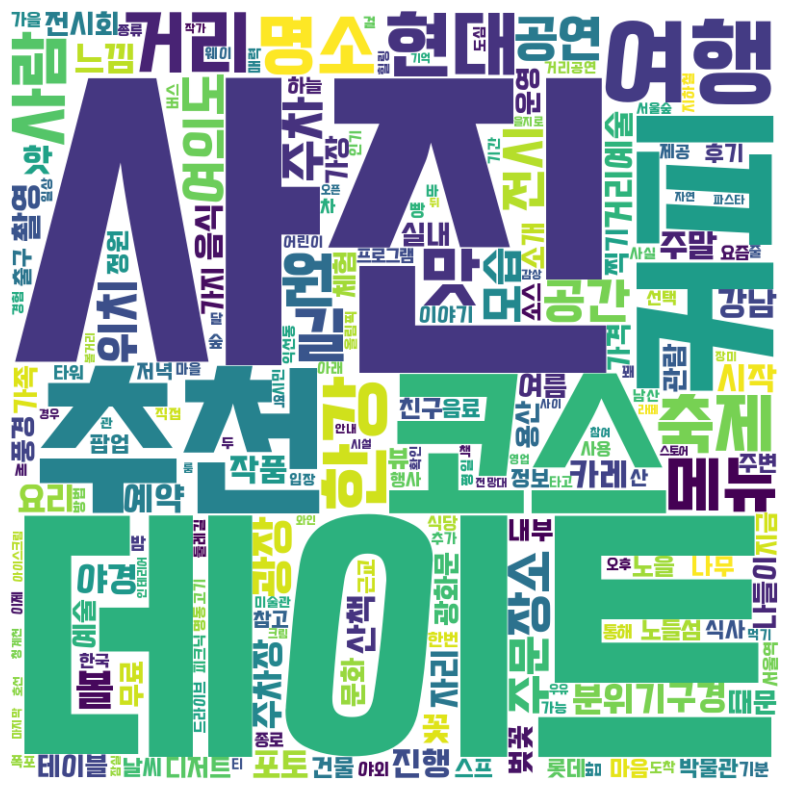

In [6]:
# 추가크롤링 데이터

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Okt
import re

okt = Okt()

# 크롤링한 데이터를 불러옵니다 (최초크롤링 파일을 사용).
df = pd.read_excel("../data/추가크롤링_24-09-04.xlsx")

# 본문 내용과 태그 칼럼을 가져와서 텍스트를 하나로 결합합니다.
text_data = " ".join(df['내용'].dropna()) + " " + " ".join(df['태그'].dropna())

# 텍스트 전처리 (불필요한 특수문자 제거)
text_data = re.sub(r'[^\w\s]', '', text_data)  # 특수문자 제거
text_data = re.sub(r'\d+', '', text_data)  # 숫자 제거

# 불용어 목록 로드
stopwords_file_path = '../data/stopwords-ko.txt'
stopwords_set = load_stopwords(stopwords_file_path)

# 명사 추출
nouns = [word for word, pos in okt.pos(text_data) if pos in ['Noun']]
nouns = get_nouns_from_texts(nouns, stopwords_set)

# 단어 빈도 계산
word_counts = Counter(nouns)

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='../font/Cafe24Ohsquare-v2.0.ttf',  # 한글 폰트 경로 설정
    width=800, 
    height=800,
    background_color='white'
).generate_from_frequencies(word_counts)

# 워드클라우드 시각화
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

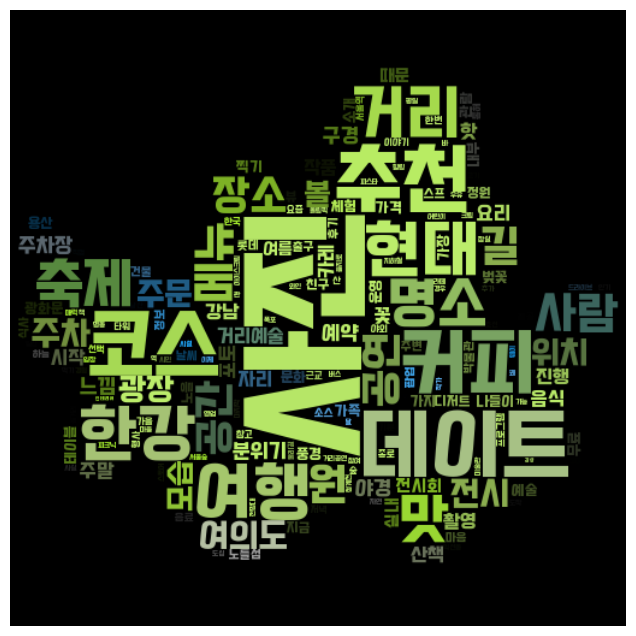

In [11]:
count = Counter(nouns)

wc2_seoul = WordCloud(
    font_path='../font/Cafe24Ohsquare-v2.0.ttf',
    mask=mask,
    background_color="black"
)

wc2_seoul = wc2_seoul.generate_from_frequencies(count)
image_colors=ImageColorGenerator(mask)

plt.figure(figsize=(8,8))
plt.imshow(wc2_seoul.recolor(color_func=image_colors),interpolation="bilinear")
plt.axis("off")
plt.show()

output_path = '../data/wordcloud2_seoul.png'
wc2_seoul.to_file(output_path)